Plotting a UnitIntervalMesh:


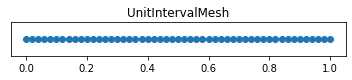

In [1]:
from dolfin import *
import numpy as np
parameters["form_compiler"]["representation"] = 'quadrature'
import warnings
from ffc.quadrature.deprecation import QuadratureRepresentationDeprecationWarning
warnings.simplefilter("once", QuadratureRepresentationDeprecationWarning)
import matplotlib.pyplot as plt

# Form compiler options
parameters["form_compiler"]["cpp_optimize"] = True
parameters["form_compiler"]["optimize"] = True

# Define mesh
mesh = UnitIntervalMesh(50)
#mesh = RectangleMesh(Point(0., 0.), Point(1., 0.1), 50, 5)

print("Plotting a UnitIntervalMesh:")
plt.figure()
plot(mesh, title="UnitIntervalMesh")

tol = 1E-12
# Sub domain for clamp at left end
def left(x, on_boundary):
    return near(x[0], 0.,tol) and on_boundary

# Sub domain for rotation at right end
def right(x, on_boundary):
    return near(x[0], 1.,tol) and on_boundary

# Set up boundary domains

In [2]:
# Create mesh function over the cell facets
boundary_subdomains = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
boundary_subdomains.set_all(0)
force_boundary = AutoSubDomain(right)
force_boundary.mark(boundary_subdomains, 3)

# Define measure for boundary condition integral
dss = ds(subdomain_data=boundary_subdomains)

In [3]:
E = Constant(70e3)
nu = Constant(0.3)
lmbda = E*nu/(1+nu)/(1-2*nu)
mu = E/2./(1+nu)
sig0 = Constant((1e-6))  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus
rho = Constant(10e4)

Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 16000
load_steps = np.linspace(0, 8, Nincr+1)[1:]

dt = Constant(load_steps[1]-load_steps[0])
dt_ = float(dt)

# Newmark-beta method
betaN = Constant(0.25)
gammaN = Constant(0.5)

In [4]:
float(betaN), float(dt)

(0.25, 0.0005)

In [5]:
deg_u = 2
deg_stress = 2
V = FunctionSpace(mesh, "CG", deg_u)
We = VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=1, quad_scheme='default')
W = FunctionSpace(mesh, We)
W0e = FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W0 = FunctionSpace(mesh, W0e)
# Define function space for stresses
Vsig = VectorFunctionSpace(mesh, "DG", 0)

In [6]:
sig = Function(W)
sig_old = Function(W)
beta = Function(W0)
gamma0 = Function(W0)
gamma0.interpolate(Constant(1e-6))
u = Function(V, name="Total displacement")
u_pre = Function(V)
u_old = Function(V)
u_d_old = Function(V)
u_dd_old = Function(V)
du = Function(V, name="Iteration correction")
Du = Function(V, name="Current increment")
v = TrialFunction(V)
u_ = TestFunction(V)

sig_out = Function(Vsig, name="sigma")
eps_out = Function(Vsig, name="epsilon")

In [7]:
# Set up boundary condition at left end
zero = Constant(0.0)
bc = DirichletBC(V, zero, left)
# bc = [DirichletBC(V.sub(1), 0, facets, 1), DirichletBC(V.sub(0), 0, facets, 3)]
n = FacetNormal(mesh)
q_lim = float(2/sqrt(3)*sig0*mu*2)
# loading = Expression("q*t", q=q_lim, t=0, degree=2)
loading = Expression(("t <= tc ? q*t*(1-t)*4 : 0"), q=0.2*q_lim, t=0, tc=0.7, degree=2)
# p = Expression(("t <= tc ? p0*t/tc : 0", "0", "0"), t=0, tc=cutoff_Tc, p0=p0, degree=0)

def F_ext(v):
    return dot(loading,v)*dss(3)
    # return loading*dot(n, v)*dss(3)

In [8]:
# Update formula for acceleration
# a = 1/(2*beta)*((u - u0 - v0*dt)/(0.5*dt*dt) - (1-2*beta)*a0)
def update_a(u, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        betaN_ = betaN
    else:
        dt_ = float(dt)
        betaN_ = float(betaN)
    return (u-u_old-dt_*v_old)/betaN_/dt_**2 - (1-2*betaN_)/2/betaN_*a_old

# Update formula for velocity
# v = dt * ((1-gamma)*a0 + gamma*a) + v0
def update_v(a, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        gamma_ = gammaN
    else:
        dt_ = float(dt)
        gamma_ = float(gammaN)
    return v_old + dt_*((1-gamma_)*a_old + gamma_*a)

def update_fields(u, u_old, v_old, a_old):
    """Update fields at the end of each time step."""

    # Get vectors (references)
    u_vec, u0_vec  = u.vector(), u_old.vector()
    v0_vec, a0_vec = v_old.vector(), a_old.vector()

    # use update functions using vector arguments
    a_vec = update_a(u_vec, u0_vec, v0_vec, a0_vec, ufl=False)
    v_vec = update_v(a_vec, u0_vec, v0_vec, a0_vec, ufl=False)

    # Update (u_old <- u)
    v_old.vector()[:], a_old.vector()[:] = v_vec, a_vec
    u_old.vector()[:] = u.vector()

In [9]:
def eps(v):
    e = 0.5*grad(v)
    return e

def sigma(eps_el):
    return 2*mu*eps_el

def sigma_out(r):
    return 2.0*mu*sym(grad(r))

In [10]:
def proj_sig(old_u,old_sig,old_Du):
    eps_old = eps(old_u)
    beta = sig0/(abs(eps_old[0])+sig0)
    # beta = gamma0
    # beta /= (eps_old[0]+as_tensor(gamma0[0]))
    return 2*mu*beta*eps(old_Du)+old_sig, beta


In [11]:
def sigma_tang(e):
    return 2*mu*beta*e

In [12]:
metadata = {"quadrature_degree": deg_stress, "quadrature_scheme": "default"}
dxm = dx(metadata=metadata)

# a_Newton = inner(eps(v), sigma_tang(eps(u_)))*dxm

# a_Newton = inner(eps(u_), sigma_tang(eps(v)))*dxm

a_Newton = rho*inner(u_,v)/(betaN*dt*dt)*dxm + inner(eps(u_), sigma_tang(eps(v)) )*dxm

res = (-rho)*inner(u_,u)/(betaN*dt*dt)*dxm + \
      -inner(eps(u_), sig)*dxm + \
      F_ext(u_) + \
      rho*inner(u_old+dt*u_d_old,u_)*1./(betaN*dt*dt)*dxm + \
      (1.-2*betaN)/(2*betaN)*rho*inner(u_dd_old,u_)*dxm

In [13]:
def local_project(v, V, u=None):
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dxm
    b_proj = inner(v, v_)*dxm
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [14]:
file_results = XDMFFile("plasticity_results.xdmf")
file_results.parameters["flush_output"] = True
file_results.parameters["functions_share_mesh"] = True

In [15]:
sig_out.ufl_shape

(1,)

In [16]:
results = np.zeros((Nincr+1, 5))
results_1d = np.zeros((Nincr+1, 50))
for (i, t) in enumerate(load_steps):
    loading.t = t
    sig_, beta_ = proj_sig(u,sig_old,Du)
    local_project(sig_, W, sig)
    local_project(beta_, W0, beta)
    A, Res = assemble_system(a_Newton, res, bc)
    nRes0 = Res.norm("l2")
    nRes = nRes0
    Du.interpolate(Constant(0))
    print("Increment:", str(i+1),"   Initial Residual:", nRes0)
    niter = 0
    u_pre.assign(u)
    while (nRes/nRes0 > tol and nRes0>1e-10) and niter < Nitermax:
        solve(A, du.vector(), Res, "mumps")
        Du.assign(Du+du)
        u.assign(u+du) # u^{k+1}_{n+1}
        sig_, beta_ = proj_sig(u_pre,sig_old,Du)
        local_project(sig_, W, sig)
        local_project(beta_, W0, beta)
        A, Res = assemble_system(a_Newton, res, bc)
        nRes = Res.norm("l2")
        print("    Residual:", nRes," ",niter)
        niter += 1
    u.assign(u_pre+Du)
    
    update_fields(u, u_old, u_d_old, u_dd_old)
    
    sig_old.assign(sig)
    
# ----------------
# Post-processing
# ----------------
#
# Inside the incremental loop, the displacement and plastic strains are exported
# at each time increment, the plastic strain must first be projected onto the
# previously defined DG FunctionSpace. We also monitor the value of the cylinder
# displacement on the inner boundary. The load-displacement curve is then plotted::

    local_project(sig, Vsig, sig_out)
    local_project(eps(u), Vsig, eps_out)
    
    file_results.write(u, t)
    for i_x in range(50):
        results_1d[i+1,i_x] = u(i_x/50)
    tc = 0.7;
    if t<tc:
        # results[i+1, :] = (u(1),t,4*t*(1-t))
        results[i+1, :] = (u(1), sig_out(1),t,4*t*(1-t),eps_out(1))
    else:
        results[i+1, :] = (u(1), sig_out(1),t,0,eps_out(1))


/home/aangniu/anaconda3/envs/fenicsproject/lib/python3.9/site-packages/ffc/jitcompiler.py:234: QuadratureRepresentationDeprecationWarning: 
*** ===================================================== ***
*** FFC: quadrature representation is deprecated! It will ***
*** likely be removed in 2018.2.0 release. Use uflacs     ***
*** representation instead.                               ***
*** ===================================================== ***
  issue_deprecation_warning()


Increment: 1    Initial Residual: 2.4858037897755184e-05
    Residual: 8.523761191029038e-19   0
Increment: 2    Initial Residual: 0.00012345216960917693
    Residual: 3.7572009748955143e-06   0
    Residual: 1.7434489332118667e-18   1
Increment: 3    Initial Residual: 0.00032095288949800547
    Residual: 8.852694183303506e-06   0
    Residual: 3.2127470997015803e-18   1
Increment: 4    Initial Residual: 0.0006147008429093563
    Residual: 1.1008564347232478e-05   0
    Residual: 4.559383756793414e-18   1
Increment: 5    Initial Residual: 0.0010056897326638252
    Residual: 1.3744661733533703e-05   0
    Residual: 1.0410798655646295e-17   1
Increment: 6    Initial Residual: 0.0014937493082176586
    Residual: 1.6127731272345327e-05   0
    Residual: 1.0336516089125992e-17   1
Increment: 7    Initial Residual: 0.0020745827886435907
    Residual: 1.650246173266456e-05   0
    Residual: 9.660389423675008e-18   1
Increment: 8    Initial Residual: 0.0027493573333768175
    Residual: 1.78403

    Residual: 1.7091836881477312e-16   1
Increment: 70    Initial Residual: 0.1980682839941232
    Residual: 3.640924690274797e-05   0
    Residual: 4.2353606994008053e-16   1
Increment: 71    Initial Residual: 0.20319526669209229
    Residual: 3.6776546797446834e-05   0
    Residual: 7.321485274387112e-16   1
Increment: 72    Initial Residual: 0.20837294610105392
    Residual: 3.684569793800503e-05   0
    Residual: 7.925047778917517e-16   1
Increment: 73    Initial Residual: 0.21359793678457717
    Residual: 3.622730086993035e-05   0
    Residual: 2.1859921827594729e-16   1
Increment: 74    Initial Residual: 0.2188712747392366
    Residual: 3.575757259176703e-05   0
    Residual: 1.4561098500143923e-15   1
Increment: 75    Initial Residual: 0.22419154819256995
    Residual: 3.581419448774893e-05   0
    Residual: 9.943895946518716e-16   1
Increment: 76    Initial Residual: 0.22955482819152936
    Residual: 3.5477622337712755e-05   0
    Residual: 1.0191158357092976e-15   1
Increment:

    Residual: 3.536717197364813e-05   0
    Residual: 2.2699349269626363e-15   1
Increment: 132    Initial Residual: 0.5831829362489399
    Residual: 3.5274300677338545e-05   0
    Residual: 5.008754079173019e-15   1
Increment: 133    Initial Residual: 0.5902473393919334
    Residual: 3.5008639416104e-05   0
    Residual: 2.7785961391801157e-15   1
Increment: 134    Initial Residual: 0.5973356572306125
    Residual: 3.534184796588041e-05   0
    Residual: 1.0529107471245192e-15   1
Increment: 135    Initial Residual: 0.6044483098738612
    Residual: 3.5908591299223414e-05   0
    Residual: 5.634815171130786e-15   1
Increment: 136    Initial Residual: 0.6115843019107384
    Residual: 3.597420562717985e-05   0
    Residual: 4.1454258551917886e-15   1
Increment: 137    Initial Residual: 0.6187441186790935
    Residual: 3.586379560756864e-05   0
    Residual: 8.058019149735318e-16   1
Increment: 138    Initial Residual: 0.6259245019357756
    Residual: 3.5474521184088596e-05   0
    Residu

    Residual: 3.2560805180459294e-05   0
    Residual: 2.71562460306537e-15   1
Increment: 199    Initial Residual: 1.102179153292464
    Residual: 3.295771631865048e-05   0
    Residual: 2.2939967771526275e-15   1
Increment: 200    Initial Residual: 1.1105596916046516
    Residual: 3.405367785796215e-05   0
    Residual: 4.239244631658927e-15   1
Increment: 201    Initial Residual: 1.1189608635236632
    Residual: 3.450553527334687e-05   0
    Residual: 6.1577713249457094e-15   1
Increment: 202    Initial Residual: 1.1273823081811836
    Residual: 3.430329630225844e-05   0
    Residual: 1.0368487896057761e-14   1
Increment: 203    Initial Residual: 1.1358242099184666
    Residual: 3.4221939689379216e-05   0
    Residual: 8.58681857044875e-15   1
Increment: 204    Initial Residual: 1.1442832356494015
    Residual: 3.3731638376696515e-05   0
    Residual: 1.2998258950519065e-14   1
Increment: 205    Initial Residual: 1.1527592076342124
    Residual: 3.3532954744962346e-05   0
    Residu

    Residual: 4.4879601415661485e-14   1
Increment: 261    Initial Residual: 1.6489885849160693
    Residual: 3.227553536409178e-05   0
    Residual: 2.0914131056750073e-14   1
Increment: 262    Initial Residual: 1.658217076327764
    Residual: 3.196003803906134e-05   0
    Residual: 2.599122909913533e-14   1
Increment: 263    Initial Residual: 1.6674556745330302
    Residual: 3.236054271327366e-05   0
    Residual: 1.5367884287428426e-14   1
Increment: 264    Initial Residual: 1.6767033512766318
    Residual: 3.199509653000234e-05   0
    Residual: 1.0079477476078467e-14   1
Increment: 265    Initial Residual: 1.6859637417051572
    Residual: 3.186680163417379e-05   0
    Residual: 1.627498578384141e-14   1
Increment: 266    Initial Residual: 1.695240131078381
    Residual: 3.249717562842012e-05   0
    Residual: 7.747234739910954e-15   1
Increment: 267    Initial Residual: 1.7045304181484262
    Residual: 3.236459506332891e-05   0
    Residual: 2.0598090462346834e-14   1
Increment: 2

    Residual: 3.145182273702265e-05   0
    Residual: 1.9649013958038246e-14   1
Increment: 329    Initial Residual: 2.3005635938069773
    Residual: 3.1927155755312464e-05   0
    Residual: 1.8126017596510848e-14   1
Increment: 330    Initial Residual: 2.3104751887642934
    Residual: 3.137487462685582e-05   0
    Residual: 2.5916276196583475e-14   1
Increment: 331    Initial Residual: 2.320395554158508
    Residual: 3.12078035862181e-05   0
    Residual: 3.285647698174164e-14   1
Increment: 332    Initial Residual: 2.330326134459106
    Residual: 3.164086725555725e-05   0
    Residual: 1.7541545937776822e-14   1
Increment: 333    Initial Residual: 2.3402636088252264
    Residual: 3.1220197173262895e-05   0
    Residual: 5.4852528782241466e-14   1
Increment: 334    Initial Residual: 2.3502075472158332
    Residual: 3.095086148480004e-05   0
    Residual: 2.283343141480341e-14   1
Increment: 335    Initial Residual: 2.360156970082673
    Residual: 3.120704791810378e-05   0
    Residual

    Residual: 2.075749152989791e-14   1
Increment: 391    Initial Residual: 2.9280959688232047
    Residual: 3.0699209454904876e-05   0
    Residual: 5.833427675483688e-14   1
Increment: 392    Initial Residual: 2.9384354799110888
    Residual: 3.107791458769265e-05   0
    Residual: 5.1724261255981535e-14   1
Increment: 393    Initial Residual: 2.9487856781946418
    Residual: 3.081598549972244e-05   0
    Residual: 3.9877851006307553e-14   1
Increment: 394    Initial Residual: 2.959145420672252
    Residual: 3.070182256443495e-05   0
    Residual: 7.58136026708502e-14   1
Increment: 395    Initial Residual: 2.9695132057379285
    Residual: 3.0661660816331515e-05   0
    Residual: 5.95951928452634e-14   1
Increment: 396    Initial Residual: 2.9798866660345604
    Residual: 2.9847737284552394e-05   0
    Residual: 1.2792555095784524e-14   1
Increment: 397    Initial Residual: 2.9902683166918456
    Residual: 2.9816331755864727e-05   0
    Residual: 6.411911854748317e-14   1
Increment: 

    Residual: 2.9417626429467126e-05   0
    Residual: 2.5860213240480498e-14   1
Increment: 459    Initial Residual: 3.6416826721197877
    Residual: 2.9214957189909665e-05   0
    Residual: 1.9462553428307135e-14   1
Increment: 460    Initial Residual: 3.652299525846843
    Residual: 2.9204754877515836e-05   0
    Residual: 7.491091910458145e-14   1
Increment: 461    Initial Residual: 3.662913138125147
    Residual: 2.9382241573662293e-05   0
    Residual: 9.15673767004167e-14   1
Increment: 462    Initial Residual: 3.673522581897699
    Residual: 2.8770627225012807e-05   0
    Residual: 1.119922983777732e-13   1
Increment: 463    Initial Residual: 3.6841324400359046
    Residual: 2.892145466741498e-05   0
    Residual: 3.76854036210843e-14   1
Increment: 464    Initial Residual: 3.6947451777899003
    Residual: 2.9490030503683974e-05   0
    Residual: 1.06422977799341e-13   1
Increment: 465    Initial Residual: 3.7053590204937294
    Residual: 2.8932673036977997e-05   0
    Residual

    Residual: 2.8340738188405456e-05   0
    Residual: 9.906012098605512e-14   1
Increment: 552    Initial Residual: 4.639489666548038
    Residual: 2.7860528334972235e-05   0
    Residual: 1.6691568755864073e-13   1
Increment: 553    Initial Residual: 4.6502717970937795
    Residual: 2.7795963218528414e-05   0
    Residual: 1.0803238341471666e-13   1
Increment: 554    Initial Residual: 4.661058653541151
    Residual: 2.849269197738596e-05   0
    Residual: 4.4801879843964554e-14   1
Increment: 555    Initial Residual: 4.671846085591751
    Residual: 2.825587210414173e-05   0
    Residual: 1.8833576813878571e-13   1
Increment: 556    Initial Residual: 4.6826337582770945
    Residual: 2.7755965901349644e-05   0
    Residual: 1.3924825833873764e-13   1
Increment: 557    Initial Residual: 4.693422610327536
    Residual: 2.7922545425047305e-05   0
    Residual: 7.857573415176173e-14   1
Increment: 558    Initial Residual: 4.704211425431702
    Residual: 2.781371246604647e-05   0
    Residu

    Residual: 2.776560901100609e-05   0
    Residual: 1.8646732259956925e-13   1
Increment: 616    Initial Residual: 5.3302015614061204
    Residual: 2.7491984538251908e-05   0
    Residual: 9.878488871883733e-14   1
Increment: 617    Initial Residual: 5.340991247355037
    Residual: 2.7471045555342523e-05   0
    Residual: 1.0647726573093093e-13   1
Increment: 618    Initial Residual: 5.351776318997642
    Residual: 2.7059273333053067e-05   0
    Residual: 7.536368829911747e-14   1
Increment: 619    Initial Residual: 5.362555934289917
    Residual: 2.679247845147343e-05   0
    Residual: 1.0526497316794911e-13   1
Increment: 620    Initial Residual: 5.373331759397946
    Residual: 2.7448346831478636e-05   0
    Residual: 1.1623917148577251e-13   1
Increment: 621    Initial Residual: 5.384100474387988
    Residual: 2.7552053147765692e-05   0
    Residual: 1.7354779618285094e-13   1
Increment: 622    Initial Residual: 5.39486109292578
    Residual: 2.7057821907844354e-05   0
    Residua

    Residual: 2.589407278250243e-05   0
    Residual: 1.7298904135845637e-13   1
Increment: 680    Initial Residual: 6.016093185907245
    Residual: 2.5966362241352306e-05   0
    Residual: 1.2421764350767796e-13   1
Increment: 681    Initial Residual: 6.026742836051429
    Residual: 2.64506382281861e-05   0
    Residual: 1.6698207895989494e-13   1
Increment: 682    Initial Residual: 6.037386680271191
    Residual: 2.667377015550949e-05   0
    Residual: 1.6014085313813947e-13   1
Increment: 683    Initial Residual: 6.048025560744123
    Residual: 2.679195151308372e-05   0
    Residual: 1.3832117031975495e-13   1
Increment: 684    Initial Residual: 6.058656550231945
    Residual: 2.6994916560859344e-05   0
    Residual: 2.306630872173707e-13   1
Increment: 685    Initial Residual: 6.069277629176748
    Residual: 2.6699927835200184e-05   0
    Residual: 2.1575572662166955e-13   1
Increment: 686    Initial Residual: 6.079892394846132
    Residual: 2.6639548387739475e-05   0
    Residual:

    Residual: 2.5715227392661396e-05   0
    Residual: 1.786997038206848e-13   1
Increment: 776    Initial Residual: 7.0225220361155145
    Residual: 2.5715730053451225e-05   0
    Residual: 3.1822660629937543e-13   1
Increment: 777    Initial Residual: 7.032816686370354
    Residual: 2.5893868276459552e-05   0
    Residual: 1.922621568736484e-13   1
Increment: 778    Initial Residual: 7.043106981599878
    Residual: 2.6028504040446248e-05   0
    Residual: 2.1571658850852692e-13   1
Increment: 779    Initial Residual: 7.053392806573236
    Residual: 2.570209297048411e-05   0
    Residual: 2.068515987673353e-13   1
Increment: 780    Initial Residual: 7.0636746712004435
    Residual: 2.4989697064366963e-05   0
    Residual: 1.6589839762814276e-13   1
Increment: 781    Initial Residual: 7.073948466459898
    Residual: 2.479056837705165e-05   0
    Residual: 4.97943170142758e-13   1
Increment: 782    Initial Residual: 7.084214520041482
    Residual: 2.5207227557496244e-05   0
    Residual

    Residual: 2.057088482313056e-13   1
Increment: 865    Initial Residual: 7.918107358389767
    Residual: 2.5601727328506177e-05   0
    Residual: 1.8305433089027926e-13   1
Increment: 866    Initial Residual: 7.927919855462017
    Residual: 2.504300067778314e-05   0
    Residual: 4.02431347989679e-13   1
Increment: 867    Initial Residual: 7.937724121519573
    Residual: 2.493249745962815e-05   0
    Residual: 2.0828592740132527e-13   1
Increment: 868    Initial Residual: 7.9475212293254645
    Residual: 2.495800093741606e-05   0
    Residual: 2.6507628622451945e-13   1
Increment: 869    Initial Residual: 7.957308996518023
    Residual: 2.4882778979982146e-05   0
    Residual: 1.991342470493112e-13   1
Increment: 870    Initial Residual: 7.967089329416465
    Residual: 2.493073681235254e-05   0
    Residual: 1.8429405212564632e-13   1
Increment: 871    Initial Residual: 7.976863907390053
    Residual: 2.4457531420099962e-05   0
    Residual: 3.2334108746366775e-13   1
Increment: 872

    Residual: 3.874451050382122e-13   1
Increment: 944    Initial Residual: 8.672300109916055
    Residual: 2.459755016599506e-05   0
    Residual: 1.8264436897185226e-13   1
Increment: 945    Initial Residual: 8.681575326629597
    Residual: 2.4378398333223427e-05   0
    Residual: 3.161231932493987e-13   1
Increment: 946    Initial Residual: 8.69083703452809
    Residual: 2.4601046228314027e-05   0
    Residual: 2.4631127635244193e-13   1
Increment: 947    Initial Residual: 8.70008619551976
    Residual: 2.4899531395664783e-05   0
    Residual: 3.7188556809119463e-13   1
Increment: 948    Initial Residual: 8.709322312000108
    Residual: 2.4445889332419482e-05   0
    Residual: 2.0996864696174934e-13   1
Increment: 949    Initial Residual: 8.718550379678739
    Residual: 2.4663959745941463e-05   0
    Residual: 2.400750956193573e-13   1
Increment: 950    Initial Residual: 8.727773630656996
    Residual: 2.4964742912966612e-05   0
    Residual: 3.606910812259299e-13   1
Increment: 951

Increment: 1028    Initial Residual: 9.423098509463689
    Residual: 2.591027654795075e-05   0
    Residual: 2.4438209813068124e-13   1
Increment: 1029    Initial Residual: 9.431677547128661
    Residual: 2.5419197004902058e-05   0
    Residual: 5.508529255644748e-13   1
Increment: 1030    Initial Residual: 9.440246840050282
    Residual: 2.440876124486958e-05   0
    Residual: 5.106726883054218e-13   1
Increment: 1031    Initial Residual: 9.448806590487052
    Residual: 2.349016897392472e-05   0
    Residual: 6.721500719508644e-13   1
Increment: 1032    Initial Residual: 9.457358050596733
    Residual: 2.36395691829632e-05   0
    Residual: 4.680796194889909e-13   1
Increment: 1033    Initial Residual: 9.465899355024696
    Residual: 2.375502365987114e-05   0
    Residual: 2.2861167408965384e-13   1
Increment: 1034    Initial Residual: 9.474434377600556
    Residual: 2.343962510310435e-05   0
    Residual: 3.385959361668228e-13   1
Increment: 1035    Initial Residual: 9.48296822846832

Increment: 1106    Initial Residual: 10.066329247619421
    Residual: 2.5985350948602318e-05   0
    Residual: 3.1481977072813734e-13   1
Increment: 1107    Initial Residual: 10.074220464410411
    Residual: 2.6366345074077177e-05   0
    Residual: 2.842762498360652e-13   1
Increment: 1108    Initial Residual: 10.082101632134396
    Residual: 2.6295211955643454e-05   0
    Residual: 6.551155781413832e-13   1
Increment: 1109    Initial Residual: 10.08997057860498
    Residual: 2.644942406076005e-05   0
    Residual: 4.1586218510246234e-13   1
Increment: 1110    Initial Residual: 10.097827093202543
    Residual: 2.6751879628898368e-05   0
    Residual: 4.625744771920989e-13   1
Increment: 1111    Initial Residual: 10.105673620588954
    Residual: 2.6326866906364438e-05   0
    Residual: 4.2598984389236276e-13   1
Increment: 1112    Initial Residual: 10.113507633772722
    Residual: 2.585161968785188e-05   0
    Residual: 4.4594801247659584e-13   1
Increment: 1113    Initial Residual: 10.

    Residual: 2.4114652846327305e-05   0
    Residual: 5.230244296184736e-13   1
Increment: 1169    Initial Residual: 10.544183300892536
    Residual: 2.4011657953137907e-05   0
    Residual: 6.321095913719838e-13   1
Increment: 1170    Initial Residual: 10.551450455787954
    Residual: 2.3351711958521872e-05   0
    Residual: 5.087514343636279e-13   1
Increment: 1171    Initial Residual: 10.558707774836057
    Residual: 2.350678189330589e-05   0
    Residual: 5.047998907760961e-13   1
Increment: 1172    Initial Residual: 10.565958909525168
    Residual: 2.375211991753995e-05   0
    Residual: 4.11196105123974e-13   1
Increment: 1173    Initial Residual: 10.573200314772425
    Residual: 2.3766394344178045e-05   0
    Residual: 4.782208932777854e-13   1
Increment: 1174    Initial Residual: 10.580428859549244
    Residual: 2.4008829332844065e-05   0
    Residual: 8.581801461166515e-13   1
Increment: 1175    Initial Residual: 10.587646828867008
    Residual: 2.409987039859428e-05   0
    

Increment: 1238    Initial Residual: 11.021768559608617
    Residual: 2.6306749424515438e-05   0
    Residual: 3.821322162834529e-13   1
Increment: 1239    Initial Residual: 11.028320483523451
    Residual: 2.6157604348004445e-05   0
    Residual: 5.479566624465213e-13   1
Increment: 1240    Initial Residual: 11.034865514639618
    Residual: 2.628838622272403e-05   0
    Residual: 5.417348342712602e-13   1
Increment: 1241    Initial Residual: 11.04140037216241
    Residual: 2.6156095827478624e-05   0
    Residual: 4.194348419199499e-13   1
Increment: 1242    Initial Residual: 11.047926176150984
    Residual: 2.5836374274454844e-05   0
    Residual: 8.283608866350976e-13   1
Increment: 1243    Initial Residual: 11.054441624584962
    Residual: 2.606470862225831e-05   0
    Residual: 6.855584560499677e-13   1
Increment: 1244    Initial Residual: 11.060943987685796
    Residual: 2.6184296663705912e-05   0
    Residual: 3.220424978396187e-13   1
Increment: 1245    Initial Residual: 11.0674

Increment: 1307    Initial Residual: 11.449128179122258
    Residual: 2.498475310790114e-05   0
    Residual: 6.704506616974556e-13   1
Increment: 1308    Initial Residual: 11.454945690041983
    Residual: 2.4543981740316265e-05   0
    Residual: 4.3682575835750907e-13   1
Increment: 1309    Initial Residual: 11.460755236504838
    Residual: 2.4302301875544092e-05   0
    Residual: 5.568414730087637e-13   1
Increment: 1310    Initial Residual: 11.466557230527501
    Residual: 2.408352042873897e-05   0
    Residual: 6.640544821778587e-13   1
Increment: 1311    Initial Residual: 11.47234606950464
    Residual: 2.4607711817607865e-05   0
    Residual: 5.594851492237092e-13   1
Increment: 1312    Initial Residual: 11.478121023875422
    Residual: 2.515334752519168e-05   0
    Residual: 7.517412549465988e-13   1
Increment: 1313    Initial Residual: 11.483885388776795
    Residual: 2.5383269284446122e-05   0
    Residual: 5.458516045483418e-13   1
Increment: 1314    Initial Residual: 11.4896

Increment: 1377    Initial Residual: 11.829607701598109
    Residual: 2.5359208995241668e-05   0
    Residual: 1.0616883399732589e-12   1
Increment: 1378    Initial Residual: 11.834656570177446
    Residual: 2.5520358106027985e-05   0
    Residual: 6.269258979610086e-13   1
Increment: 1379    Initial Residual: 11.839692014466127
    Residual: 2.6092200116585263e-05   0
    Residual: 8.304380698672764e-13   1
Increment: 1380    Initial Residual: 11.844714653096517
    Residual: 2.6636568998785904e-05   0
    Residual: 8.708352481064689e-13   1
Increment: 1381    Initial Residual: 11.84972421573885
    Residual: 2.7053447150272935e-05   0
    Residual: 5.341361091340395e-13   1
Increment: 1382    Initial Residual: 11.85471867254176
    Residual: 2.740315103010888e-05   0
    Residual: 1.046175347618692e-12   1
Increment: 1383    Initial Residual: 11.859701879846384
    Residual: 2.7735265954792177e-05   0
    Residual: 8.738112008546761e-13   1
Increment: 1384    Initial Residual: 11.864

Increment: 1448    Initial Residual: 11.894846367316788
    Residual: 0.002595183482329969   0
    Residual: 1.0011263293567075e-12   1
Increment: 1449    Initial Residual: 11.896885247457565
    Residual: 0.0022869168972015712   0
    Residual: 8.558176858897509e-13   1
Increment: 1450    Initial Residual: 11.899721812164257
    Residual: 0.0021776885814620665   0
    Residual: 1.0915680035781079e-12   1
Increment: 1451    Initial Residual: 11.900710773013346
    Residual: 0.0024895984523689136   0
    Residual: 8.791359106031737e-13   1
Increment: 1452    Initial Residual: 11.901721473547333
    Residual: 0.0026306818003108963   0
    Residual: 5.755813547869127e-13   1
Increment: 1453    Initial Residual: 11.901827384560116
    Residual: 0.0025182463940002387   0
    Residual: 6.588354732922606e-13   1
Increment: 1454    Initial Residual: 11.900295979756976
    Residual: 0.0020705363399305086   0
    Residual: 5.832184487463475e-13   1
Increment: 1455    Initial Residual: 11.9007849

Increment: 1517    Initial Residual: 11.908605697219373
    Residual: 0.0023953535232314194   0
    Residual: 8.679440288209808e-13   1
Increment: 1518    Initial Residual: 11.90961277953884
    Residual: 0.0025081451749537796   0
    Residual: 6.878716631988818e-13   1
Increment: 1519    Initial Residual: 11.909832283448116
    Residual: 0.0025807631365043736   0
    Residual: 9.059322976508954e-13   1
Increment: 1520    Initial Residual: 11.91047355510287
    Residual: 0.0026635147410396555   0
    Residual: 7.647079885364818e-13   1
Increment: 1521    Initial Residual: 11.908846657911667
    Residual: 0.002388348242798386   0
    Residual: 8.77514111243637e-13   1
Increment: 1522    Initial Residual: 11.905544921048222
    Residual: 0.002321384846575216   0
    Residual: 1.0344982712821138e-12   1
Increment: 1523    Initial Residual: 11.904281691681676
    Residual: 0.002304407147468712   0
    Residual: 5.101370987216055e-13   1
Increment: 1524    Initial Residual: 11.9037084290289

Increment: 1587    Initial Residual: 11.906995131380608
    Residual: 0.002587125648916946   0
    Residual: 7.923892905156972e-13   1
Increment: 1588    Initial Residual: 11.9084118654297
    Residual: 0.0026847026748473162   0
    Residual: 1.6738305930916598e-12   1
Increment: 1589    Initial Residual: 11.906976640050708
    Residual: 0.0024412021115244723   0
    Residual: 1.031548509972181e-12   1
Increment: 1590    Initial Residual: 11.904597473335823
    Residual: 0.0025463440748590273   0
    Residual: 1.191145928355214e-12   1
Increment: 1591    Initial Residual: 11.903772135170094
    Residual: 0.0026767244002485354   0
    Residual: 7.220755585157521e-13   1
Increment: 1592    Initial Residual: 11.902812984613647
    Residual: 0.0026590960460041438   0
    Residual: 8.026664013464624e-13   1
Increment: 1593    Initial Residual: 11.902970640696022
    Residual: 0.0028046852479236993   0
    Residual: 1.001775826065203e-12   1
Increment: 1594    Initial Residual: 11.9050629447

Increment: 1654    Initial Residual: 11.890921847125364
    Residual: 0.002842695934885692   0
    Residual: 8.604090792618231e-13   1
Increment: 1655    Initial Residual: 11.890853111136167
    Residual: 0.002883057784760355   0
    Residual: 1.0452056791910554e-12   1
Increment: 1656    Initial Residual: 11.891453514627361
    Residual: 0.002272209765938763   0
    Residual: 8.323552733258352e-13   1
Increment: 1657    Initial Residual: 11.890121705249927
    Residual: 0.0023259952682588053   0
    Residual: 1.2682254101966604e-12   1
Increment: 1658    Initial Residual: 11.889446427632944
    Residual: 0.002477452348309245   0
    Residual: 7.418541013362462e-13   1
Increment: 1659    Initial Residual: 11.889797376075565
    Residual: 0.0025249223893915244   0
    Residual: 1.3179565735256352e-12   1
Increment: 1660    Initial Residual: 11.88972912357293
    Residual: 0.002795843195420735   0
    Residual: 1.1706103362772433e-12   1
Increment: 1661    Initial Residual: 11.8917652469

Increment: 1721    Initial Residual: 11.90061342969053
    Residual: 0.002116239364492944   0
    Residual: 1.2390525658792432e-12   1
Increment: 1722    Initial Residual: 11.899326208961627
    Residual: 0.002726840860354821   0
    Residual: 1.3223193261050414e-12   1
Increment: 1723    Initial Residual: 11.900514855023903
    Residual: 0.002956392210351839   0
    Residual: 1.072106572132994e-12   1
Increment: 1724    Initial Residual: 11.90162566457955
    Residual: 0.001770118318931418   0
    Residual: 9.6506505169034e-13   1
Increment: 1725    Initial Residual: 11.901581139861475
    Residual: 0.002393428415814632   0
    Residual: 1.220182778613936e-12   1
Increment: 1726    Initial Residual: 11.902695218798572
    Residual: 0.0032525128266372525   0
    Residual: 1.271250561275828e-12   1
Increment: 1727    Initial Residual: 11.903454225620331
    Residual: 0.0027016597605319546   0
    Residual: 1.0541262940148244e-12   1
Increment: 1728    Initial Residual: 11.90371272869216

Increment: 1790    Initial Residual: 11.889499549674696
    Residual: 0.00198431755978013   0
    Residual: 9.985155481521362e-13   1
Increment: 1791    Initial Residual: 11.887685841363526
    Residual: 0.002816700649104348   0
    Residual: 1.2048911050879318e-12   1
Increment: 1792    Initial Residual: 11.885039385104621
    Residual: 0.0022822205300576095   0
    Residual: 1.4778636002405034e-12   1
Increment: 1793    Initial Residual: 11.882401589925674
    Residual: 0.002495672618398572   0
    Residual: 1.182602840674852e-12   1
Increment: 1794    Initial Residual: 11.881103236338255
    Residual: 0.0035156554544385358   0
    Residual: 1.1418981546928458e-12   1
Increment: 1795    Initial Residual: 11.878888079534747
    Residual: 0.002350762827422065   0
    Residual: 1.1069791908881374e-12   1
Increment: 1796    Initial Residual: 11.877515556465779
    Residual: 0.0018398886775663772   0
    Residual: 9.74223937461473e-13   1
Increment: 1797    Initial Residual: 11.8790984351

Increment: 1859    Initial Residual: 11.905029388509197
    Residual: 0.0029600510015142328   0
    Residual: 1.2214515936883019e-12   1
Increment: 1860    Initial Residual: 11.904308840786765
    Residual: 0.0030611811559285106   0
    Residual: 1.1892727781469477e-12   1
Increment: 1861    Initial Residual: 11.904477964586711
    Residual: 0.0025059003378370783   0
    Residual: 1.225240445298707e-12   1
Increment: 1862    Initial Residual: 11.905029154285005
    Residual: 0.002884997302008075   0
    Residual: 1.0858344938779204e-12   1
Increment: 1863    Initial Residual: 11.904193032982437
    Residual: 0.0022028958583657507   0
    Residual: 1.5133841843203676e-12   1
Increment: 1864    Initial Residual: 11.904973360616944
    Residual: 0.0019438418038588998   0
    Residual: 1.267311343642042e-12   1
Increment: 1865    Initial Residual: 11.907488132817793
    Residual: 0.003134848124804925   0
    Residual: 1.0094447962099648e-12   1
Increment: 1866    Initial Residual: 11.90863

Increment: 1922    Initial Residual: 11.888659654029276
    Residual: 0.0024530731929204453   0
    Residual: 1.1390073875663987e-12   1
Increment: 1923    Initial Residual: 11.890650518394954
    Residual: 0.0032740358649612994   0
    Residual: 1.2496730889015877e-12   1
Increment: 1924    Initial Residual: 11.891103581308036
    Residual: 0.0023358407263498735   0
    Residual: 1.2353495497216692e-12   1
Increment: 1925    Initial Residual: 11.890990860745527
    Residual: 0.002225839175426454   0
    Residual: 1.2339284587438252e-12   1
Increment: 1926    Initial Residual: 11.89323304544874
    Residual: 0.0030313785133829966   0
    Residual: 1.3047327901128762e-12   1
Increment: 1927    Initial Residual: 11.89529933178166
    Residual: 0.0026687550803383433   0
    Residual: 1.6134696006489417e-12   1
Increment: 1928    Initial Residual: 11.896271416370105
    Residual: 0.002381831938803029   0
    Residual: 9.918089684972483e-13   1
Increment: 1929    Initial Residual: 11.898129

Increment: 1988    Initial Residual: 11.905594606546416
    Residual: 0.0030445415114433772   0
    Residual: 1.0994528783775777e-12   1
Increment: 1989    Initial Residual: 11.905378915981919
    Residual: 0.0026481745447812276   0
    Residual: 1.4989574968668922e-12   1
Increment: 1990    Initial Residual: 11.904859110525187
    Residual: 0.0022815698085878267   0
    Residual: 1.0297643583854994e-12   1
Increment: 1991    Initial Residual: 11.904239849671491
    Residual: 0.003103832972853964   0
    Residual: 9.290747915543078e-13   1
Increment: 1992    Initial Residual: 11.901640692517013
    Residual: 0.002315078988896315   0
    Residual: 1.1996963120810077e-12   1
Increment: 1993    Initial Residual: 11.899905752779345
    Residual: 0.0023357137879803347   0
    Residual: 7.286363200749987e-13   1
Increment: 1994    Initial Residual: 11.900023407179578
    Residual: 0.0031045143743356246   0
    Residual: 1.5964828040543534e-12   1
Increment: 1995    Initial Residual: 11.89903

Increment: 2055    Initial Residual: 11.90315097620981
    Residual: 0.0032975975927505684   0
    Residual: 8.471087214466736e-13   1
Increment: 2056    Initial Residual: 11.90577849626583
    Residual: 0.0025076929936639655   0
    Residual: 9.154370816192098e-13   1
Increment: 2057    Initial Residual: 11.905758088845182
    Residual: 0.0025567003982334214   0
    Residual: 1.264974592810424e-12   1
Increment: 2058    Initial Residual: 11.905522262707498
    Residual: 0.003121698547340271   0
    Residual: 1.0935803325441132e-12   1
Increment: 2059    Initial Residual: 11.9038896493065
    Residual: 0.0023946274373334853   0
    Residual: 1.812729298047413e-12   1
Increment: 2060    Initial Residual: 11.900801536893226
    Residual: 0.0027107890084084227   0
    Residual: 1.0158965830977207e-12   1
Increment: 2061    Initial Residual: 11.899645304142025
    Residual: 0.0027388313122889384   0
    Residual: 2.162754412177177e-12   1
Increment: 2062    Initial Residual: 11.89903739104

Increment: 2118    Initial Residual: 11.910401090390492
    Residual: 0.002832480260355751   0
    Residual: 1.431559854116932e-12   1
Increment: 2119    Initial Residual: 11.9111260756119
    Residual: 0.002659573144158362   0
    Residual: 8.557033471562751e-13   1
Increment: 2120    Initial Residual: 11.912659986011702
    Residual: 0.0025762766436963377   0
    Residual: 1.0467573349229313e-12   1
Increment: 2121    Initial Residual: 11.912699131149532
    Residual: 0.002473809206083404   0
    Residual: 1.323495920349307e-12   1
Increment: 2122    Initial Residual: 11.912983928006918
    Residual: 0.00305909680565834   0
    Residual: 1.5323689571440076e-12   1
Increment: 2123    Initial Residual: 11.913833039068201
    Residual: 0.0030197136448186744   0
    Residual: 1.1737625528057396e-12   1
Increment: 2124    Initial Residual: 11.911848386813668
    Residual: 0.0021626789115750332   0
    Residual: 1.5876757801537574e-12   1
Increment: 2125    Initial Residual: 11.90829573004

Increment: 2181    Initial Residual: 11.901069016070991
    Residual: 0.002287097290991913   0
    Residual: 1.7274287682275897e-12   1
Increment: 2182    Initial Residual: 11.900384062671119
    Residual: 0.00215871666919028   0
    Residual: 1.6005020276572752e-12   1
Increment: 2183    Initial Residual: 11.899595780507907
    Residual: 0.0036312927254799365   0
    Residual: 1.7024565676598887e-12   1
Increment: 2184    Initial Residual: 11.901019320279685
    Residual: 0.002880398347737587   0
    Residual: 1.3168024163261397e-12   1
Increment: 2185    Initial Residual: 11.902219343323388
    Residual: 0.0022588608195004724   0
    Residual: 1.3460447272867833e-12   1
Increment: 2186    Initial Residual: 11.902317209582547
    Residual: 0.0031550198455626214   0
    Residual: 1.2349180106088236e-12   1
Increment: 2187    Initial Residual: 11.904261107392381
    Residual: 0.002421659450538148   0
    Residual: 1.3101347531666202e-12   1
Increment: 2188    Initial Residual: 11.906689

Increment: 2250    Initial Residual: 11.896872597956643
    Residual: 0.00346673955931799   0
    Residual: 1.2954661803108519e-12   1
Increment: 2251    Initial Residual: 11.894859724132942
    Residual: 0.002323508847085843   0
    Residual: 1.0855762256063094e-12   1
Increment: 2252    Initial Residual: 11.894323640168793
    Residual: 0.0028836257613696686   0
    Residual: 9.615725660966501e-13   1
Increment: 2253    Initial Residual: 11.892666467207762
    Residual: 0.003029330933413439   0
    Residual: 1.1942560747241966e-12   1
Increment: 2254    Initial Residual: 11.891944404105944
    Residual: 0.0023253534821165564   0
    Residual: 1.0357964830039917e-12   1
Increment: 2255    Initial Residual: 11.89357814789147
    Residual: 0.003168801389366314   0
    Residual: 1.4262415862102882e-12   1
Increment: 2256    Initial Residual: 11.894602241460984
    Residual: 0.0032634413499518654   0
    Residual: 1.7961707882460212e-12   1
Increment: 2257    Initial Residual: 11.89564432

Increment: 2312    Initial Residual: 11.928384535106417
    Residual: 0.0026947232969628445   0
    Residual: 1.3709541684296712e-12   1
Increment: 2313    Initial Residual: 11.927802340648679
    Residual: 0.0033213692941861258   0
    Residual: 8.393909129813442e-13   1
Increment: 2314    Initial Residual: 11.925844191724146
    Residual: 0.0023782361010782046   0
    Residual: 1.479664035090622e-12   1
Increment: 2315    Initial Residual: 11.922736376624494
    Residual: 0.0023268374643498984   0
    Residual: 1.489635812489468e-12   1
Increment: 2316    Initial Residual: 11.921454454328153
    Residual: 0.003252942126010064   0
    Residual: 1.4639448339025326e-12   1
Increment: 2317    Initial Residual: 11.920128177489598
    Residual: 0.0030319096226392598   0
    Residual: 1.4083304896176694e-12   1
Increment: 2318    Initial Residual: 11.917890832456525
    Residual: 0.002815289966387252   0
    Residual: 1.552842744274622e-12   1
Increment: 2319    Initial Residual: 11.9173143

Increment: 2375    Initial Residual: 11.903663732370525
    Residual: 0.002604609659694178   0
    Residual: 1.3074825873921732e-12   1
Increment: 2376    Initial Residual: 11.901112736611994
    Residual: 0.0028117915026460443   0
    Residual: 1.674303898586681e-12   1
Increment: 2377    Initial Residual: 11.899927347723207
    Residual: 0.0028328117109170247   0
    Residual: 1.1598673705437027e-12   1
Increment: 2378    Initial Residual: 11.899693893777064
    Residual: 0.0027427918218230975   0
    Residual: 1.497003552760367e-12   1
Increment: 2379    Initial Residual: 11.897766855677608
    Residual: 0.003117096038558767   0
    Residual: 1.5284026396291255e-12   1
Increment: 2380    Initial Residual: 11.89639359973355
    Residual: 0.002996647789392566   0
    Residual: 1.439755249943555e-12   1
Increment: 2381    Initial Residual: 11.89600303116362
    Residual: 0.0024437285584561603   0
    Residual: 1.4927897546802436e-12   1
Increment: 2382    Initial Residual: 11.894396503

Increment: 2440    Initial Residual: 11.925867810261176
    Residual: 0.0028786698747443784   0
    Residual: 1.2876327415338436e-12   1
Increment: 2441    Initial Residual: 11.92600656842008
    Residual: 0.0028898620673838407   0
    Residual: 1.1105020954022129e-12   1
Increment: 2442    Initial Residual: 11.927793122361045
    Residual: 0.0027029361284407684   0
    Residual: 1.137453701548098e-12   1
Increment: 2443    Initial Residual: 11.928858423665416
    Residual: 0.0028490295045529085   0
    Residual: 1.870033292028292e-12   1
Increment: 2444    Initial Residual: 11.929626456096269
    Residual: 0.002979041180256032   0
    Residual: 1.0974195307273914e-12   1
Increment: 2445    Initial Residual: 11.93188572236962
    Residual: 0.0029737118960580463   0
    Residual: 1.8287386992070014e-12   1
Increment: 2446    Initial Residual: 11.933058652970105
    Residual: 0.0033076872478497166   0
    Residual: 1.628593640800824e-12   1
Increment: 2447    Initial Residual: 11.9333625

Increment: 2508    Initial Residual: 11.902219345469348
    Residual: 0.0028326037916521214   0
    Residual: 1.6048631235789674e-12   1
Increment: 2509    Initial Residual: 11.902191992356524
    Residual: 0.0027693793931417745   0
    Residual: 1.2436649790630292e-12   1
Increment: 2510    Initial Residual: 11.902384050693446
    Residual: 0.002962111365928558   0
    Residual: 1.6087061657309636e-12   1
Increment: 2511    Initial Residual: 11.900890555092953
    Residual: 0.002455744957082912   0
    Residual: 1.603030524803856e-12   1
Increment: 2512    Initial Residual: 11.900227453889391
    Residual: 0.0027579647896680886   0
    Residual: 1.2455710453128486e-12   1
Increment: 2513    Initial Residual: 11.899985501305864
    Residual: 0.003545454057768728   0
    Residual: 1.4151841637856093e-12   1
Increment: 2514    Initial Residual: 11.898414588888778
    Residual: 0.0029338207926945465   0
    Residual: 1.4433941901051845e-12   1
Increment: 2515    Initial Residual: 11.89818

Increment: 2576    Initial Residual: 11.938044920341238
    Residual: 0.0032811935179765236   0
    Residual: 1.3115785603030292e-12   1
Increment: 2577    Initial Residual: 11.940648753211928
    Residual: 0.0028987911571245325   0
    Residual: 1.115561050055124e-12   1
Increment: 2578    Initial Residual: 11.941681260513102
    Residual: 0.002286045464544147   0
    Residual: 1.8797301799986276e-12   1
Increment: 2579    Initial Residual: 11.942245357421774
    Residual: 0.0032391340931374616   0
    Residual: 1.269437146146294e-12   1
Increment: 2580    Initial Residual: 11.944171135497276
    Residual: 0.0033421836255630093   0
    Residual: 1.2467561114175445e-12   1
Increment: 2581    Initial Residual: 11.94517326240762
    Residual: 0.0029702030469137305   0
    Residual: 1.2812192350009168e-12   1
Increment: 2582    Initial Residual: 11.94597101051956
    Residual: 0.003396223248942444   0
    Residual: 1.4144906048056686e-12   1
Increment: 2583    Initial Residual: 11.9481303

Increment: 2640    Initial Residual: 11.89174974250699
    Residual: 0.003360511836326244   0
    Residual: 1.4854607848035082e-12   1
Increment: 2641    Initial Residual: 11.894647846367594
    Residual: 0.0025805821964999262   0
    Residual: 1.365628468272767e-12   1
Increment: 2642    Initial Residual: 11.89783679290027
    Residual: 0.003136244834569612   0
    Residual: 1.3830246142304638e-12   1
Increment: 2643    Initial Residual: 11.900028611368333
    Residual: 0.00329682529246105   0
    Residual: 1.2809306820663797e-12   1
Increment: 2644    Initial Residual: 11.903377030841076
    Residual: 0.002501357805971407   0
    Residual: 1.837682076747219e-12   1
Increment: 2645    Initial Residual: 11.906053895732404
    Residual: 0.002829323488288431   0
    Residual: 1.2263927128836288e-12   1
Increment: 2646    Initial Residual: 11.907048466944557
    Residual: 0.0027094942367867285   0
    Residual: 1.5824831320857492e-12   1
Increment: 2647    Initial Residual: 11.90924135741

Increment: 2704    Initial Residual: 11.955023866417193
    Residual: 0.002504660329060657   0
    Residual: 1.4278621033889264e-12   1
Increment: 2705    Initial Residual: 11.952505479204602
    Residual: 0.0026927447013618652   0
    Residual: 1.5395525337836781e-12   1
Increment: 2706    Initial Residual: 11.950918519668416
    Residual: 0.0030299171825862135   0
    Residual: 1.922371058809262e-12   1
Increment: 2707    Initial Residual: 11.948628975488841
    Residual: 0.002856890737540226   0
    Residual: 1.794499426573317e-12   1
Increment: 2708    Initial Residual: 11.94794894478146
    Residual: 0.003041015290538926   0
    Residual: 1.1551961611114325e-12   1
Increment: 2709    Initial Residual: 11.948547501722912
    Residual: 0.00315723942537895   0
    Residual: 1.388022998559049e-12   1
Increment: 2710    Initial Residual: 11.947750753058626
    Residual: 0.0026193856773683625   0
    Residual: 1.6848140847802329e-12   1
Increment: 2711    Initial Residual: 11.9472157105

    Residual: 0.002602644948559473   0
    Residual: 1.3224241987231223e-12   1
Increment: 2765    Initial Residual: 11.905552953957946
    Residual: 0.003370648172841138   0
    Residual: 1.4955764722757151e-12   1
Increment: 2766    Initial Residual: 11.909099506873945
    Residual: 0.0030851085038235927   0
    Residual: 1.761635658481098e-12   1
Increment: 2767    Initial Residual: 11.91440689682911
    Residual: 0.002461249548538004   0
    Residual: 1.4968211239162754e-12   1
Increment: 2768    Initial Residual: 11.918048439493106
    Residual: 0.002850218090457446   0
    Residual: 1.5029826708903786e-12   1
Increment: 2769    Initial Residual: 11.920891799014894
    Residual: 0.003108331063628372   0
    Residual: 2.0773585739628467e-12   1
Increment: 2770    Initial Residual: 11.92368918907993
    Residual: 0.0031384805561004234   0
    Residual: 1.4613972748106266e-12   1
Increment: 2771    Initial Residual: 11.923849776366577
    Residual: 0.0030146391650484445   0
    Resid

Increment: 2827    Initial Residual: 11.961931789960516
    Residual: 0.0022399315387912166   0
    Residual: 1.7212219450537052e-12   1
Increment: 2828    Initial Residual: 11.961548846982756
    Residual: 0.003322613967745222   0
    Residual: 1.7774968528006391e-12   1
Increment: 2829    Initial Residual: 11.959837376473661
    Residual: 0.0034425857191014006   0
    Residual: 1.496987851062111e-12   1
Increment: 2830    Initial Residual: 11.957741710414433
    Residual: 0.0027756495150471315   0
    Residual: 1.5039983544589883e-12   1
Increment: 2831    Initial Residual: 11.957677369577022
    Residual: 0.0030586242625693493   0
    Residual: 1.3935471910456225e-12   1
Increment: 2832    Initial Residual: 11.957692466000763
    Residual: 0.003073354456187651   0
    Residual: 1.8804724705884824e-12   1
Increment: 2833    Initial Residual: 11.95801806171865
    Residual: 0.002744548900128514   0
    Residual: 1.7070421012453323e-12   1
Increment: 2834    Initial Residual: 11.960413

Increment: 2889    Initial Residual: 11.915301258298841
    Residual: 0.003557212971888732   0
    Residual: 1.5087252519285906e-12   1
Increment: 2890    Initial Residual: 11.916169310985868
    Residual: 0.0022889166720899893   0
    Residual: 1.5215540965551668e-12   1
Increment: 2891    Initial Residual: 11.916109431695142
    Residual: 0.0030440071291582263   0
    Residual: 1.4364472186382177e-12   1
Increment: 2892    Initial Residual: 11.917820678627042
    Residual: 0.0036742097999321707   0
    Residual: 1.4602325561563387e-12   1
Increment: 2893    Initial Residual: 11.919409604960288
    Residual: 0.002589083824439268   0
    Residual: 1.5996915033437151e-12   1
Increment: 2894    Initial Residual: 11.919778896141004
    Residual: 0.0027861459421386577   0
    Residual: 1.4372516002582618e-12   1
Increment: 2895    Initial Residual: 11.921164057322512
    Residual: 0.0031318026733174707   0
    Residual: 1.4240839454078648e-12   1
Increment: 2896    Initial Residual: 11.921

Increment: 2951    Initial Residual: 11.971657298319718
    Residual: 0.002494503846805824   0
    Residual: 1.8526654021088144e-12   1
Increment: 2952    Initial Residual: 11.97259337991003
    Residual: 0.003942852389769532   0
    Residual: 1.6197534946061594e-12   1
Increment: 2953    Initial Residual: 11.97567060227963
    Residual: 0.0027430463541077504   0
    Residual: 1.5391989719803176e-12   1
Increment: 2954    Initial Residual: 11.978920044289403
    Residual: 0.002152824060027825   0
    Residual: 1.6598894220189382e-12   1
Increment: 2955    Initial Residual: 11.980012752242057
    Residual: 0.003502466678119298   0
    Residual: 1.6367145721200308e-12   1
Increment: 2956    Initial Residual: 11.980919009639994
    Residual: 0.002885261795314699   0
    Residual: 1.681872065838186e-12   1
Increment: 2957    Initial Residual: 11.980844376947648
    Residual: 0.0027407766816785286   0
    Residual: 1.380968408349666e-12   1
Increment: 2958    Initial Residual: 11.9783696647

Increment: 3018    Initial Residual: 11.915072715316377
    Residual: 0.003054268075000647   0
    Residual: 1.7001838123995017e-12   1
Increment: 3019    Initial Residual: 11.917589642489153
    Residual: 0.0034535345124006214   0
    Residual: 1.9839733189207564e-12   1
Increment: 3020    Initial Residual: 11.921821037619333
    Residual: 0.002476665623762941   0
    Residual: 2.038797081019444e-12   1
Increment: 3021    Initial Residual: 11.927309268552179
    Residual: 0.003607619385194485   0
    Residual: 1.4403678559911505e-12   1
Increment: 3022    Initial Residual: 11.931062797765092
    Residual: 0.0032869375037936385   0
    Residual: 1.417541188464788e-12   1
Increment: 3023    Initial Residual: 11.93457010411824
    Residual: 0.001795938122944652   0
    Residual: 1.4622208596257591e-12   1
Increment: 3024    Initial Residual: 11.93773407455213
    Residual: 0.0035705986560204362   0
    Residual: 1.7451536193422306e-12   1
Increment: 3025    Initial Residual: 11.937737251

Increment: 3080    Initial Residual: 11.973997423913477
    Residual: 0.0030421693002450592   0
    Residual: 1.9984214766989e-12   1
Increment: 3081    Initial Residual: 11.974275229753859
    Residual: 0.002791461589985542   0
    Residual: 1.6362059812570268e-12   1
Increment: 3082    Initial Residual: 11.975186073266187
    Residual: 0.003512389604356568   0
    Residual: 2.0561870278212306e-12   1
Increment: 3083    Initial Residual: 11.974169448545364
    Residual: 0.002515652538591166   0
    Residual: 1.8444634741731203e-12   1
Increment: 3084    Initial Residual: 11.97280594877299
    Residual: 0.003063335000063265   0
    Residual: 1.6448256276116514e-12   1
Increment: 3085    Initial Residual: 11.972089594666597
    Residual: 0.004103816630740054   0
    Residual: 1.8422762988274787e-12   1
Increment: 3086    Initial Residual: 11.969624373258048
    Residual: 0.0028263246960012205   0
    Residual: 1.8803785237066377e-12   1
Increment: 3087    Initial Residual: 11.9668714664

Increment: 3145    Initial Residual: 11.942907277319486
    Residual: 0.0032868559291204585   0
    Residual: 2.235606356009982e-12   1
Increment: 3146    Initial Residual: 11.9431603674083
    Residual: 0.003224392954155937   0
    Residual: 1.4756728343058067e-12   1
Increment: 3147    Initial Residual: 11.941758659888295
    Residual: 0.0024557010677194154   0
    Residual: 1.760739656250416e-12   1
Increment: 3148    Initial Residual: 11.94010759185947
    Residual: 0.0036154512146792757   0
    Residual: 2.111143402834619e-12   1
Increment: 3149    Initial Residual: 11.940366008398165
    Residual: 0.0034651523766081834   0
    Residual: 1.3310784256029376e-12   1
Increment: 3150    Initial Residual: 11.940427798020725
    Residual: 0.002332625934132778   0
    Residual: 2.0858833533322e-12   1
Increment: 3151    Initial Residual: 11.94093620205622
    Residual: 0.0032750346886665817   0
    Residual: 1.936583902530647e-12   1
Increment: 3152    Initial Residual: 11.94308930320267

Increment: 3214    Initial Residual: 11.954819087274764
    Residual: 0.0029870928401110356   0
    Residual: 2.425347141054211e-12   1
Increment: 3215    Initial Residual: 11.949093869274984
    Residual: 0.0032177731013015203   0
    Residual: 2.0532876120505468e-12   1
Increment: 3216    Initial Residual: 11.945401515072883
    Residual: 0.0023224338237252244   0
    Residual: 1.7965525645252753e-12   1
Increment: 3217    Initial Residual: 11.942707436251002
    Residual: 0.0027274466493487897   0
    Residual: 2.0152504854168945e-12   1
Increment: 3218    Initial Residual: 11.94120293232499
    Residual: 0.003850461202890549   0
    Residual: 1.7830286043382492e-12   1
Increment: 3219    Initial Residual: 11.942603940586558
    Residual: 0.0029183199746495667   0
    Residual: 1.927368422241447e-12   1
Increment: 3220    Initial Residual: 11.944014645127048
    Residual: 0.002911919752753383   0
    Residual: 2.0991346187591343e-12   1
Increment: 3221    Initial Residual: 11.944337

Increment: 3283    Initial Residual: 11.961956536045147
    Residual: 0.0028587721674038884   0
    Residual: 2.078641613037791e-12   1
Increment: 3284    Initial Residual: 11.961068865659607
    Residual: 0.0032973228867106447   0
    Residual: 1.7858773978175522e-12   1
Increment: 3285    Initial Residual: 11.960122499506445
    Residual: 0.0034828987279942993   0
    Residual: 1.815057181831186e-12   1
Increment: 3286    Initial Residual: 11.961551575347043
    Residual: 0.002829970924297194   0
    Residual: 1.9123686597096087e-12   1
Increment: 3287    Initial Residual: 11.963795084606637
    Residual: 0.003613370184658448   0
    Residual: 1.6058991162671517e-12   1
Increment: 3288    Initial Residual: 11.965972692454953
    Residual: 0.003618775028591948   0
    Residual: 1.853402851573563e-12   1
Increment: 3289    Initial Residual: 11.970454805031983
    Residual: 0.002019267581067937   0
    Residual: 2.0501633927685857e-12   1
Increment: 3290    Initial Residual: 11.97546302

Increment: 3344    Initial Residual: 11.949084087030375
    Residual: 0.0028462087441783208   0
    Residual: 2.022178315570064e-12   1
Increment: 3345    Initial Residual: 11.946554134767869
    Residual: 0.003377805764403106   0
    Residual: 2.0773327837160627e-12   1
Increment: 3346    Initial Residual: 11.943679886737812
    Residual: 0.0034679447528669794   0
    Residual: 2.1280375011882624e-12   1
Increment: 3347    Initial Residual: 11.942446207729702
    Residual: 0.0032943153825080985   0
    Residual: 2.309271819473062e-12   1
Increment: 3348    Initial Residual: 11.941094669479547
    Residual: 0.0033338067071512333   0
    Residual: 1.820594847053309e-12   1
Increment: 3349    Initial Residual: 11.938703872347162
    Residual: 0.0025986232329018315   0
    Residual: 1.9357068987126176e-12   1
Increment: 3350    Initial Residual: 11.937859785373323
    Residual: 0.0023998313106694653   0
    Residual: 2.1658592585252717e-12   1
Increment: 3351    Initial Residual: 11.93713

Increment: 3411    Initial Residual: 11.97814300594843
    Residual: 0.0035394042372202117   0
    Residual: 2.0964185796608522e-12   1
Increment: 3412    Initial Residual: 11.980225225376692
    Residual: 0.003714205949381519   0
    Residual: 1.8792143468147974e-12   1
Increment: 3413    Initial Residual: 11.980823635921015
    Residual: 0.0030321463329846593   0
    Residual: 1.941485845638738e-12   1
Increment: 3414    Initial Residual: 11.982148413297862
    Residual: 0.0028738045430442742   0
    Residual: 1.9247068929832838e-12   1
Increment: 3415    Initial Residual: 11.983343349967281
    Residual: 0.003392912347099762   0
    Residual: 1.8648507166467203e-12   1
Increment: 3416    Initial Residual: 11.983868867171614
    Residual: 0.0032209591580888187   0
    Residual: 1.8588659050338013e-12   1
Increment: 3417    Initial Residual: 11.986491353767075
    Residual: 0.003002591498190087   0
    Residual: 1.8378381918930936e-12   1
Increment: 3418    Initial Residual: 11.989911

Increment: 3477    Initial Residual: 11.9340757639978
    Residual: 0.0030565356186886172   0
    Residual: 1.2848024110847094e-12   1
Increment: 3478    Initial Residual: 11.935857015978215
    Residual: 0.002945331307510059   0
    Residual: 1.604196091160141e-12   1
Increment: 3479    Initial Residual: 11.937670529441151
    Residual: 0.0033890799502416945   0
    Residual: 2.457081713226595e-12   1
Increment: 3480    Initial Residual: 11.937107301711809
    Residual: 0.0030744331778071667   0
    Residual: 2.1468613430395772e-12   1
Increment: 3481    Initial Residual: 11.93585016244703
    Residual: 0.003085649644240489   0
    Residual: 1.7417768666461488e-12   1
Increment: 3482    Initial Residual: 11.933110422950525
    Residual: 0.003391932847527613   0
    Residual: 2.115354437098848e-12   1
Increment: 3483    Initial Residual: 11.928566008818377
    Residual: 0.0029878984467612995   0
    Residual: 1.6414940631047193e-12   1
Increment: 3484    Initial Residual: 11.9258991825

Increment: 3538    Initial Residual: 12.0009332299179
    Residual: 0.003017214524315179   0
    Residual: 2.0660321350913565e-12   1
Increment: 3539    Initial Residual: 12.00250291558609
    Residual: 0.0035358474268132488   0
    Residual: 2.0946607257247975e-12   1
Increment: 3540    Initial Residual: 12.0037592540173
    Residual: 0.0034327551522063933   0
    Residual: 1.852405606256672e-12   1
Increment: 3541    Initial Residual: 12.003790449463695
    Residual: 0.0027340075514615428   0
    Residual: 2.0603806649990424e-12   1
Increment: 3542    Initial Residual: 12.004784506152303
    Residual: 0.002870042801945218   0
    Residual: 2.543001311580251e-12   1
Increment: 3543    Initial Residual: 12.005912598822368
    Residual: 0.0035309226479081457   0
    Residual: 1.9794013135532095e-12   1
Increment: 3544    Initial Residual: 12.007092944781018
    Residual: 0.0036352908934052736   0
    Residual: 1.9361581186263717e-12   1
Increment: 3545    Initial Residual: 12.0110711841

Increment: 3600    Initial Residual: 11.950276482002506
    Residual: 0.0031443593959239896   0
    Residual: 1.7331642230391252e-12   1
Increment: 3601    Initial Residual: 11.94712760260668
    Residual: 0.0030011232479751826   0
    Residual: 1.7371282987801896e-12   1
Increment: 3602    Initial Residual: 11.943288826968162
    Residual: 0.0029229068618970818   0
    Residual: 2.229695243566027e-12   1
Increment: 3603    Initial Residual: 11.940457473705441
    Residual: 0.0035601831060766143   0
    Residual: 1.9853349851187914e-12   1
Increment: 3604    Initial Residual: 11.936737062792176
    Residual: 0.003771046748953705   0
    Residual: 1.804031845377752e-12   1
Increment: 3605    Initial Residual: 11.932174040525297
    Residual: 0.003103405069793027   0
    Residual: 1.888335743084585e-12   1
Increment: 3606    Initial Residual: 11.929710668058613
    Residual: 0.00268893770032689   0
    Residual: 1.4443711507863399e-12   1
Increment: 3607    Initial Residual: 11.927697217

Increment: 3663    Initial Residual: 12.006746952372616
    Residual: 0.003588730198124047   0
    Residual: 1.9688604034541907e-12   1
Increment: 3664    Initial Residual: 12.011712698282372
    Residual: 0.003182748804521928   0
    Residual: 1.6354323154409013e-12   1
Increment: 3665    Initial Residual: 12.0156737333648
    Residual: 0.0032414161796084423   0
    Residual: 1.891287459568963e-12   1
Increment: 3666    Initial Residual: 12.018539709231701
    Residual: 0.0029861409429494646   0
    Residual: 1.8584271022519432e-12   1
Increment: 3667    Initial Residual: 12.022482986661796
    Residual: 0.0030664412045982724   0
    Residual: 1.839740903276039e-12   1
Increment: 3668    Initial Residual: 12.02570718378104
    Residual: 0.003487921977696438   0
    Residual: 1.9324881689453107e-12   1
Increment: 3669    Initial Residual: 12.027756039092036
    Residual: 0.0033674782411833248   0
    Residual: 2.1890196376187304e-12   1
Increment: 3670    Initial Residual: 12.029980499

Increment: 3733    Initial Residual: 11.946054467875035
    Residual: 0.003559052572109459   0
    Residual: 2.0057257456378907e-12   1
Increment: 3734    Initial Residual: 11.949023505489395
    Residual: 0.0029313296173170845   0
    Residual: 1.6236914678164727e-12   1
Increment: 3735    Initial Residual: 11.951404815430095
    Residual: 0.003242960709646664   0
    Residual: 1.955084756434769e-12   1
Increment: 3736    Initial Residual: 11.95314406581185
    Residual: 0.004158548667238089   0
    Residual: 1.920608829075412e-12   1
Increment: 3737    Initial Residual: 11.9552854382914
    Residual: 0.0033732688512606093   0
    Residual: 2.3335747424674733e-12   1
Increment: 3738    Initial Residual: 11.955093338129073
    Residual: 0.0025436546351359827   0
    Residual: 2.213333530109587e-12   1
Increment: 3739    Initial Residual: 11.95305291222111
    Residual: 0.0035165091613248906   0
    Residual: 1.7467169803899653e-12   1
Increment: 3740    Initial Residual: 11.95238803834

Increment: 3795    Initial Residual: 12.047362486652753
    Residual: 0.003953133590113683   0
    Residual: 2.1360975579600967e-12   1
Increment: 3796    Initial Residual: 12.046924165943361
    Residual: 0.0026960007995132916   0
    Residual: 2.24146951494823e-12   1
Increment: 3797    Initial Residual: 12.048027470508774
    Residual: 0.0032191195535169422   0
    Residual: 2.4074755558644876e-12   1
Increment: 3798    Initial Residual: 12.051712756561269
    Residual: 0.0034149389509929005   0
    Residual: 1.6294700340017972e-12   1
Increment: 3799    Initial Residual: 12.054893887639906
    Residual: 0.0027096040369514757   0
    Residual: 1.8205423486853406e-12   1
Increment: 3800    Initial Residual: 12.057468735700215
    Residual: 0.0035039009119710576   0
    Residual: 2.2126991023120227e-12   1
Increment: 3801    Initial Residual: 12.060322234337166
    Residual: 0.0037460935459864954   0
    Residual: 1.7018763186777519e-12   1
Increment: 3802    Initial Residual: 12.0616

Increment: 3858    Initial Residual: 11.941929803235649
    Residual: 0.003022915896645026   0
    Residual: 2.267749961111862e-12   1
Increment: 3859    Initial Residual: 11.944537980327109
    Residual: 0.0037206441782941576   0
    Residual: 1.873118467260476e-12   1
Increment: 3860    Initial Residual: 11.946525242328065
    Residual: 0.0028897209701718826   0
    Residual: 1.717942024636451e-12   1
Increment: 3861    Initial Residual: 11.948295341456017
    Residual: 0.002297504377297493   0
    Residual: 1.7919213362187906e-12   1
Increment: 3862    Initial Residual: 11.94949589575358
    Residual: 0.004212791339235972   0
    Residual: 2.2057205771155463e-12   1
Increment: 3863    Initial Residual: 11.948542637406584
    Residual: 0.0036617456420104414   0
    Residual: 2.4719439369676902e-12   1
Increment: 3864    Initial Residual: 11.948460781795687
    Residual: 0.0025866833360816523   0
    Residual: 1.7068270269913479e-12   1
Increment: 3865    Initial Residual: 11.95065010

Increment: 3926    Initial Residual: 12.046129567260316
    Residual: 0.0029466233017084913   0
    Residual: 1.98997440870982e-12   1
Increment: 3927    Initial Residual: 12.046473796708337
    Residual: 0.003947163214771634   0
    Residual: 1.4717122869100537e-12   1
Increment: 3928    Initial Residual: 12.04820072958912
    Residual: 0.0027171577557126288   0
    Residual: 1.9027399315822158e-12   1
Increment: 3929    Initial Residual: 12.049501301261387
    Residual: 0.0031667134928478153   0
    Residual: 2.0249867381870054e-12   1
Increment: 3930    Initial Residual: 12.048207350559442
    Residual: 0.004454106557002786   0
    Residual: 2.0182980865871057e-12   1
Increment: 3931    Initial Residual: 12.046810324897088
    Residual: 0.0036729180652970944   0
    Residual: 2.122574298600459e-12   1
Increment: 3932    Initial Residual: 12.046217930162234
    Residual: 0.0029383561309234466   0
    Residual: 1.9461361540737686e-12   1
Increment: 3933    Initial Residual: 12.0456515

Increment: 3994    Initial Residual: 11.969278672478564
    Residual: 0.003318606087076727   0
    Residual: 2.0102777581287072e-12   1
Increment: 3995    Initial Residual: 11.971111835402207
    Residual: 0.0033915001203659724   0
    Residual: 1.8150388617369298e-12   1
Increment: 3996    Initial Residual: 11.973887207167913
    Residual: 0.002841720816229471   0
    Residual: 2.175212190930289e-12   1
Increment: 3997    Initial Residual: 11.975363874450343
    Residual: 0.003290909230752569   0
    Residual: 2.1574165077406575e-12   1
Increment: 3998    Initial Residual: 11.976730252150483
    Residual: 0.004077913310674484   0
    Residual: 1.8268845305520025e-12   1
Increment: 3999    Initial Residual: 11.977017304069106
    Residual: 0.003727233075233486   0
    Residual: 1.9713888043676605e-12   1
Increment: 4000    Initial Residual: 11.976483078357603
    Residual: 0.003036225325089584   0
    Residual: 2.127205468338857e-12   1
Increment: 4001    Initial Residual: 11.978341691

Increment: 4057    Initial Residual: 12.057048358800282
    Residual: 0.003906377679103559   0
    Residual: 2.0793291958670766e-12   1
Increment: 4058    Initial Residual: 12.054124370577263
    Residual: 0.0038010270832702087   0
    Residual: 1.6593282130011948e-12   1
Increment: 4059    Initial Residual: 12.051580361769044
    Residual: 0.0030809216378378367   0
    Residual: 2.284432603508018e-12   1
Increment: 4060    Initial Residual: 12.047140169385827
    Residual: 0.003284675118324035   0
    Residual: 2.47885198144501e-12   1
Increment: 4061    Initial Residual: 12.041705378304824
    Residual: 0.00393478879576084   0
    Residual: 1.8608814607213437e-12   1
Increment: 4062    Initial Residual: 12.038275939317046
    Residual: 0.0032281298890323136   0
    Residual: 2.715565279595829e-12   1
Increment: 4063    Initial Residual: 12.036165349110455
    Residual: 0.0029477770305168915   0
    Residual: 2.192616643377985e-12   1
Increment: 4064    Initial Residual: 12.0354309833

Increment: 4126    Initial Residual: 12.00898365643862
    Residual: 0.0042306875451238735   0
    Residual: 2.4516935684609463e-12   1
Increment: 4127    Initial Residual: 12.010697834165166
    Residual: 0.003415103582738428   0
    Residual: 1.8653629912124518e-12   1
Increment: 4128    Initial Residual: 12.012392218519373
    Residual: 0.0030411119413948024   0
    Residual: 2.1573026302007063e-12   1
Increment: 4129    Initial Residual: 12.014583200099791
    Residual: 0.004315639424333127   0
    Residual: 2.3976905812563543e-12   1
Increment: 4130    Initial Residual: 12.015966252000753
    Residual: 0.003277456599089013   0
    Residual: 2.6336567757763167e-12   1
Increment: 4131    Initial Residual: 12.018883019334712
    Residual: 0.0024172001616411696   0
    Residual: 2.096173281084645e-12   1
Increment: 4132    Initial Residual: 12.024747271914077
    Residual: 0.00399748418687978   0
    Residual: 2.2211054981962893e-12   1
Increment: 4133    Initial Residual: 12.03065008

Increment: 4187    Initial Residual: 12.056463387268966
    Residual: 0.003172017207719979   0
    Residual: 2.3254119073475168e-12   1
Increment: 4188    Initial Residual: 12.055720618965859
    Residual: 0.0038785258047210323   0
    Residual: 1.7526037111233785e-12   1
Increment: 4189    Initial Residual: 12.057430985381654
    Residual: 0.003077314137206609   0
    Residual: 2.0050012637402915e-12   1
Increment: 4190    Initial Residual: 12.059228395862405
    Residual: 0.002888077925912302   0
    Residual: 2.4526973281370262e-12   1
Increment: 4191    Initial Residual: 12.058258110281741
    Residual: 0.004083606974097842   0
    Residual: 1.9388128686777357e-12   1
Increment: 4192    Initial Residual: 12.056285662596729
    Residual: 0.0038089378173097434   0
    Residual: 1.9626578824635905e-12   1
Increment: 4193    Initial Residual: 12.054059579667438
    Residual: 0.0029056288173194655   0
    Residual: 2.1862576060274214e-12   1
Increment: 4194    Initial Residual: 12.05147

Increment: 4253    Initial Residual: 12.017130019755424
    Residual: 0.003878197939604775   0
    Residual: 2.1303830459523207e-12   1
Increment: 4254    Initial Residual: 12.022044042859317
    Residual: 0.004181043978324259   0
    Residual: 1.890368985564478e-12   1
Increment: 4255    Initial Residual: 12.026505468085304
    Residual: 0.0035927396249930796   0
    Residual: 1.9622101658746336e-12   1
Increment: 4256    Initial Residual: 12.033128094450321
    Residual: 0.002628323827645321   0
    Residual: 2.3428671399481897e-12   1
Increment: 4257    Initial Residual: 12.040513407149671
    Residual: 0.0032935620150679073   0
    Residual: 2.239425104096592e-12   1
Increment: 4258    Initial Residual: 12.047470079372358
    Residual: 0.0038900357723589997   0
    Residual: 1.9395761422266618e-12   1
Increment: 4259    Initial Residual: 12.054062035622218
    Residual: 0.0033263120395338663   0
    Residual: 2.0014156739748462e-12   1
Increment: 4260    Initial Residual: 12.057688

Increment: 4320    Initial Residual: 12.057457949498966
    Residual: 0.004311473652411041   0
    Residual: 2.0464557898345425e-12   1
Increment: 4321    Initial Residual: 12.057318415490805
    Residual: 0.0038574796889042653   0
    Residual: 2.514589200951624e-12   1
Increment: 4322    Initial Residual: 12.057274211255065
    Residual: 0.0030947378376806438   0
    Residual: 2.753970440523304e-12   1
Increment: 4323    Initial Residual: 12.057109463804979
    Residual: 0.004129707919744702   0
    Residual: 2.5260935306037506e-12   1
Increment: 4324    Initial Residual: 12.055257264911123
    Residual: 0.003340459034175073   0
    Residual: 2.4763177927151197e-12   1
Increment: 4325    Initial Residual: 12.053788719038224
    Residual: 0.003018028338080007   0
    Residual: 2.227683285543527e-12   1
Increment: 4326    Initial Residual: 12.053972124285337
    Residual: 0.004251070751909004   0
    Residual: 2.064013835318793e-12   1
Increment: 4327    Initial Residual: 12.0531637684

Increment: 4387    Initial Residual: 12.075565313850854
    Residual: 0.0035863624219716677   0
    Residual: 2.0583452607612543e-12   1
Increment: 4388    Initial Residual: 12.07747504489539
    Residual: 0.004138026170999101   0
    Residual: 2.3361911893126603e-12   1
Increment: 4389    Initial Residual: 12.082439763963718
    Residual: 0.0039131855774726144   0
    Residual: 1.957366764691276e-12   1
Increment: 4390    Initial Residual: 12.088923223598025
    Residual: 0.003151206680550604   0
    Residual: 2.3012218436608707e-12   1
Increment: 4391    Initial Residual: 12.094101909471568
    Residual: 0.0034146275620300973   0
    Residual: 1.999295852853714e-12   1
Increment: 4392    Initial Residual: 12.098672456991657
    Residual: 0.0038484428360529696   0
    Residual: 2.2407009842067235e-12   1
Increment: 4393    Initial Residual: 12.102218420303288
    Residual: 0.0035375051198797136   0
    Residual: 2.1928029442999632e-12   1
Increment: 4394    Initial Residual: 12.104475

Increment: 4454    Initial Residual: 12.053819417224508
    Residual: 0.0028646510054394815   0
    Residual: 2.191496305855007e-12   1
Increment: 4455    Initial Residual: 12.04947915819315
    Residual: 0.004249175505820418   0
    Residual: 2.2450017277394073e-12   1
Increment: 4456    Initial Residual: 12.046550250654901
    Residual: 0.003937035928938962   0
    Residual: 2.175628251788209e-12   1
Increment: 4457    Initial Residual: 12.045053405274382
    Residual: 0.0026933707006593535   0
    Residual: 1.9369949552965423e-12   1
Increment: 4458    Initial Residual: 12.046020819257885
    Residual: 0.004084156721491708   0
    Residual: 2.0384201676659083e-12   1
Increment: 4459    Initial Residual: 12.050137127608936
    Residual: 0.004039053097067662   0
    Residual: 2.296652125400462e-12   1
Increment: 4460    Initial Residual: 12.053800631927663
    Residual: 0.0029941215372660773   0
    Residual: 2.1796886995849347e-12   1
Increment: 4461    Initial Residual: 12.055514798

Increment: 4519    Initial Residual: 12.120070634761214
    Residual: 0.0027607614910859822   0
    Residual: 1.84986783512018e-12   1
Increment: 4520    Initial Residual: 12.119820084010028
    Residual: 0.0028276882307837043   0
    Residual: 2.194771764692183e-12   1
Increment: 4521    Initial Residual: 12.119700873548238
    Residual: 0.004132937596447133   0
    Residual: 2.356055325864576e-12   1
Increment: 4522    Initial Residual: 12.121073764321405
    Residual: 0.00351366051580614   0
    Residual: 2.2455349848615423e-12   1
Increment: 4523    Initial Residual: 12.123001267618795
    Residual: 0.003223184775292257   0
    Residual: 2.208407330065237e-12   1
Increment: 4524    Initial Residual: 12.123351267802471
    Residual: 0.0040158339759691   0
    Residual: 2.0449313900014756e-12   1
Increment: 4525    Initial Residual: 12.124051471970253
    Residual: 0.003794572936156257   0
    Residual: 2.221016481730286e-12   1
Increment: 4526    Initial Residual: 12.12650449449006


Increment: 4585    Initial Residual: 12.098317246427118
    Residual: 0.004510326982226963   0
    Residual: 2.4356015230396477e-12   1
Increment: 4586    Initial Residual: 12.09707586111237
    Residual: 0.0033465405629812535   0
    Residual: 2.113042876818965e-12   1
Increment: 4587    Initial Residual: 12.092886924566121
    Residual: 0.0032883499836470465   0
    Residual: 2.4445050962128913e-12   1
Increment: 4588    Initial Residual: 12.085896711694
    Residual: 0.004026808267539052   0
    Residual: 2.534997391928395e-12   1
Increment: 4589    Initial Residual: 12.079553927064655
    Residual: 0.003504633863052274   0
    Residual: 2.844498277484055e-12   1
Increment: 4590    Initial Residual: 12.074348619336869
    Residual: 0.003360556473733554   0
    Residual: 2.941703228060729e-12   1
Increment: 4591    Initial Residual: 12.070525712731362
    Residual: 0.004063519690532598   0
    Residual: 2.674123106448794e-12   1
Increment: 4592    Initial Residual: 12.068936138185405

Increment: 4648    Initial Residual: 12.149833109663096
    Residual: 0.003720236416470442   0
    Residual: 2.588773544431664e-12   1
Increment: 4649    Initial Residual: 12.154532130399582
    Residual: 0.0018976403671123374   0
    Residual: 2.322229320627017e-12   1
Increment: 4650    Initial Residual: 12.158415122065291
    Residual: 0.003938616728897726   0
    Residual: 2.39940352356369e-12   1
Increment: 4651    Initial Residual: 12.15984697017985
    Residual: 0.0044400346607240395   0
    Residual: 2.071358819036715e-12   1
Increment: 4652    Initial Residual: 12.161015948836003
    Residual: 0.0033789771847927523   0
    Residual: 2.3942910610326774e-12   1
Increment: 4653    Initial Residual: 12.16321048599274
    Residual: 0.003959190391384563   0
    Residual: 2.95160528659181e-12   1
Increment: 4654    Initial Residual: 12.164878322793843
    Residual: 0.004181958384962279   0
    Residual: 2.3775622489203285e-12   1
Increment: 4655    Initial Residual: 12.16606401142961

Increment: 4716    Initial Residual: 12.091216653710902
    Residual: 0.0030613864895215745   0
    Residual: 2.5330782266827198e-12   1
Increment: 4717    Initial Residual: 12.092863183083745
    Residual: 0.0035241943528541283   0
    Residual: 2.195592902351119e-12   1
Increment: 4718    Initial Residual: 12.094404527821979
    Residual: 0.0038407101305314713   0
    Residual: 2.251820723008946e-12   1
Increment: 4719    Initial Residual: 12.095614493607682
    Residual: 0.003784913554242832   0
    Residual: 2.68417450913451e-12   1
Increment: 4720    Initial Residual: 12.094278812948886
    Residual: 0.0037172663213073938   0
    Residual: 2.4564661927589907e-12   1
Increment: 4721    Initial Residual: 12.090578419316726
    Residual: 0.0033164410950374226   0
    Residual: 2.423780656911632e-12   1
Increment: 4722    Initial Residual: 12.087549089944368
    Residual: 0.0033096639275045797   0
    Residual: 2.3021104800663327e-12   1
Increment: 4723    Initial Residual: 12.0849296

Increment: 4779    Initial Residual: 12.179005195319046
    Residual: 0.002652144941067571   0
    Residual: 1.9394906568600045e-12   1
Increment: 4780    Initial Residual: 12.1808272945882
    Residual: 0.00443399646752345   0
    Residual: 2.5091747709220564e-12   1
Increment: 4781    Initial Residual: 12.182532884374453
    Residual: 0.004310741026509447   0
    Residual: 2.7188564375295066e-12   1
Increment: 4782    Initial Residual: 12.18389370883888
    Residual: 0.003285746857637877   0
    Residual: 2.6175677324573863e-12   1
Increment: 4783    Initial Residual: 12.184602011948241
    Residual: 0.004147271986041358   0
    Residual: 2.259898558031691e-12   1
Increment: 4784    Initial Residual: 12.184111671906651
    Residual: 0.003617042566382689   0
    Residual: 2.2874174553422996e-12   1
Increment: 4785    Initial Residual: 12.185031051657106
    Residual: 0.0031822619089034152   0
    Residual: 2.613366939920425e-12   1
Increment: 4786    Initial Residual: 12.1883718977445

Increment: 4842    Initial Residual: 12.107420369350216
    Residual: 0.003275133770986562   0
    Residual: 2.6915334832932804e-12   1
Increment: 4843    Initial Residual: 12.105544999986158
    Residual: 0.004355663602336278   0
    Residual: 2.8733939451529256e-12   1
Increment: 4844    Initial Residual: 12.104591447187433
    Residual: 0.0036607475778736545   0
    Residual: 2.5128473592820273e-12   1
Increment: 4845    Initial Residual: 12.103121854158344
    Residual: 0.003494952726407486   0
    Residual: 2.3889545811465078e-12   1
Increment: 4846    Initial Residual: 12.101503746508278
    Residual: 0.004124076264196482   0
    Residual: 2.472807204510566e-12   1
Increment: 4847    Initial Residual: 12.098667812128198
    Residual: 0.0035648318828287832   0
    Residual: 2.8951610402755696e-12   1
Increment: 4848    Initial Residual: 12.09586756931862
    Residual: 0.0037583890972456495   0
    Residual: 2.1030021213748416e-12   1
Increment: 4849    Initial Residual: 12.0957384

Increment: 4906    Initial Residual: 12.190521936216884
    Residual: 0.0042220448309618856   0
    Residual: 2.60345656218863e-12   1
Increment: 4907    Initial Residual: 12.192914322576508
    Residual: 0.0044695950681367435   0
    Residual: 2.17807759905119e-12   1
Increment: 4908    Initial Residual: 12.193249614429515
    Residual: 0.0037274257461285304   0
    Residual: 2.4759984734654086e-12   1
Increment: 4909    Initial Residual: 12.19228580571425
    Residual: 0.0035918719909330235   0
    Residual: 2.6005727554365986e-12   1
Increment: 4910    Initial Residual: 12.190691601135953
    Residual: 0.004043405637443831   0
    Residual: 2.2254784895681877e-12   1
Increment: 4911    Initial Residual: 12.189070749243974
    Residual: 0.004018584826518877   0
    Residual: 2.008658871469897e-12   1
Increment: 4912    Initial Residual: 12.189861396888032
    Residual: 0.0042072073832765365   0
    Residual: 2.536239923672743e-12   1
Increment: 4913    Initial Residual: 12.1925220731

Increment: 4971    Initial Residual: 12.13442007933249
    Residual: 0.002936553279405969   0
    Residual: 2.277533316891387e-12   1
Increment: 4972    Initial Residual: 12.140325475009933
    Residual: 0.003799487297632188   0
    Residual: 2.1958309002603402e-12   1
Increment: 4973    Initial Residual: 12.14593167631899
    Residual: 0.004495598316998974   0
    Residual: 2.3392035242126085e-12   1
Increment: 4974    Initial Residual: 12.150455854383635
    Residual: 0.003525752240238188   0
    Residual: 2.8250101371338857e-12   1
Increment: 4975    Initial Residual: 12.155290345473146
    Residual: 0.004194818590573066   0
    Residual: 2.1537084970017026e-12   1
Increment: 4976    Initial Residual: 12.161514805195216
    Residual: 0.004304349596041523   0
    Residual: 2.3813988560854584e-12   1
Increment: 4977    Initial Residual: 12.166719805451061
    Residual: 0.0023155257754753503   0
    Residual: 2.2106616241228803e-12   1
Increment: 4978    Initial Residual: 12.1702720518

Increment: 5038    Initial Residual: 12.235782625266447
    Residual: 0.0044409859487705245   0
    Residual: 2.5503938522551644e-12   1
Increment: 5039    Initial Residual: 12.237744202228408
    Residual: 0.0043602526196580066   0
    Residual: 2.3882266149473082e-12   1
Increment: 5040    Initial Residual: 12.240218992823712
    Residual: 0.0034513550986693727   0
    Residual: 2.3437496388760495e-12   1
Increment: 5041    Initial Residual: 12.240535876682559
    Residual: 0.004159731707078271   0
    Residual: 2.6902655269384572e-12   1
Increment: 5042    Initial Residual: 12.239154278382346
    Residual: 0.00437745647514245   0
    Residual: 2.2920191587296664e-12   1
Increment: 5043    Initial Residual: 12.236282354558208
    Residual: 0.0034649681940305786   0
    Residual: 2.620040296644675e-12   1
Increment: 5044    Initial Residual: 12.232759763061743
    Residual: 0.0036908772379338566   0
    Residual: 2.8871410961464616e-12   1
Increment: 5045    Initial Residual: 12.23082

Increment: 5100    Initial Residual: 12.190767762805038
    Residual: 0.003840918969870906   0
    Residual: 2.1280475219586344e-12   1
Increment: 5101    Initial Residual: 12.19039171844723
    Residual: 0.004561346129110157   0
    Residual: 2.301353140302679e-12   1
Increment: 5102    Initial Residual: 12.189928589074
    Residual: 0.004393536765235912   0
    Residual: 2.155914036479361e-12   1
Increment: 5103    Initial Residual: 12.189184176623929
    Residual: 0.003389460833459134   0
    Residual: 2.215264571702884e-12   1
Increment: 5104    Initial Residual: 12.186343937703619
    Residual: 0.0031292718316794504   0
    Residual: 2.3653125855457527e-12   1
Increment: 5105    Initial Residual: 12.182940291646034
    Residual: 0.004063471384423467   0
    Residual: 2.680538508257971e-12   1
Increment: 5106    Initial Residual: 12.181056050165017
    Residual: 0.004450469131461429   0
    Residual: 2.399562865710454e-12   1
Increment: 5107    Initial Residual: 12.180817015202368


Increment: 5164    Initial Residual: 12.238030640576742
    Residual: 0.0032869891387884253   0
    Residual: 2.586502928218248e-12   1
Increment: 5165    Initial Residual: 12.241140267474739
    Residual: 0.004618272117384157   0
    Residual: 2.505823365386985e-12   1
Increment: 5166    Initial Residual: 12.245366563107265
    Residual: 0.004124076216594854   0
    Residual: 2.311924032737917e-12   1
Increment: 5167    Initial Residual: 12.247743109762098
    Residual: 0.0038917062609586453   0
    Residual: 2.518983214341696e-12   1
Increment: 5168    Initial Residual: 12.247269133391795
    Residual: 0.0044240419118440535   0
    Residual: 2.3824499228059694e-12   1
Increment: 5169    Initial Residual: 12.245502429785702
    Residual: 0.003912199715431036   0
    Residual: 2.300438029618298e-12   1
Increment: 5170    Initial Residual: 12.242647032168367
    Residual: 0.0038079764623553474   0
    Residual: 3.0395967446633908e-12   1
Increment: 5171    Initial Residual: 12.239355740

    Residual: 0.0042832614228174816   0
    Residual: 2.657169167959663e-12   1
Increment: 5232    Initial Residual: 12.196718845147151
    Residual: 0.003214933928735933   0
    Residual: 2.2865684264606902e-12   1
Increment: 5233    Initial Residual: 12.198587081746084
    Residual: 0.004315222361607397   0
    Residual: 2.35627403027463e-12   1
Increment: 5234    Initial Residual: 12.20180158159091
    Residual: 0.00513589037910761   0
    Residual: 2.9699557312578883e-12   1
Increment: 5235    Initial Residual: 12.206211298751832
    Residual: 0.003407700114392339   0
    Residual: 2.6885199140551847e-12   1
Increment: 5236    Initial Residual: 12.20971437021247
    Residual: 0.003357880227449387   0
    Residual: 2.5542347364060916e-12   1
Increment: 5237    Initial Residual: 12.210466405162164
    Residual: 0.004192680729115659   0
    Residual: 2.2191565856193633e-12   1
Increment: 5238    Initial Residual: 12.210225381136416
    Residual: 0.0036297034148093615   0
    Residual:

Increment: 5299    Initial Residual: 12.267783578740966
    Residual: 0.00446891016297987   0
    Residual: 2.25084768196291e-12   1
Increment: 5300    Initial Residual: 12.261027110975483
    Residual: 0.004127560687737702   0
    Residual: 2.659006976309892e-12   1
Increment: 5301    Initial Residual: 12.25460813563352
    Residual: 0.00309014182436461   0
    Residual: 2.4578126889842524e-12   1
Increment: 5302    Initial Residual: 12.250983291216084
    Residual: 0.004010950981159179   0
    Residual: 2.91427354437361e-12   1
Increment: 5303    Initial Residual: 12.24958055475993
    Residual: 0.004222763535230084   0
    Residual: 2.549940362306829e-12   1
Increment: 5304    Initial Residual: 12.249808476943771
    Residual: 0.0031507516821225423   0
    Residual: 2.6303725523365155e-12   1
Increment: 5305    Initial Residual: 12.25035740244096
    Residual: 0.004028847766786945   0
    Residual: 2.319365093765274e-12   1
Increment: 5306    Initial Residual: 12.249034056591041
   

Increment: 5362    Initial Residual: 12.230608779228909
    Residual: 0.004750784185182529   0
    Residual: 2.862855851076611e-12   1
Increment: 5363    Initial Residual: 12.231698725514704
    Residual: 0.0036442707609329315   0
    Residual: 2.594582044315599e-12   1
Increment: 5364    Initial Residual: 12.233292292931727
    Residual: 0.0030522164942151236   0
    Residual: 2.209816666675078e-12   1
Increment: 5365    Initial Residual: 12.236207919762679
    Residual: 0.0042491208624315545   0
    Residual: 2.4371930708180472e-12   1
Increment: 5366    Initial Residual: 12.238396598287386
    Residual: 0.00446839875844785   0
    Residual: 2.4326077785915096e-12   1
Increment: 5367    Initial Residual: 12.238334862221986
    Residual: 0.0043007960364979175   0
    Residual: 2.5782360540753786e-12   1
Increment: 5368    Initial Residual: 12.236487012998401
    Residual: 0.004413058866537972   0
    Residual: 2.8949635902466557e-12   1
Increment: 5369    Initial Residual: 12.23307307

Increment: 5429    Initial Residual: 12.311676470283524
    Residual: 0.003219467790010066   0
    Residual: 2.5189962322414896e-12   1
Increment: 5430    Initial Residual: 12.312967850695346
    Residual: 0.003945849146624908   0
    Residual: 2.297882231778558e-12   1
Increment: 5431    Initial Residual: 12.314488891338984
    Residual: 0.0045080123381060575   0
    Residual: 2.7294989634985228e-12   1
Increment: 5432    Initial Residual: 12.315966097864935
    Residual: 0.003947748337341294   0
    Residual: 2.422425594375828e-12   1
Increment: 5433    Initial Residual: 12.317069451970957
    Residual: 0.0038846100554565345   0
    Residual: 2.765011209658974e-12   1
Increment: 5434    Initial Residual: 12.318469296300007
    Residual: 0.004272109957361922   0
    Residual: 2.3313529605654518e-12   1
Increment: 5435    Initial Residual: 12.318714572758138
    Residual: 0.004180655444955733   0
    Residual: 2.3787054153089473e-12   1
Increment: 5436    Initial Residual: 12.315925959

Increment: 5497    Initial Residual: 12.3183007760772
    Residual: 0.003625761003768373   0
    Residual: 2.6444552028768597e-12   1
Increment: 5498    Initial Residual: 12.323565510427715
    Residual: 0.003282357252878652   0
    Residual: 2.6938878441227468e-12   1
Increment: 5499    Initial Residual: 12.327491192829902
    Residual: 0.00441710094499207   0
    Residual: 2.2404529632182944e-12   1
Increment: 5500    Initial Residual: 12.330813291794346
    Residual: 0.004939594906784984   0
    Residual: 2.8295064896732952e-12   1
Increment: 5501    Initial Residual: 12.334523813235995
    Residual: 0.00449700023377959   0
    Residual: 3.0373256030228635e-12   1
Increment: 5502    Initial Residual: 12.338268781979435
    Residual: 0.004127211342214783   0
    Residual: 2.4803093155742943e-12   1
Increment: 5503    Initial Residual: 12.342322974067825
    Residual: 0.004162748078371988   0
    Residual: 2.8543683931694284e-12   1
Increment: 5504    Initial Residual: 12.345693856537

Increment: 5561    Initial Residual: 12.308001499245863
    Residual: 0.004208434898330663   0
    Residual: 2.4142880438694824e-12   1
Increment: 5562    Initial Residual: 12.310725068602672
    Residual: 0.004023441660662759   0
    Residual: 2.429171072078982e-12   1
Increment: 5563    Initial Residual: 12.312030454209994
    Residual: 0.003499361596300041   0
    Residual: 2.9371992893615155e-12   1
Increment: 5564    Initial Residual: 12.31279451398447
    Residual: 0.004402828134609815   0
    Residual: 2.4628855415585795e-12   1
Increment: 5565    Initial Residual: 12.312269337567232
    Residual: 0.004823990211732393   0
    Residual: 2.6123293417820576e-12   1
Increment: 5566    Initial Residual: 12.310314883635932
    Residual: 0.004131055083141813   0
    Residual: 2.38993531380034e-12   1
Increment: 5567    Initial Residual: 12.307180915410544
    Residual: 0.0039003055357511775   0
    Residual: 2.727370098900519e-12   1
Increment: 5568    Initial Residual: 12.302365153453

Increment: 5624    Initial Residual: 12.378293600462655
    Residual: 0.0047442622260885255   0
    Residual: 2.655898775135299e-12   1
Increment: 5625    Initial Residual: 12.37525868959726
    Residual: 0.003755584378006314   0
    Residual: 2.2711466599272193e-12   1
Increment: 5626    Initial Residual: 12.372987232317914
    Residual: 0.0037311807107105175   0
    Residual: 2.5206948727135712e-12   1
Increment: 5627    Initial Residual: 12.373803704960222
    Residual: 0.004415999099989274   0
    Residual: 2.554105042626055e-12   1
Increment: 5628    Initial Residual: 12.377159498379536
    Residual: 0.004042321149458262   0
    Residual: 2.3211873419177812e-12   1
Increment: 5629    Initial Residual: 12.381595997711804
    Residual: 0.004189034073983595   0
    Residual: 3.0939539067992437e-12   1
Increment: 5630    Initial Residual: 12.386435748007218
    Residual: 0.004431569312361497   0
    Residual: 2.861727016112873e-12   1
Increment: 5631    Initial Residual: 12.3902987959

Increment: 5689    Initial Residual: 12.26206628247193
    Residual: 0.005112882954556258   0
    Residual: 2.708502153604976e-12   1
Increment: 5690    Initial Residual: 12.26200009710773
    Residual: 0.0037610953620183384   0
    Residual: 2.8953643005120195e-12   1
Increment: 5691    Initial Residual: 12.261232782502871
    Residual: 0.0031208613923169645   0
    Residual: 2.836979365876898e-12   1
Increment: 5692    Initial Residual: 12.258261077760366
    Residual: 0.004840812105567546   0
    Residual: 2.6421917864099633e-12   1
Increment: 5693    Initial Residual: 12.254362148005015
    Residual: 0.004776493369370248   0
    Residual: 2.7944140253743678e-12   1
Increment: 5694    Initial Residual: 12.251048127848618
    Residual: 0.004095060317039699   0
    Residual: 2.600392801362069e-12   1
Increment: 5695    Initial Residual: 12.249389973571217
    Residual: 0.004502940458606874   0
    Residual: 2.775279438895846e-12   1
Increment: 5696    Initial Residual: 12.250685995313

Increment: 5753    Initial Residual: 12.325071684872318
    Residual: 0.0036369901650876914   0
    Residual: 2.8538685828688216e-12   1
Increment: 5754    Initial Residual: 12.3234306760165
    Residual: 0.004715775930065346   0
    Residual: 2.998534052146565e-12   1
Increment: 5755    Initial Residual: 12.319691436661971
    Residual: 0.004257041767350212   0
    Residual: 2.332458345942635e-12   1
Increment: 5756    Initial Residual: 12.315970088676762
    Residual: 0.0034708067068758668   0
    Residual: 2.2393586251027916e-12   1
Increment: 5757    Initial Residual: 12.313581054330966
    Residual: 0.004984311905192561   0
    Residual: 2.7159182281226543e-12   1
Increment: 5758    Initial Residual: 12.311739051621467
    Residual: 0.004740583011035439   0
    Residual: 2.813827411980397e-12   1
Increment: 5759    Initial Residual: 12.309781229894405
    Residual: 0.003300368075134968   0
    Residual: 2.6770107570961556e-12   1
Increment: 5760    Initial Residual: 12.30665237972

Increment: 5820    Initial Residual: 12.163502941266987
    Residual: 0.004701824586210768   0
    Residual: 2.5475323181691686e-12   1
Increment: 5821    Initial Residual: 12.168896929655766
    Residual: 0.004083328512984071   0
    Residual: 2.631379312839494e-12   1
Increment: 5822    Initial Residual: 12.171439311220519
    Residual: 0.004963441493961896   0
    Residual: 2.4857677313354693e-12   1
Increment: 5823    Initial Residual: 12.17237322124215
    Residual: 0.004829449790867982   0
    Residual: 3.0787268322742064e-12   1
Increment: 5824    Initial Residual: 12.173006786304267
    Residual: 0.002843079462403531   0
    Residual: 2.51631360467544e-12   1
Increment: 5825    Initial Residual: 12.175355371041126
    Residual: 0.004106499425446768   0
    Residual: 2.901155689866826e-12   1
Increment: 5826    Initial Residual: 12.18048175829713
    Residual: 0.004863151647192013   0
    Residual: 2.859100733360098e-12   1
Increment: 5827    Initial Residual: 12.186958679291298

Increment: 5885    Initial Residual: 12.200180708362797
    Residual: 0.004796048756016459   0
    Residual: 2.7931081804073796e-12   1
Increment: 5886    Initial Residual: 12.194920846263024
    Residual: 0.004027044136873972   0
    Residual: 2.9815000868276668e-12   1
Increment: 5887    Initial Residual: 12.19105506214706
    Residual: 0.004337779318860981   0
    Residual: 2.831196154622185e-12   1
Increment: 5888    Initial Residual: 12.187006910113737
    Residual: 0.004654783162562396   0
    Residual: 2.86283815871296e-12   1
Increment: 5889    Initial Residual: 12.181465056007974
    Residual: 0.004307001852674687   0
    Residual: 2.8931592701818354e-12   1
Increment: 5890    Initial Residual: 12.172906723798771
    Residual: 0.004955213828201543   0
    Residual: 2.6447274561345757e-12   1
Increment: 5891    Initial Residual: 12.1616700480758
    Residual: 0.004950221606087178   0
    Residual: 2.790555284520991e-12   1
Increment: 5892    Initial Residual: 12.149964390256349

Increment: 5947    Initial Residual: 11.880465750734174
    Residual: 0.0030954952574887037   0
    Residual: 2.5414974743862794e-12   1
Increment: 5948    Initial Residual: 11.884124572848002
    Residual: 0.004234652025893831   0
    Residual: 2.8440772567456326e-12   1
Increment: 5949    Initial Residual: 11.888775699610553
    Residual: 0.0051663267360583034   0
    Residual: 2.4893573832855825e-12   1
Increment: 5950    Initial Residual: 11.893805621476604
    Residual: 0.0046281196329887395   0
    Residual: 2.960573216151279e-12   1
Increment: 5951    Initial Residual: 11.898515284809962
    Residual: 0.0046017199955365315   0
    Residual: 2.9330283959131352e-12   1
Increment: 5952    Initial Residual: 11.903849080428092
    Residual: 0.004479409986394848   0
    Residual: 2.7720083367767762e-12   1
Increment: 5953    Initial Residual: 11.910630704855837
    Residual: 0.0037252408050392895   0
    Residual: 3.2998614229614526e-12   1
Increment: 5954    Initial Residual: 11.9193

Increment: 6011    Initial Residual: 12.097366211268065
    Residual: 0.004582582211038156   0
    Residual: 3.1983912247040902e-12   1
Increment: 6012    Initial Residual: 12.091752905411031
    Residual: 0.0034570448062650233   0
    Residual: 2.444266084381976e-12   1
Increment: 6013    Initial Residual: 12.084986065709746
    Residual: 0.005109476228995147   0
    Residual: 2.5436430731518887e-12   1
Increment: 6014    Initial Residual: 12.076957792164201
    Residual: 0.0051483478249606225   0
    Residual: 2.6786353593731423e-12   1
Increment: 6015    Initial Residual: 12.068707255432418
    Residual: 0.0032742050456548615   0
    Residual: 3.098379047547693e-12   1
Increment: 6016    Initial Residual: 12.060577603811424
    Residual: 0.004564236316412652   0
    Residual: 2.527976266093454e-12   1
Increment: 6017    Initial Residual: 12.051819021893946
    Residual: 0.005324786562389017   0
    Residual: 2.738432472759068e-12   1
Increment: 6018    Initial Residual: 12.042079554

Increment: 6074    Initial Residual: 11.492293442115399
    Residual: 0.004079078462981848   0
    Residual: 2.668689373334601e-12   1
Increment: 6075    Initial Residual: 11.488823294845908
    Residual: 0.004380015393685076   0
    Residual: 2.7336349791302804e-12   1
Increment: 6076    Initial Residual: 11.485271739249171
    Residual: 0.0044864003834980196   0
    Residual: 2.9144980649632803e-12   1
Increment: 6077    Initial Residual: 11.481206101485563
    Residual: 0.004694920723561522   0
    Residual: 2.5941361600607246e-12   1
Increment: 6078    Initial Residual: 11.476985807312076
    Residual: 0.005332517857068083   0
    Residual: 2.9044212594265557e-12   1
Increment: 6079    Initial Residual: 11.472710771781374
    Residual: 0.004617367912442708   0
    Residual: 2.643321761152624e-12   1
Increment: 6080    Initial Residual: 11.467878841682417
    Residual: 0.003663242376742694   0
    Residual: 2.4983608050635646e-12   1
Increment: 6081    Initial Residual: 11.463281676

Increment: 6137    Initial Residual: 11.711681444576271
    Residual: 0.004254118786144303   0
    Residual: 2.6014740882435463e-12   1
Increment: 6138    Initial Residual: 11.707663358884691
    Residual: 0.0034411341861777032   0
    Residual: 2.7698189340076857e-12   1
Increment: 6139    Initial Residual: 11.704608647033652
    Residual: 0.00499741495141304   0
    Residual: 3.118066680450931e-12   1
Increment: 6140    Initial Residual: 11.702721861569346
    Residual: 0.0047895862807252896   0
    Residual: 2.6080088129024295e-12   1
Increment: 6141    Initial Residual: 11.70170085650026
    Residual: 0.004475500048488713   0
    Residual: 3.0109858714122502e-12   1
Increment: 6142    Initial Residual: 11.70105843192023
    Residual: 0.005204293083120913   0
    Residual: 2.3758827787015567e-12   1
Increment: 6143    Initial Residual: 11.700054382968538
    Residual: 0.004028274251734302   0
    Residual: 2.9035271351426215e-12   1
Increment: 6144    Initial Residual: 11.6986047879

Increment: 6199    Initial Residual: 11.273402283882776
    Residual: 0.00447204390533797   0
    Residual: 3.124991487777446e-12   1
Increment: 6200    Initial Residual: 11.267114232827296
    Residual: 0.005056651809721751   0
    Residual: 3.0569333237027242e-12   1
Increment: 6201    Initial Residual: 11.260457939610122
    Residual: 0.005477328191143138   0
    Residual: 2.79136619951045e-12   1
Increment: 6202    Initial Residual: 11.252510816081701
    Residual: 0.004027258587519348   0
    Residual: 3.021944912201424e-12   1
Increment: 6203    Initial Residual: 11.241952290723924
    Residual: 0.00403384931604631   0
    Residual: 2.7768295035732148e-12   1
Increment: 6204    Initial Residual: 11.228811110360974
    Residual: 0.0052297946063574125   0
    Residual: 2.8680080377683184e-12   1
Increment: 6205    Initial Residual: 11.214654827188223
    Residual: 0.004531650404974796   0
    Residual: 3.297563956996059e-12   1
Increment: 6206    Initial Residual: 11.20085881407881

Increment: 6264    Initial Residual: 10.97228856109137
    Residual: 0.005044437608408543   0
    Residual: 2.9388236902106704e-12   1
Increment: 6265    Initial Residual: 10.968485163274076
    Residual: 0.00472534803344756   0
    Residual: 2.99451449881324e-12   1
Increment: 6266    Initial Residual: 10.964271203604953
    Residual: 0.0036178179370329328   0
    Residual: 2.6886362097506948e-12   1
Increment: 6267    Initial Residual: 10.960155034431727
    Residual: 0.004946714324972359   0
    Residual: 2.7566996682259453e-12   1
Increment: 6268    Initial Residual: 10.956390900587492
    Residual: 0.005669067764489628   0
    Residual: 2.9740253346452464e-12   1
Increment: 6269    Initial Residual: 10.952335879934818
    Residual: 0.004438726493858002   0
    Residual: 2.647062446071764e-12   1
Increment: 6270    Initial Residual: 10.947114770718827
    Residual: 0.004027352582259033   0
    Residual: 2.801988483567239e-12   1
Increment: 6271    Initial Residual: 10.9405523221304

Increment: 6330    Initial Residual: 10.765878529258382
    Residual: 0.005065951587778202   0
    Residual: 3.1643263704266715e-12   1
Increment: 6331    Initial Residual: 10.761843462953827
    Residual: 0.004354465864571823   0
    Residual: 3.035553111663149e-12   1
Increment: 6332    Initial Residual: 10.757445682505946
    Residual: 0.005289796738887298   0
    Residual: 2.85964192534142e-12   1
Increment: 6333    Initial Residual: 10.752992777898138
    Residual: 0.004279074779354041   0
    Residual: 2.916452426024492e-12   1
Increment: 6334    Initial Residual: 10.749497718894734
    Residual: 0.0030595787939474597   0
    Residual: 2.4822373884799306e-12   1
Increment: 6335    Initial Residual: 10.747309677651453
    Residual: 0.005363961001246876   0
    Residual: 2.625332209557063e-12   1
Increment: 6336    Initial Residual: 10.745843717824865
    Residual: 0.005582113414348124   0
    Residual: 3.546220926996848e-12   1
Increment: 6337    Initial Residual: 10.7444730692981

Increment: 6395    Initial Residual: 10.267568764934701
    Residual: 0.0048994037676957335   0
    Residual: 3.05569422197271e-12   1
Increment: 6396    Initial Residual: 10.25099137709649
    Residual: 0.005277878195046086   0
    Residual: 2.4605673967716078e-12   1
Increment: 6397    Initial Residual: 10.235109577135049
    Residual: 0.004435061344875354   0
    Residual: 3.0596569608342006e-12   1
Increment: 6398    Initial Residual: 10.219324782275297
    Residual: 0.004669314521413016   0
    Residual: 2.9756527205867225e-12   1
Increment: 6399    Initial Residual: 10.203132303548582
    Residual: 0.005587533071430526   0
    Residual: 2.639070324237541e-12   1
Increment: 6400    Initial Residual: 10.186721973973508
    Residual: 0.004984600872156628   0
    Residual: 3.2359956754327377e-12   1
Increment: 6401    Initial Residual: 10.17066401737986
    Residual: 0.00441072501493184   0
    Residual: 2.5488627414888245e-12   1
Increment: 6402    Initial Residual: 10.1553052494903

Increment: 6460    Initial Residual: 9.530089620591982
    Residual: 0.004583842107901373   0
    Residual: 2.5521970541653567e-12   1
Increment: 6461    Initial Residual: 9.527023944218497
    Residual: 0.004623821166560421   0
    Residual: 3.17372389406871e-12   1
Increment: 6462    Initial Residual: 9.525099762160716
    Residual: 0.004363895152314547   0
    Residual: 2.7029999865976737e-12   1
Increment: 6463    Initial Residual: 9.524768490116449
    Residual: 0.0059909435646746025   0
    Residual: 2.914580618631367e-12   1
Increment: 6464    Initial Residual: 9.525783206723178
    Residual: 0.005557864334504145   0
    Residual: 2.7620286661263995e-12   1
Increment: 6465    Initial Residual: 9.527174477974771
    Residual: 0.0038438096332180766   0
    Residual: 3.161649627221698e-12   1
Increment: 6466    Initial Residual: 9.528131845415441
    Residual: 0.005163819078469719   0
    Residual: 2.696396805383973e-12   1
Increment: 6467    Initial Residual: 9.528506712505369
   

Increment: 6526    Initial Residual: 9.510200648135703
    Residual: 0.005553739363662903   0
    Residual: 2.6554992835978176e-12   1
Increment: 6527    Initial Residual: 9.49793197228795
    Residual: 0.0053727244877414615   0
    Residual: 2.753363317621851e-12   1
Increment: 6528    Initial Residual: 9.485958451115783
    Residual: 0.003820896215455547   0
    Residual: 2.7712881090222683e-12   1
Increment: 6529    Initial Residual: 9.474781715600564
    Residual: 0.0038582144675047346   0
    Residual: 3.129935868648037e-12   1
Increment: 6530    Initial Residual: 9.464389538420813
    Residual: 0.005407924624215832   0
    Residual: 3.1340361139052644e-12   1
Increment: 6531    Initial Residual: 9.454447085523608
    Residual: 0.0053852836388756445   0
    Residual: 2.973056809966144e-12   1
Increment: 6532    Initial Residual: 9.444236148452827
    Residual: 0.004880631848659436   0
    Residual: 2.5448748223699193e-12   1
Increment: 6533    Initial Residual: 9.43280723546185
  

Increment: 6590    Initial Residual: 7.995567536148007
    Residual: 0.0036339976764433782   0
    Residual: 2.881585697605804e-12   1
Increment: 6591    Initial Residual: 7.9865789004228125
    Residual: 0.005032687949520014   0
    Residual: 2.8470076674777462e-12   1
Increment: 6592    Initial Residual: 7.978920325813821
    Residual: 0.005260503576603068   0
    Residual: 2.8641081640801918e-12   1
Increment: 6593    Initial Residual: 7.9719044394723575
    Residual: 0.00476922929129348   0
    Residual: 3.037657493705015e-12   1
Increment: 6594    Initial Residual: 7.9654343149603095
    Residual: 0.0057545906445536305   0
    Residual: 3.2252188167597067e-12   1
Increment: 6595    Initial Residual: 7.96005247180844
    Residual: 0.004759651038115335   0
    Residual: 3.060463612993608e-12   1
Increment: 6596    Initial Residual: 7.956272652667419
    Residual: 0.003034461810394404   0
    Residual: 2.7133244050510477e-12   1
Increment: 6597    Initial Residual: 7.954323352713821


    Residual: 3.173065877932123e-12   1
Increment: 6654    Initial Residual: 8.645029538987673
    Residual: 0.0048340931488952636   0
    Residual: 3.127820421359776e-12   1
Increment: 6655    Initial Residual: 8.66273772590611
    Residual: 0.005683607602764562   0
    Residual: 2.7567472909330762e-12   1
Increment: 6656    Initial Residual: 8.679153304642137
    Residual: 0.0046567464539426055   0
    Residual: 2.895740081891208e-12   1
Increment: 6657    Initial Residual: 8.693984984329068
    Residual: 0.004895059307529022   0
    Residual: 2.803376280114836e-12   1
Increment: 6658    Initial Residual: 8.707176841270622
    Residual: 0.005479408908607306   0
    Residual: 3.061544253931969e-12   1
Increment: 6659    Initial Residual: 8.718322904300942
    Residual: 0.004441885008811308   0
    Residual: 3.186545540925556e-12   1
Increment: 6660    Initial Residual: 8.727209348249614
    Residual: 0.005238462967560803   0
    Residual: 2.829026399072677e-12   1
Increment: 6661    I

    Residual: 2.7716118330031857e-12   1
Increment: 6717    Initial Residual: 8.004026327464137
    Residual: 0.0039713398223988694   0
    Residual: 3.371468171022175e-12   1
Increment: 6718    Initial Residual: 7.977627893455023
    Residual: 0.004742711220765454   0
    Residual: 3.006253025153588e-12   1
Increment: 6719    Initial Residual: 7.951163245841546
    Residual: 0.006061123496851783   0
    Residual: 2.497726162208218e-12   1
Increment: 6720    Initial Residual: 7.92421538762116
    Residual: 0.005257216013746802   0
    Residual: 2.8837456071056604e-12   1
Increment: 6721    Initial Residual: 7.896859824033718
    Residual: 0.004269986337689752   0
    Residual: 3.1639745305437137e-12   1
Increment: 6722    Initial Residual: 7.868716972463044
    Residual: 0.005279528069876061   0
    Residual: 3.354228310544583e-12   1
Increment: 6723    Initial Residual: 7.8392991337212425
    Residual: 0.005369758998600042   0
    Residual: 3.282375694853437e-12   1
Increment: 6724   

Increment: 6785    Initial Residual: 6.973604910968017
    Residual: 0.005683586878666757   0
    Residual: 3.2969283738083304e-12   1
Increment: 6786    Initial Residual: 7.002387308530191
    Residual: 0.006592054245635804   0
    Residual: 2.7586453338754233e-12   1
Increment: 6787    Initial Residual: 7.032025845467093
    Residual: 0.0048920792948564   0
    Residual: 3.6302911267707026e-12   1
Increment: 6788    Initial Residual: 7.062747669156175
    Residual: 0.00488552114171155   0
    Residual: 3.0800782461895725e-12   1
Increment: 6789    Initial Residual: 7.093963830423766
    Residual: 0.004976823104460857   0
    Residual: 3.23912122984971e-12   1
Increment: 6790    Initial Residual: 7.12572319765803
    Residual: 0.004010545156293003   0
    Residual: 2.8949704668272027e-12   1
Increment: 6791    Initial Residual: 7.157699661820623
    Residual: 0.005813648309870733   0
    Residual: 2.9567190831971937e-12   1
Increment: 6792    Initial Residual: 7.189414600807989
    Re

Increment: 6846    Initial Residual: 8.564300990048466
    Residual: 0.005584143324465776   0
    Residual: 3.05950206833689e-12   1
Increment: 6847    Initial Residual: 8.570897414352807
    Residual: 0.005218299601736065   0
    Residual: 3.340614720521951e-12   1
Increment: 6848    Initial Residual: 8.576472585815944
    Residual: 0.0051897002722172845   0
    Residual: 3.2714959882049946e-12   1
Increment: 6849    Initial Residual: 8.580435567115883
    Residual: 0.005884036200135982   0
    Residual: 2.4638437874933606e-12   1
Increment: 6850    Initial Residual: 8.582785123419198
    Residual: 0.005496624810543888   0
    Residual: 3.104618027103418e-12   1
Increment: 6851    Initial Residual: 8.583475564852083
    Residual: 0.00495204806452624   0
    Residual: 2.7794779110589777e-12   1
Increment: 6852    Initial Residual: 8.581727454161824
    Residual: 0.005976102562676482   0
    Residual: 2.487565427716777e-12   1
Increment: 6853    Initial Residual: 8.57782305823837
    Re

Increment: 6909    Initial Residual: 6.4262277915832575
    Residual: 0.00354698577997156   0
    Residual: 2.5809117336836103e-12   1
Increment: 6910    Initial Residual: 6.382520829183252
    Residual: 0.0059125333932808066   0
    Residual: 2.754530186253973e-12   1
Increment: 6911    Initial Residual: 6.342077827497552
    Residual: 0.005939839318197772   0
    Residual: 3.351717219052234e-12   1
Increment: 6912    Initial Residual: 6.303615631882834
    Residual: 0.005089134712628662   0
    Residual: 3.0999919661964427e-12   1
Increment: 6913    Initial Residual: 6.266672484732301
    Residual: 0.005899256746268029   0
    Residual: 2.519749166277035e-12   1
Increment: 6914    Initial Residual: 6.231952706204171
    Residual: 0.004938044004030343   0
    Residual: 3.590076508433505e-12   1
Increment: 6915    Initial Residual: 6.198870675284238
    Residual: 0.004145906678499333   0
    Residual: 3.034802699118988e-12   1
Increment: 6916    Initial Residual: 6.167395830306822
    

Increment: 6976    Initial Residual: 8.008444116242405
    Residual: 0.004512113675463603   0
    Residual: 3.3052314412222256e-12   1
Increment: 6977    Initial Residual: 8.071081424573965
    Residual: 0.0058854920135830305   0
    Residual: 3.059804341003542e-12   1
Increment: 6978    Initial Residual: 8.133024619380912
    Residual: 0.005552292782464257   0
    Residual: 3.415059421494693e-12   1
Increment: 6979    Initial Residual: 8.19314200438544
    Residual: 0.006220911148489623   0
    Residual: 2.75846477224765e-12   1
Increment: 6980    Initial Residual: 8.251581700317605
    Residual: 0.006027002160299161   0
    Residual: 3.5992926427556738e-12   1
Increment: 6981    Initial Residual: 8.307809308040918
    Residual: 0.004259574753375183   0
    Residual: 3.1668230235892545e-12   1
Increment: 6982    Initial Residual: 8.361379822498515
    Residual: 0.00534515103763852   0
    Residual: 2.839751309925575e-12   1
Increment: 6983    Initial Residual: 8.412677303518995
    Re

Increment: 7038    Initial Residual: 8.629185291265376
    Residual: 0.006263479076959987   0
    Residual: 2.632822475132549e-12   1
Increment: 7039    Initial Residual: 8.585763260079679
    Residual: 0.005365999966613277   0
    Residual: 2.950922059304493e-12   1
Increment: 7040    Initial Residual: 8.539297932193284
    Residual: 0.005891386276569593   0
    Residual: 3.13636287983771e-12   1
Increment: 7041    Initial Residual: 8.490169154051122
    Residual: 0.006180779794909993   0
    Residual: 3.1927272651937063e-12   1
Increment: 7042    Initial Residual: 8.439055641439069
    Residual: 0.004420684557059825   0
    Residual: 2.7445066526295737e-12   1
Increment: 7043    Initial Residual: 8.388076936820557
    Residual: 0.004766607774196097   0
    Residual: 3.0423854892396102e-12   1
Increment: 7044    Initial Residual: 8.33785676729817
    Residual: 0.006295896077748676   0
    Residual: 3.3692754298507977e-12   1
Increment: 7045    Initial Residual: 8.287312555476271
    R

Increment: 7099    Initial Residual: 6.101635300622005
    Residual: 0.0063380313719957615   0
    Residual: 3.1498343923632778e-12   1
Increment: 7100    Initial Residual: 6.134973904564432
    Residual: 0.004284453171640863   0
    Residual: 3.180800053353068e-12   1
Increment: 7101    Initial Residual: 6.172531913634927
    Residual: 0.005555300549502981   0
    Residual: 3.0513663246481296e-12   1
Increment: 7102    Initial Residual: 6.213131301506475
    Residual: 0.005511693453154318   0
    Residual: 2.9653672950617798e-12   1
Increment: 7103    Initial Residual: 6.257805326087268
    Residual: 0.005341249488070804   0
    Residual: 3.256323114908286e-12   1
Increment: 7104    Initial Residual: 6.306648389393295
    Residual: 0.0069042600025338   0
    Residual: 2.588484831584759e-12   1
Increment: 7105    Initial Residual: 6.356933473406383
    Residual: 0.006044515185955898   0
    Residual: 2.7614195504610105e-12   1
Increment: 7106    Initial Residual: 6.407356898758904
    

Increment: 7161    Initial Residual: 9.769323320481428
    Residual: 0.005542890020171877   0
    Residual: 3.004176481227961e-12   1
Increment: 7162    Initial Residual: 9.796050761218
    Residual: 0.00585180584290709   0
    Residual: 3.1371726467615584e-12   1
Increment: 7163    Initial Residual: 9.821233973811342
    Residual: 0.005448669945578222   0
    Residual: 2.9628067962556084e-12   1
Increment: 7164    Initial Residual: 9.845937742023798
    Residual: 0.006083151525536193   0
    Residual: 3.089956072603424e-12   1
Increment: 7165    Initial Residual: 9.869302091600744
    Residual: 0.007242545610104506   0
    Residual: 2.912117938417471e-12   1
Increment: 7166    Initial Residual: 9.890749789520006
    Residual: 0.006599086966538921   0
    Residual: 2.8368757908869794e-12   1
Increment: 7167    Initial Residual: 9.910269234116083
    Residual: 0.005149870358285837   0
    Residual: 2.894642607205041e-12   1
Increment: 7168    Initial Residual: 9.926821260234707
    Resi

Increment: 7227    Initial Residual: 7.926440522537986
    Residual: 0.005402231540391625   0
    Residual: 2.3459928378572287e-12   1
Increment: 7228    Initial Residual: 7.878536740608139
    Residual: 0.005467757522427363   0
    Residual: 3.2161881398229623e-12   1
Increment: 7229    Initial Residual: 7.832583890009273
    Residual: 0.006574403682913071   0
    Residual: 2.889788555000694e-12   1
Increment: 7230    Initial Residual: 7.790638370053256
    Residual: 0.004833155227397392   0
    Residual: 2.89754326935486e-12   1
Increment: 7231    Initial Residual: 7.752789690777111
    Residual: 0.005016306176351613   0
    Residual: 2.9862242276981975e-12   1
Increment: 7232    Initial Residual: 7.717958037405838
    Residual: 0.007069083415503028   0
    Residual: 3.413147492022389e-12   1
Increment: 7233    Initial Residual: 7.686007894219365
    Residual: 0.005966758899695189   0
    Residual: 2.92702204142577e-12   1
Increment: 7234    Initial Residual: 7.655007937913537
    Re

Increment: 7291    Initial Residual: 9.204896199410353
    Residual: 0.0066940725766174896   0
    Residual: 2.4225984034928655e-12   1
Increment: 7292    Initial Residual: 9.260453865653881
    Residual: 0.00588720470306496   0
    Residual: 2.8637510191220206e-12   1
Increment: 7293    Initial Residual: 9.315324873248178
    Residual: 0.005604168039045136   0
    Residual: 2.9313279545289607e-12   1
Increment: 7294    Initial Residual: 9.370413062882092
    Residual: 0.0049228887554451425   0
    Residual: 2.8131195101028558e-12   1
Increment: 7295    Initial Residual: 9.424683153802201
    Residual: 0.005520755482938561   0
    Residual: 2.8308917127921745e-12   1
Increment: 7296    Initial Residual: 9.479020279665024
    Residual: 0.00683245952711607   0
    Residual: 2.7185311136282598e-12   1
Increment: 7297    Initial Residual: 9.534231311416281
    Residual: 0.00629194310408841   0
    Residual: 2.9716845198349715e-12   1
Increment: 7298    Initial Residual: 9.589732989715067
 

Increment: 7357    Initial Residual: 10.21595465310722
    Residual: 0.006586284597772407   0
    Residual: 2.849904797823746e-12   1
Increment: 7358    Initial Residual: 10.189530076165836
    Residual: 0.006059383775831244   0
    Residual: 2.624486107777824e-12   1
Increment: 7359    Initial Residual: 10.159824816482006
    Residual: 0.006006005274218882   0
    Residual: 3.4190631669246577e-12   1
Increment: 7360    Initial Residual: 10.129308481271007
    Residual: 0.006535304261719938   0
    Residual: 2.7885852794471254e-12   1
Increment: 7361    Initial Residual: 10.097984599247791
    Residual: 0.004842935012212864   0
    Residual: 2.982231352067298e-12   1
Increment: 7362    Initial Residual: 10.06633823084008
    Residual: 0.005584260594736417   0
    Residual: 2.917796700360733e-12   1
Increment: 7363    Initial Residual: 10.035782137093843
    Residual: 0.007610137059435006   0
    Residual: 2.897095891550998e-12   1
Increment: 7364    Initial Residual: 10.00643951579652


Increment: 7423    Initial Residual: 9.858572534639261
    Residual: 0.005553631691505837   0
    Residual: 2.5441864948584997e-12   1
Increment: 7424    Initial Residual: 9.891060586934874
    Residual: 0.00653678369552611   0
    Residual: 2.7947873300129344e-12   1
Increment: 7425    Initial Residual: 9.919840725773591
    Residual: 0.0066235704267267916   0
    Residual: 2.829215355886788e-12   1
Increment: 7426    Initial Residual: 9.947453026989216
    Residual: 0.0056210705503101244   0
    Residual: 2.6350645990321124e-12   1
Increment: 7427    Initial Residual: 9.975082663369996
    Residual: 0.006228304696463831   0
    Residual: 2.8706835699072017e-12   1
Increment: 7428    Initial Residual: 10.002999211129351
    Residual: 0.005529302733676772   0
    Residual: 2.71585398179831e-12   1
Increment: 7429    Initial Residual: 10.032618154736308
    Residual: 0.004482103678175175   0
    Residual: 3.2271424334912195e-12   1
Increment: 7430    Initial Residual: 10.063720164414896

Increment: 7488    Initial Residual: 11.511384875511906
    Residual: 0.005926810877436797   0
    Residual: 2.870585767482716e-12   1
Increment: 7489    Initial Residual: 11.516884253495515
    Residual: 0.0065749145837167905   0
    Residual: 3.093980208895118e-12   1
Increment: 7490    Initial Residual: 11.523163946923795
    Residual: 0.0059798290610846615   0
    Residual: 3.1688752069476234e-12   1
Increment: 7491    Initial Residual: 11.527076483041242
    Residual: 0.0061287310462695005   0
    Residual: 2.5528531858769353e-12   1
Increment: 7492    Initial Residual: 11.528558886399988
    Residual: 0.00597440324198428   0
    Residual: 2.7894782179413416e-12   1
Increment: 7493    Initial Residual: 11.528762443599327
    Residual: 0.005687164811691306   0
    Residual: 3.10588623708313e-12   1
Increment: 7494    Initial Residual: 11.527877882906488
    Residual: 0.00647079024870936   0
    Residual: 3.3889605745759613e-12   1
Increment: 7495    Initial Residual: 11.52751113345

Increment: 7551    Initial Residual: 11.552076252425753
    Residual: 0.005635939531977645   0
    Residual: 2.5660846315285542e-12   1
Increment: 7552    Initial Residual: 11.560476343668874
    Residual: 0.006604458310989534   0
    Residual: 2.6218514691207e-12   1
Increment: 7553    Initial Residual: 11.568986932584492
    Residual: 0.006928625168288135   0
    Residual: 2.9178823046394567e-12   1
Increment: 7554    Initial Residual: 11.57806944001022
    Residual: 0.0043799676169501665   0
    Residual: 3.0216120102390133e-12   1
Increment: 7555    Initial Residual: 11.589332595196037
    Residual: 0.005088226382191424   0
    Residual: 2.9389256857760165e-12   1
Increment: 7556    Initial Residual: 11.604491814660644
    Residual: 0.007266573667270055   0
    Residual: 2.8292517212569727e-12   1
Increment: 7557    Initial Residual: 11.621528235978413
    Residual: 0.007097736644381782   0
    Residual: 2.937130532272345e-12   1
Increment: 7558    Initial Residual: 11.638397012145

Increment: 7615    Initial Residual: 12.672293736269458
    Residual: 0.0065081551435305475   0
    Residual: 2.9363102613355096e-12   1
Increment: 7616    Initial Residual: 12.681326327128794
    Residual: 0.005763955583746274   0
    Residual: 2.898591245197338e-12   1
Increment: 7617    Initial Residual: 12.694296518058914
    Residual: 0.007157055698941674   0
    Residual: 3.008265622095019e-12   1
Increment: 7618    Initial Residual: 12.709107283641895
    Residual: 0.007062983085770493   0
    Residual: 2.9072035116855732e-12   1
Increment: 7619    Initial Residual: 12.724632327614186
    Residual: 0.005977834253716358   0
    Residual: 2.665436787318155e-12   1
Increment: 7620    Initial Residual: 12.739131845150853
    Residual: 0.007338433875535328   0
    Residual: 3.2928532641631314e-12   1
Increment: 7621    Initial Residual: 12.751724629118247
    Residual: 0.006783089403302714   0
    Residual: 2.459778965976016e-12   1
Increment: 7622    Initial Residual: 12.76513120906

Increment: 7681    Initial Residual: 13.452873351194098
    Residual: 0.0049532324303697755   0
    Residual: 3.0047816104153007e-12   1
Increment: 7682    Initial Residual: 13.449332025588403
    Residual: 0.0061885992615818355   0
    Residual: 3.072414191847492e-12   1
Increment: 7683    Initial Residual: 13.448024973366062
    Residual: 0.006328750993520413   0
    Residual: 2.466971091840653e-12   1
Increment: 7684    Initial Residual: 13.449593520581027
    Residual: 0.006541829021823293   0
    Residual: 2.7108002703480068e-12   1
Increment: 7685    Initial Residual: 13.454365119258458
    Residual: 0.0072952065688011054   0
    Residual: 2.9996004145804135e-12   1
Increment: 7686    Initial Residual: 13.46128601034339
    Residual: 0.005980435755334088   0
    Residual: 2.7358352196081062e-12   1
Increment: 7687    Initial Residual: 13.466569294450094
    Residual: 0.004998268833724037   0
    Residual: 2.842347565243748e-12   1
Increment: 7688    Initial Residual: 13.468779580

Increment: 7746    Initial Residual: 13.515810185330508
    Residual: 0.007447182725408542   0
    Residual: 2.4628530467371533e-12   1
Increment: 7747    Initial Residual: 13.513418762362795
    Residual: 0.007659975660274706   0
    Residual: 3.0600301611889203e-12   1
Increment: 7748    Initial Residual: 13.507669141153004
    Residual: 0.005943524318309233   0
    Residual: 2.8244891738855177e-12   1
Increment: 7749    Initial Residual: 13.500017452456497
    Residual: 0.005033628173016529   0
    Residual: 2.617676262957979e-12   1
Increment: 7750    Initial Residual: 13.491628387791772
    Residual: 0.0057897736413559595   0
    Residual: 2.306812653700629e-12   1
Increment: 7751    Initial Residual: 13.483965852586223
    Residual: 0.006125837994098819   0
    Residual: 2.716969605918013e-12   1
Increment: 7752    Initial Residual: 13.48004255151245
    Residual: 0.007123249016591032   0
    Residual: 2.8674168675929487e-12   1
Increment: 7753    Initial Residual: 13.47913153697

Increment: 7813    Initial Residual: 13.334300529033404
    Residual: 0.0059877454248992955   0
    Residual: 3.068175186386995e-12   1
Increment: 7814    Initial Residual: 13.337937875782355
    Residual: 0.006582019367547026   0
    Residual: 3.2551840697025057e-12   1
Increment: 7815    Initial Residual: 13.341211547511886
    Residual: 0.007141861834509087   0
    Residual: 2.9947168533745065e-12   1
Increment: 7816    Initial Residual: 13.343651184582273
    Residual: 0.006463811457511427   0
    Residual: 2.033806662994585e-12   1
Increment: 7817    Initial Residual: 13.343367796341013
    Residual: 0.006598218483507306   0
    Residual: 2.9288797726075427e-12   1
Increment: 7818    Initial Residual: 13.342066935523397
    Residual: 0.007082038357051912   0
    Residual: 2.9480866379633923e-12   1
Increment: 7819    Initial Residual: 13.343481110511977
    Residual: 0.006532031484656536   0
    Residual: 2.6020233539824467e-12   1
Increment: 7820    Initial Residual: 13.348515379

Increment: 7877    Initial Residual: 13.45182426149115
    Residual: 0.005906707187877146   0
    Residual: 2.288159249160477e-12   1
Increment: 7878    Initial Residual: 13.451001015986218
    Residual: 0.004925206128055101   0
    Residual: 2.5050968301406687e-12   1
Increment: 7879    Initial Residual: 13.449192387005036
    Residual: 0.00669196263834423   0
    Residual: 2.7448086832302887e-12   1
Increment: 7880    Initial Residual: 13.446009413508502
    Residual: 0.00812061493030324   0
    Residual: 2.5490949398211464e-12   1
Increment: 7881    Initial Residual: 13.441460770852743
    Residual: 0.007301319209434406   0
    Residual: 2.4759404212849633e-12   1
Increment: 7882    Initial Residual: 13.437825462385577
    Residual: 0.006519177919264993   0
    Residual: 3.0767438143342385e-12   1
Increment: 7883    Initial Residual: 13.434368831886273
    Residual: 0.006745344606134852   0
    Residual: 2.564683959912732e-12   1
Increment: 7884    Initial Residual: 13.4284961446046

Increment: 7940    Initial Residual: 13.463297110697233
    Residual: 0.005951987963642233   0
    Residual: 2.5884155716294267e-12   1
Increment: 7941    Initial Residual: 13.473723314208744
    Residual: 0.006247439975031163   0
    Residual: 2.1427185869426887e-12   1
Increment: 7942    Initial Residual: 13.482809153100913
    Residual: 0.007294581992007128   0
    Residual: 2.4066221518767663e-12   1
Increment: 7943    Initial Residual: 13.491662411404652
    Residual: 0.0070287669544648506   0
    Residual: 2.6356919390142373e-12   1
Increment: 7944    Initial Residual: 13.49940399980066
    Residual: 0.006914435220894419   0
    Residual: 2.885716730817161e-12   1
Increment: 7945    Initial Residual: 13.506266181190234
    Residual: 0.007149470598178168   0
    Residual: 2.4641292023404933e-12   1
Increment: 7946    Initial Residual: 13.512607827896563
    Residual: 0.005491528235403465   0
    Residual: 2.381115762417332e-12   1
Increment: 7947    Initial Residual: 13.5160333818

Increment: 8008    Initial Residual: 13.39955136320762
    Residual: 0.007240395792982998   0
    Residual: 2.6078139273283105e-12   1
Increment: 8009    Initial Residual: 13.402945314731484
    Residual: 0.006335433249149015   0
    Residual: 2.825185557540921e-12   1
Increment: 8010    Initial Residual: 13.40663496412472
    Residual: 0.007271155678536876   0
    Residual: 2.7968263400925975e-12   1
Increment: 8011    Initial Residual: 13.408554885517923
    Residual: 0.006331627331889328   0
    Residual: 2.9024646275380235e-12   1
Increment: 8012    Initial Residual: 13.410578849394504
    Residual: 0.005289064845931511   0
    Residual: 2.4749707209373415e-12   1
Increment: 8013    Initial Residual: 13.413062555098714
    Residual: 0.0071179355413275545   0
    Residual: 2.423487224390207e-12   1
Increment: 8014    Initial Residual: 13.413834890722425
    Residual: 0.006669306300514295   0
    Residual: 2.6158632389882336e-12   1
Increment: 8015    Initial Residual: 13.41308391918

Increment: 8074    Initial Residual: 13.394011251147473
    Residual: 0.004862065665578952   0
    Residual: 2.5600456415730633e-12   1
Increment: 8075    Initial Residual: 13.389251676720402
    Residual: 0.006597291877050645   0
    Residual: 2.458957835514201e-12   1
Increment: 8076    Initial Residual: 13.39014592071724
    Residual: 0.007540045074358268   0
    Residual: 2.9176352686811077e-12   1
Increment: 8077    Initial Residual: 13.394056893889307
    Residual: 0.00690197111352475   0
    Residual: 2.7529081420978672e-12   1
Increment: 8078    Initial Residual: 13.39863911092745
    Residual: 0.007802834248073662   0
    Residual: 2.747872013939594e-12   1
Increment: 8079    Initial Residual: 13.40429396944909
    Residual: 0.0072950689898848104   0
    Residual: 2.6656193422578283e-12   1
Increment: 8080    Initial Residual: 13.409635744372961
    Residual: 0.004888082937532985   0
    Residual: 2.649326751939108e-12   1
Increment: 8081    Initial Residual: 13.41448133305903

Increment: 8137    Initial Residual: 13.50045856327227
    Residual: 0.007339810734379762   0
    Residual: 2.501255647043027e-12   1
Increment: 8138    Initial Residual: 13.504901404417481
    Residual: 0.0078969008116709   0
    Residual: 2.6781318894985963e-12   1
Increment: 8139    Initial Residual: 13.507966337962166
    Residual: 0.006274574494118291   0
    Residual: 2.803273800606144e-12   1
Increment: 8140    Initial Residual: 13.507407819844252
    Residual: 0.00666993319937796   0
    Residual: 2.6583807178548884e-12   1
Increment: 8141    Initial Residual: 13.500707699583765
    Residual: 0.007421917499680956   0
    Residual: 2.473582749817343e-12   1
Increment: 8142    Initial Residual: 13.491197402606655
    Residual: 0.0061202961196830065   0
    Residual: 2.7084520168073574e-12   1
Increment: 8143    Initial Residual: 13.483077878034743
    Residual: 0.005963940287194949   0
    Residual: 2.591129361340201e-12   1
Increment: 8144    Initial Residual: 13.477258750304285

Increment: 8200    Initial Residual: 13.523118400769652
    Residual: 0.008403044869838545   0
    Residual: 2.245493224679169e-12   1
Increment: 8201    Initial Residual: 13.525417134410528
    Residual: 0.008251312860244005   0
    Residual: 2.6850172296541602e-12   1
Increment: 8202    Initial Residual: 13.525669626831085
    Residual: 0.006321091778911779   0
    Residual: 2.416736021696031e-12   1
Increment: 8203    Initial Residual: 13.524953242785395
    Residual: 0.0054919399172528435   0
    Residual: 2.4346077817670327e-12   1
Increment: 8204    Initial Residual: 13.523301919074092
    Residual: 0.0062388622714519785   0
    Residual: 2.8930641107996654e-12   1
Increment: 8205    Initial Residual: 13.521863246297704
    Residual: 0.006969788132603073   0
    Residual: 2.8344290126250496e-12   1
Increment: 8206    Initial Residual: 13.524212289837484
    Residual: 0.007761008668810669   0
    Residual: 2.4651368328285705e-12   1
Increment: 8207    Initial Residual: 13.52914468

Increment: 8266    Initial Residual: 13.498995701602126
    Residual: 0.007427007588946053   0
    Residual: 2.2264704061132187e-12   1
Increment: 8267    Initial Residual: 13.503639922577547
    Residual: 0.006799878257341904   0
    Residual: 1.913643370499303e-12   1
Increment: 8268    Initial Residual: 13.509884586288297
    Residual: 0.005475052860309423   0
    Residual: 2.2219779471916986e-12   1
Increment: 8269    Initial Residual: 13.51785584798041
    Residual: 0.00750693042064073   0
    Residual: 2.704097494606322e-12   1
Increment: 8270    Initial Residual: 13.52739149346471
    Residual: 0.007742631984926879   0
    Residual: 2.386024281332111e-12   1
Increment: 8271    Initial Residual: 13.534359459830194
    Residual: 0.0055772601439104804   0
    Residual: 2.8048220170223355e-12   1
Increment: 8272    Initial Residual: 13.537502760497352
    Residual: 0.006387856639991785   0
    Residual: 2.78104877447498e-12   1
Increment: 8273    Initial Residual: 13.539315898127604

Increment: 8333    Initial Residual: 13.548563871662257
    Residual: 0.005899626562168846   0
    Residual: 2.228912907434644e-12   1
Increment: 8334    Initial Residual: 13.552608367366082
    Residual: 0.007576205748926813   0
    Residual: 2.3033103073786962e-12   1
Increment: 8335    Initial Residual: 13.555047170075403
    Residual: 0.009236435502549486   0
    Residual: 2.169470235790567e-12   1
Increment: 8336    Initial Residual: 13.557539266154066
    Residual: 0.008135639444765475   0
    Residual: 2.779360544782061e-12   1
Increment: 8337    Initial Residual: 13.561298293584507
    Residual: 0.006957893720647977   0
    Residual: 2.421231564854174e-12   1
Increment: 8338    Initial Residual: 13.564270850614419
    Residual: 0.007554071158997238   0
    Residual: 2.9573393047018045e-12   1
Increment: 8339    Initial Residual: 13.566338432290564
    Residual: 0.00712483816685328   0
    Residual: 2.4287213127332315e-12   1
Increment: 8340    Initial Residual: 13.5658679687668

Increment: 8399    Initial Residual: 13.528071560440983
    Residual: 0.00819967923296327   0
    Residual: 2.5257098735155473e-12   1
Increment: 8400    Initial Residual: 13.52766739419163
    Residual: 0.006503970973015619   0
    Residual: 2.730543974240448e-12   1
Increment: 8401    Initial Residual: 13.529983954875437
    Residual: 0.006462866755260761   0
    Residual: 2.956532206807026e-12   1
Increment: 8402    Initial Residual: 13.534662963277517
    Residual: 0.006575856927851654   0
    Residual: 2.7616721784997575e-12   1
Increment: 8403    Initial Residual: 13.542941357488282
    Residual: 0.006341745989705113   0
    Residual: 2.733087475704283e-12   1
Increment: 8404    Initial Residual: 13.552832153660162
    Residual: 0.00836830785602231   0
    Residual: 2.789230962138199e-12   1
Increment: 8405    Initial Residual: 13.562734383820956
    Residual: 0.008339363884807478   0
    Residual: 2.5106050938523787e-12   1
Increment: 8406    Initial Residual: 13.575516073537718

Increment: 8462    Initial Residual: 13.665617389728425
    Residual: 0.006764247170783436   0
    Residual: 3.0560036158781147e-12   1
Increment: 8463    Initial Residual: 13.662452332691075
    Residual: 0.007181963914323987   0
    Residual: 2.4625264899516866e-12   1
Increment: 8464    Initial Residual: 13.66392011200432
    Residual: 0.008343531925285379   0
    Residual: 2.9274477173251714e-12   1
Increment: 8465    Initial Residual: 13.667164644030885
    Residual: 0.007710211480428219   0
    Residual: 2.539282007740096e-12   1
Increment: 8466    Initial Residual: 13.669116840003108
    Residual: 0.006255095822597136   0
    Residual: 2.6743517597060763e-12   1
Increment: 8467    Initial Residual: 13.669008301848006
    Residual: 0.006567291382065759   0
    Residual: 3.0146159346901495e-12   1
Increment: 8468    Initial Residual: 13.664722852752583
    Residual: 0.006621942841708293   0
    Residual: 2.4502282078631493e-12   1
Increment: 8469    Initial Residual: 13.6582135979

Increment: 8529    Initial Residual: 13.72537077201389
    Residual: 0.006365715719277041   0
    Residual: 2.393229463216586e-12   1
Increment: 8530    Initial Residual: 13.727321589070046
    Residual: 0.005008861763177288   0
    Residual: 2.628971644334363e-12   1
Increment: 8531    Initial Residual: 13.728354811623735
    Residual: 0.006443005060108751   0
    Residual: 2.6180630504611625e-12   1
Increment: 8532    Initial Residual: 13.728591914617907
    Residual: 0.006621276446262647   0
    Residual: 2.4954311150285532e-12   1
Increment: 8533    Initial Residual: 13.731153293478732
    Residual: 0.008366600549072917   0
    Residual: 2.550506494996775e-12   1
Increment: 8534    Initial Residual: 13.737911942728184
    Residual: 0.009422546188288033   0
    Residual: 2.5153063768133157e-12   1
Increment: 8535    Initial Residual: 13.744474693479322
    Residual: 0.00744091285747948   0
    Residual: 2.787354125880869e-12   1
Increment: 8536    Initial Residual: 13.74821479492006

Increment: 8590    Initial Residual: 13.797159659817812
    Residual: 0.006266584980165083   0
    Residual: 2.488063709253758e-12   1
Increment: 8591    Initial Residual: 13.798647338523585
    Residual: 0.006137999402513356   0
    Residual: 2.0620027690928673e-12   1
Increment: 8592    Initial Residual: 13.802483177171922
    Residual: 0.006422886543897134   0
    Residual: 2.3506477016450996e-12   1
Increment: 8593    Initial Residual: 13.804317115461183
    Residual: 0.007279699800450358   0
    Residual: 2.4874868204803454e-12   1
Increment: 8594    Initial Residual: 13.804319162550303
    Residual: 0.008247611074605518   0
    Residual: 2.4592730361650945e-12   1
Increment: 8595    Initial Residual: 13.803140735558584
    Residual: 0.008013060335038439   0
    Residual: 2.707772730138868e-12   1
Increment: 8596    Initial Residual: 13.799929115898983
    Residual: 0.0073497994389981535   0
    Residual: 2.422867913126762e-12   1
Increment: 8597    Initial Residual: 13.7970413823

Increment: 8656    Initial Residual: 13.72067822345101
    Residual: 0.006851197015625876   0
    Residual: 2.2307817329398095e-12   1
Increment: 8657    Initial Residual: 13.712895338499576
    Residual: 0.00852759246299945   0
    Residual: 2.4054858673992915e-12   1
Increment: 8658    Initial Residual: 13.702002126996588
    Residual: 0.008034451569709949   0
    Residual: 2.6863713856529715e-12   1
Increment: 8659    Initial Residual: 13.690564752505834
    Residual: 0.006380157709247101   0
    Residual: 2.252317772785926e-12   1
Increment: 8660    Initial Residual: 13.67966289478231
    Residual: 0.0070365593390886655   0
    Residual: 2.499700321373796e-12   1
Increment: 8661    Initial Residual: 13.672649480983528
    Residual: 0.007974676091224781   0
    Residual: 2.532632883424349e-12   1
Increment: 8662    Initial Residual: 13.668078595701328
    Residual: 0.008630934023327971   0
    Residual: 2.3708951990110765e-12   1
Increment: 8663    Initial Residual: 13.6617435135564

Increment: 8724    Initial Residual: 13.823389444765688
    Residual: 0.009261288651263674   0
    Residual: 2.2734644091441917e-12   1
Increment: 8725    Initial Residual: 13.839096101843323
    Residual: 0.007822353305103714   0
    Residual: 2.3597117930299533e-12   1
Increment: 8726    Initial Residual: 13.854171594000242
    Residual: 0.007163652125610762   0
    Residual: 2.473199195589042e-12   1
Increment: 8727    Initial Residual: 13.86480862519423
    Residual: 0.007942636085560823   0
    Residual: 2.5128008844776004e-12   1
Increment: 8728    Initial Residual: 13.874138665488218
    Residual: 0.006588917134262105   0
    Residual: 2.167288183928335e-12   1
Increment: 8729    Initial Residual: 13.883991536684231
    Residual: 0.005177745136975031   0
    Residual: 2.466888004179125e-12   1
Increment: 8730    Initial Residual: 13.894483118072179
    Residual: 0.0071733413945775   0
    Residual: 2.5811800627314916e-12   1
Increment: 8731    Initial Residual: 13.90792795028035

Increment: 8790    Initial Residual: 13.793562068823283
    Residual: 0.006782064949676192   0
    Residual: 2.28677632492636e-12   1
Increment: 8791    Initial Residual: 13.794058863552074
    Residual: 0.009365803567676466   0
    Residual: 2.6813314425896482e-12   1
Increment: 8792    Initial Residual: 13.797638212317143
    Residual: 0.008597885573610528   0
    Residual: 1.9130921908841747e-12   1
Increment: 8793    Initial Residual: 13.804811734169519
    Residual: 0.007613802584197356   0
    Residual: 2.3343777949495914e-12   1
Increment: 8794    Initial Residual: 13.813910691801299
    Residual: 0.007637824180808008   0
    Residual: 2.5167352542576397e-12   1
Increment: 8795    Initial Residual: 13.824656583156
    Residual: 0.005908587573552254   0
    Residual: 2.3332510081364334e-12   1
Increment: 8796    Initial Residual: 13.832054581854145
    Residual: 0.006897407403901902   0
    Residual: 2.5522879927791453e-12   1
Increment: 8797    Initial Residual: 13.8328121544028

Increment: 8852    Initial Residual: 13.987009367526081
    Residual: 0.008867803059854707   0
    Residual: 2.67532322498874e-12   1
Increment: 8853    Initial Residual: 14.001596474129027
    Residual: 0.007954758098249106   0
    Residual: 2.4751009625891513e-12   1
Increment: 8854    Initial Residual: 14.012595114291477
    Residual: 0.008138104956618677   0
    Residual: 2.54872753551812e-12   1
Increment: 8855    Initial Residual: 14.019349408724315
    Residual: 0.007951737741358812   0
    Residual: 3.013118118130352e-12   1
Increment: 8856    Initial Residual: 14.026680886239342
    Residual: 0.00689988580323454   0
    Residual: 2.2618092697454656e-12   1
Increment: 8857    Initial Residual: 14.035221139015439
    Residual: 0.007453649315711881   0
    Residual: 2.55185390300082e-12   1
Increment: 8858    Initial Residual: 14.044082519198954
    Residual: 0.00781499707389212   0
    Residual: 2.6817266728783102e-12   1
Increment: 8859    Initial Residual: 14.05430182865148
  

Increment: 8918    Initial Residual: 13.943740200481919
    Residual: 0.006401630658354923   0
    Residual: 2.3695508246960226e-12   1
Increment: 8919    Initial Residual: 13.93821572014214
    Residual: 0.006595344209156135   0
    Residual: 2.310522234297817e-12   1
Increment: 8920    Initial Residual: 13.936316791120962
    Residual: 0.007822760718456667   0
    Residual: 2.7694514973427507e-12   1
Increment: 8921    Initial Residual: 13.937400060692012
    Residual: 0.009526427930810101   0
    Residual: 2.511629008743009e-12   1
Increment: 8922    Initial Residual: 13.93863319283133
    Residual: 0.008912258523281362   0
    Residual: 2.178431701856268e-12   1
Increment: 8923    Initial Residual: 13.939921620374447
    Residual: 0.006651625855456984   0
    Residual: 2.5848470274139757e-12   1
Increment: 8924    Initial Residual: 13.938076526133914
    Residual: 0.0073055359201297425   0
    Residual: 2.4196201677681185e-12   1
Increment: 8925    Initial Residual: 13.932349853944

Increment: 8983    Initial Residual: 14.094659728163164
    Residual: 0.008180006592683095   0
    Residual: 1.84897034125184e-12   1
Increment: 8984    Initial Residual: 14.094660179505148
    Residual: 0.007911961062823025   0
    Residual: 2.540211753490663e-12   1
Increment: 8985    Initial Residual: 14.096487242458666
    Residual: 0.008775746522745818   0
    Residual: 2.2246701850518703e-12   1
Increment: 8986    Initial Residual: 14.096283630327727
    Residual: 0.007876281446928693   0
    Residual: 1.8637784760490753e-12   1
Increment: 8987    Initial Residual: 14.094171665759005
    Residual: 0.006949687402625464   0
    Residual: 2.3810935502566065e-12   1
Increment: 8988    Initial Residual: 14.087988144675366
    Residual: 0.008536181263902017   0
    Residual: 1.6027914224653485e-12   1
Increment: 8989    Initial Residual: 14.077344237481542
    Residual: 0.009160478482251527   0
    Residual: 2.3642175871656595e-12   1
Increment: 8990    Initial Residual: 14.06796867793

Increment: 9049    Initial Residual: 14.092765419691847
    Residual: 0.009353518854594593   0
    Residual: 2.2855495615434886e-12   1
Increment: 9050    Initial Residual: 14.097507600146471
    Residual: 0.009760223472032531   0
    Residual: 2.1773327612902746e-12   1
Increment: 9051    Initial Residual: 14.103113509418318
    Residual: 0.008667066003390365   0
    Residual: 2.1209247693846466e-12   1
Increment: 9052    Initial Residual: 14.107850655515637
    Residual: 0.008473848508938411   0
    Residual: 2.2219641955209765e-12   1
Increment: 9053    Initial Residual: 14.109842130607571
    Residual: 0.007437332028615663   0
    Residual: 2.120056975010439e-12   1
Increment: 9054    Initial Residual: 14.11314753146846
    Residual: 0.007686961408247887   0
    Residual: 1.9782495044329753e-12   1
Increment: 9055    Initial Residual: 14.118327296881949
    Residual: 0.009669035074671244   0
    Residual: 2.08899104205455e-12   1
Increment: 9056    Initial Residual: 14.121420966554

Increment: 9115    Initial Residual: 14.179418640237174
    Residual: 0.006749288247757487   0
    Residual: 2.330338739374318e-12   1
Increment: 9116    Initial Residual: 14.173123815924924
    Residual: 0.007884739471505614   0
    Residual: 2.107695429425216e-12   1
Increment: 9117    Initial Residual: 14.166672886737416
    Residual: 0.0073164424234079175   0
    Residual: 2.436154601940879e-12   1
Increment: 9118    Initial Residual: 14.164599802227656
    Residual: 0.008251216636382484   0
    Residual: 2.4223197484759286e-12   1
Increment: 9119    Initial Residual: 14.16912260437302
    Residual: 0.009947708975804959   0
    Residual: 2.214829696751359e-12   1
Increment: 9120    Initial Residual: 14.175795012819146
    Residual: 0.008559896283742175   0
    Residual: 1.873496253075885e-12   1
Increment: 9121    Initial Residual: 14.18292275867739
    Residual: 0.006010756884654724   0
    Residual: 2.438945527799208e-12   1
Increment: 9122    Initial Residual: 14.18932563050837


Increment: 9176    Initial Residual: 14.176414656218554
    Residual: 0.005819046481359092   0
    Residual: 2.1520821071405307e-12   1
Increment: 9177    Initial Residual: 14.192914419025884
    Residual: 0.007602846552424711   0
    Residual: 2.1675747772456675e-12   1
Increment: 9178    Initial Residual: 14.20757649094912
    Residual: 0.008039490387680695   0
    Residual: 1.7570068104174197e-12   1
Increment: 9179    Initial Residual: 14.218191152008584
    Residual: 0.00930970514255768   0
    Residual: 1.7851272978805613e-12   1
Increment: 9180    Initial Residual: 14.225980390073358
    Residual: 0.009797524338559115   0
    Residual: 1.9676195890657978e-12   1
Increment: 9181    Initial Residual: 14.229930844607628
    Residual: 0.007094001545918093   0
    Residual: 2.0948862711111356e-12   1
Increment: 9182    Initial Residual: 14.233655637337186
    Residual: 0.007291334956459304   0
    Residual: 2.5156768156379777e-12   1
Increment: 9183    Initial Residual: 14.2411869809

Increment: 9242    Initial Residual: 14.367895702799721
    Residual: 0.007762737263457989   0
    Residual: 2.4942730374014437e-12   1
Increment: 9243    Initial Residual: 14.368519875091906
    Residual: 0.008701071194185965   0
    Residual: 2.0679874342336347e-12   1
Increment: 9244    Initial Residual: 14.36828909227332
    Residual: 0.00891529093929408   0
    Residual: 2.2645441338867025e-12   1
Increment: 9245    Initial Residual: 14.365747722491164
    Residual: 0.007170126389963192   0
    Residual: 2.3609267902953707e-12   1
Increment: 9246    Initial Residual: 14.361561043715948
    Residual: 0.00877670554514648   0
    Residual: 2.6369059840081875e-12   1
Increment: 9247    Initial Residual: 14.358939763930398
    Residual: 0.010841429855341886   0
    Residual: 2.115396766349539e-12   1
Increment: 9248    Initial Residual: 14.354638477372935
    Residual: 0.010234200177606723   0
    Residual: 2.3584867906186617e-12   1
Increment: 9249    Initial Residual: 14.346025130220

Increment: 9306    Initial Residual: 14.340426230154172
    Residual: 0.0060266088414784045   0
    Residual: 2.622596503181821e-12   1
Increment: 9307    Initial Residual: 14.337703642233624
    Residual: 0.00976141415647146   0
    Residual: 2.153321465084621e-12   1
Increment: 9308    Initial Residual: 14.33561052174968
    Residual: 0.010708585394575412   0
    Residual: 2.0793385462119715e-12   1
Increment: 9309    Initial Residual: 14.335527565063002
    Residual: 0.008952712252833579   0
    Residual: 2.4516362508630673e-12   1
Increment: 9310    Initial Residual: 14.3379122445292
    Residual: 0.008793215707183416   0
    Residual: 2.0903784784146324e-12   1
Increment: 9311    Initial Residual: 14.346092996940365
    Residual: 0.008947722638106241   0
    Residual: 1.9762381281369134e-12   1
Increment: 9312    Initial Residual: 14.3566536791459
    Residual: 0.008555943378942964   0
    Residual: 1.8530138947091147e-12   1
Increment: 9313    Initial Residual: 14.364024081333284

Increment: 9367    Initial Residual: 14.531917293130112
    Residual: 0.00827601772434067   0
    Residual: 2.104037754084947e-12   1
Increment: 9368    Initial Residual: 14.532522670725063
    Residual: 0.00932879218064425   0
    Residual: 2.064280353281605e-12   1
Increment: 9369    Initial Residual: 14.533841483362156
    Residual: 0.008460538129148038   0
    Residual: 2.5239091685418684e-12   1
Increment: 9370    Initial Residual: 14.533624514294587
    Residual: 0.008736558664822095   0
    Residual: 1.835273582135343e-12   1
Increment: 9371    Initial Residual: 14.527838864534553
    Residual: 0.010416794272906893   0
    Residual: 1.8279901201870486e-12   1
Increment: 9372    Initial Residual: 14.519993413872307
    Residual: 0.010146945766257081   0
    Residual: 2.499785005180526e-12   1
Increment: 9373    Initial Residual: 14.513385042362119
    Residual: 0.008112672068269378   0
    Residual: 1.5536796808154948e-12   1
Increment: 9374    Initial Residual: 14.50756933039517

Increment: 9431    Initial Residual: 14.488088317045001
    Residual: 0.009996804410235432   0
    Residual: 2.3145099331162234e-12   1
Increment: 9432    Initial Residual: 14.49915862213905
    Residual: 0.010342762179551376   0
    Residual: 1.7169422108021736e-12   1
Increment: 9433    Initial Residual: 14.51440931234992
    Residual: 0.00814918256064108   0
    Residual: 2.1064043636265546e-12   1
Increment: 9434    Initial Residual: 14.532240814857337
    Residual: 0.006281522419981067   0
    Residual: 1.7286090636755726e-12   1
Increment: 9435    Initial Residual: 14.546152135611951
    Residual: 0.00827277919436207   0
    Residual: 2.317041882610884e-12   1
Increment: 9436    Initial Residual: 14.555918516806726
    Residual: 0.009802393353667156   0
    Residual: 2.0190183973556e-12   1
Increment: 9437    Initial Residual: 14.565362534614755
    Residual: 0.009801690144280527   0
    Residual: 2.5769849677807083e-12   1
Increment: 9438    Initial Residual: 14.573302219816718


Increment: 9492    Initial Residual: 14.613634829803182
    Residual: 0.009451613444038156   0
    Residual: 2.13556728084047e-12   1
Increment: 9493    Initial Residual: 14.622208900634433
    Residual: 0.009119988936910952   0
    Residual: 2.5696745976637072e-12   1
Increment: 9494    Initial Residual: 14.627390103841385
    Residual: 0.008409778521266514   0
    Residual: 2.4042067002785773e-12   1
Increment: 9495    Initial Residual: 14.634368365065828
    Residual: 0.008659960608468633   0
    Residual: 2.3939668803015116e-12   1
Increment: 9496    Initial Residual: 14.642240289198968
    Residual: 0.008777967789674553   0
    Residual: 2.310419445990959e-12   1
Increment: 9497    Initial Residual: 14.649608216393633
    Residual: 0.007186324062220637   0
    Residual: 2.4012475811281024e-12   1
Increment: 9498    Initial Residual: 14.658767523723412
    Residual: 0.006394785832333612   0
    Residual: 2.4239140519808187e-12   1
Increment: 9499    Initial Residual: 14.66745226629

Increment: 9558    Initial Residual: 14.640709552893794
    Residual: 0.005984696507839243   0
    Residual: 2.0073161683562846e-12   1
Increment: 9559    Initial Residual: 14.645967259036901
    Residual: 0.007917963669822515   0
    Residual: 1.910111886131319e-12   1
Increment: 9560    Initial Residual: 14.655343265309448
    Residual: 0.010563540608820277   0
    Residual: 1.957695425599422e-12   1
Increment: 9561    Initial Residual: 14.663507456753774
    Residual: 0.010001314830877739   0
    Residual: 1.6323050194482524e-12   1
Increment: 9562    Initial Residual: 14.670189807310443
    Residual: 0.009173360619632248   0
    Residual: 2.1782038420649424e-12   1
Increment: 9563    Initial Residual: 14.675083107953236
    Residual: 0.010158209498004033   0
    Residual: 2.5751252977002762e-12   1
Increment: 9564    Initial Residual: 14.676462617746488
    Residual: 0.00941847431029422   0
    Residual: 1.9335918568045956e-12   1
Increment: 9565    Initial Residual: 14.67915473111

Increment: 9624    Initial Residual: 14.82969526274954
    Residual: 0.01123474184037429   0
    Residual: 1.812159698468353e-12   1
Increment: 9625    Initial Residual: 14.826842341523045
    Residual: 0.009733712756651015   0
    Residual: 1.9638886433235208e-12   1
Increment: 9626    Initial Residual: 14.8210899990999
    Residual: 0.00862058341502423   0
    Residual: 2.258646916967903e-12   1
Increment: 9627    Initial Residual: 14.815606738989251
    Residual: 0.008341453548614066   0
    Residual: 1.824838891688188e-12   1
Increment: 9628    Initial Residual: 14.809570107035956
    Residual: 0.00827976208923477   0
    Residual: 1.985807150054272e-12   1
Increment: 9629    Initial Residual: 14.80363618171694
    Residual: 0.01078010367766731   0
    Residual: 1.897016777426217e-12   1
Increment: 9630    Initial Residual: 14.801139198116696
    Residual: 0.011979979969525463   0
    Residual: 2.437936475914999e-12   1
Increment: 9631    Initial Residual: 14.797998766543826
    Re

Increment: 9686    Initial Residual: 15.107877677646375
    Residual: 0.009270552264669872   0
    Residual: 2.0980828716082714e-12   1
Increment: 9687    Initial Residual: 15.111332102395918
    Residual: 0.009718285184301479   0
    Residual: 1.9990643479957432e-12   1
Increment: 9688    Initial Residual: 15.116791284707457
    Residual: 0.010100683815967595   0
    Residual: 1.9532210942714474e-12   1
Increment: 9689    Initial Residual: 15.124701363852699
    Residual: 0.00983565788349614   0
    Residual: 1.909008408656354e-12   1
Increment: 9690    Initial Residual: 15.130880107856607
    Residual: 0.009989834636101383   0
    Residual: 1.7702298209163201e-12   1
Increment: 9691    Initial Residual: 15.137088913788872
    Residual: 0.009774439275527815   0
    Residual: 2.0098627854712043e-12   1
Increment: 9692    Initial Residual: 15.144768398055723
    Residual: 0.009866011358190357   0
    Residual: 2.048291906426067e-12   1
Increment: 9693    Initial Residual: 15.15115196837

Increment: 9754    Initial Residual: 14.988197890660373
    Residual: 0.011606230752668593   0
    Residual: 2.0664569512015864e-12   1
Increment: 9755    Initial Residual: 14.972158800421115
    Residual: 0.011131344445124864   0
    Residual: 2.2498934199080847e-12   1
Increment: 9756    Initial Residual: 14.956582958143594
    Residual: 0.008849328949598353   0
    Residual: 2.503567265395589e-12   1
Increment: 9757    Initial Residual: 14.943845640579699
    Residual: 0.00890485013671221   0
    Residual: 1.7852473699551175e-12   1
Increment: 9758    Initial Residual: 14.93446537723613
    Residual: 0.010267425158260051   0
    Residual: 1.9769166247402597e-12   1
Increment: 9759    Initial Residual: 14.931817153607529
    Residual: 0.009199626033918561   0
    Residual: 2.346122826231416e-12   1
Increment: 9760    Initial Residual: 14.933016692007207
    Residual: 0.008811195151871684   0
    Residual: 1.9582891960785634e-12   1
Increment: 9761    Initial Residual: 14.934274797519

Increment: 9815    Initial Residual: 15.242119025686218
    Residual: 0.009231905018285783   0
    Residual: 2.1824504627687946e-12   1
Increment: 9816    Initial Residual: 15.237307989780476
    Residual: 0.008504899344840167   0
    Residual: 2.0556106260694596e-12   1
Increment: 9817    Initial Residual: 15.236283294022003
    Residual: 0.010281034797642648   0
    Residual: 2.215105006654616e-12   1
Increment: 9818    Initial Residual: 15.241187529423843
    Residual: 0.012345343066580848   0
    Residual: 1.73514381555978e-12   1
Increment: 9819    Initial Residual: 15.249109129792787
    Residual: 0.010747000230021014   0
    Residual: 1.6659400069551544e-12   1
Increment: 9820    Initial Residual: 15.261096715812053
    Residual: 0.007824060315252348   0
    Residual: 2.0248533476200755e-12   1
Increment: 9821    Initial Residual: 15.277550339140186
    Residual: 0.008337838478522873   0
    Residual: 1.885063409447897e-12   1
Increment: 9822    Initial Residual: 15.292021156054

Increment: 9881    Initial Residual: 15.031788837521276
    Residual: 0.009398238963693331   0
    Residual: 1.8955548211810363e-12   1
Increment: 9882    Initial Residual: 15.01305549855485
    Residual: 0.009950963930324973   0
    Residual: 1.8610252845826066e-12   1
Increment: 9883    Initial Residual: 14.993983334976205
    Residual: 0.00949251725832798   0
    Residual: 1.545358488944073e-12   1
Increment: 9884    Initial Residual: 14.974975125087854
    Residual: 0.008861322664820086   0
    Residual: 1.946418003575015e-12   1
Increment: 9885    Initial Residual: 14.962233146333539
    Residual: 0.008440795422721987   0
    Residual: 1.6089243458257135e-12   1
Increment: 9886    Initial Residual: 14.957677983491482
    Residual: 0.008758045946532605   0
    Residual: 1.9507148859853417e-12   1
Increment: 9887    Initial Residual: 14.957644660269308
    Residual: 0.010674979753256134   0
    Residual: 1.823514885217013e-12   1
Increment: 9888    Initial Residual: 14.9643088012450

Increment: 9945    Initial Residual: 15.436922818041776
    Residual: 0.007869609862007956   0
    Residual: 1.7289776921130833e-12   1
Increment: 9946    Initial Residual: 15.435395361808029
    Residual: 0.00870190538586291   0
    Residual: 1.9302025861199088e-12   1
Increment: 9947    Initial Residual: 15.438567641677176
    Residual: 0.01018998863118963   0
    Residual: 2.026309010311449e-12   1
Increment: 9948    Initial Residual: 15.444909133330064
    Residual: 0.012181960108913729   0
    Residual: 1.8621151391795274e-12   1
Increment: 9949    Initial Residual: 15.450698223248564
    Residual: 0.011556877574181572   0
    Residual: 1.4923118317543873e-12   1
Increment: 9950    Initial Residual: 15.45646690474388
    Residual: 0.008860799226432509   0
    Residual: 1.6610225879842662e-12   1
Increment: 9951    Initial Residual: 15.4588049670076
    Residual: 0.009880412798355026   0
    Residual: 1.762228578526054e-12   1
Increment: 9952    Initial Residual: 15.45464914448225


Increment: 10011    Initial Residual: 15.385822444755247
    Residual: 0.011115176355282965   0
    Residual: 2.0070611689693517e-12   1
Increment: 10012    Initial Residual: 15.386054747498516
    Residual: 0.012607596422321274   0
    Residual: 1.6371698676201493e-12   1
Increment: 10013    Initial Residual: 15.383651112604701
    Residual: 0.010535212132831978   0
    Residual: 1.7561437895842233e-12   1
Increment: 10014    Initial Residual: 15.37741626602406
    Residual: 0.008641497991627478   0
    Residual: 1.7336086097324337e-12   1
Increment: 10015    Initial Residual: 15.372705682588391
    Residual: 0.008799809386229075   0
    Residual: 1.6552088131096005e-12   1
Increment: 10016    Initial Residual: 15.369848739042935
    Residual: 0.00965569669484499   0
    Residual: 1.6646406538591201e-12   1
Increment: 10017    Initial Residual: 15.36828056133783
    Residual: 0.011740618558805248   0
    Residual: 2.467192503618232e-12   1
Increment: 10018    Initial Residual: 15.3717

Increment: 10076    Initial Residual: 15.42021786310381
    Residual: 0.010254804713724872   0
    Residual: 1.7794079912892524e-12   1
Increment: 10077    Initial Residual: 15.417964969175062
    Residual: 0.009661176687356249   0
    Residual: 2.396964334421103e-12   1
Increment: 10078    Initial Residual: 15.419960844849177
    Residual: 0.010334781695936832   0
    Residual: 2.0404447128453237e-12   1
Increment: 10079    Initial Residual: 15.423580824500037
    Residual: 0.010359132607540606   0
    Residual: 1.7286993553454343e-12   1
Increment: 10080    Initial Residual: 15.431071041148165
    Residual: 0.009621305635195957   0
    Residual: 1.545982662498776e-12   1
Increment: 10081    Initial Residual: 15.439020614725502
    Residual: 0.01199339273534509   0
    Residual: 1.6237752971755158e-12   1
Increment: 10082    Initial Residual: 15.444789062775941
    Residual: 0.013384526811690448   0
    Residual: 1.703345822803848e-12   1
Increment: 10083    Initial Residual: 15.45172

Increment: 10138    Initial Residual: 15.71091136500052
    Residual: 0.010593731344974709   0
    Residual: 2.141463804771684e-12   1
Increment: 10139    Initial Residual: 15.716890467815087
    Residual: 0.009051253020662373   0
    Residual: 1.5703104760829574e-12   1
Increment: 10140    Initial Residual: 15.72181700162443
    Residual: 0.0073840434509227825   0
    Residual: 1.7115528942463833e-12   1
Increment: 10141    Initial Residual: 15.721690843799138
    Residual: 0.009868888313986779   0
    Residual: 1.900331000045402e-12   1
Increment: 10142    Initial Residual: 15.718157573628883
    Residual: 0.012913185577707653   0
    Residual: 1.7303044795471614e-12   1
Increment: 10143    Initial Residual: 15.70936879488012
    Residual: 0.012464079083607367   0
    Residual: 1.6127848647663312e-12   1
Increment: 10144    Initial Residual: 15.697041782874456
    Residual: 0.011226059114312348   0
    Residual: 1.827944191895556e-12   1
Increment: 10145    Initial Residual: 15.68808

Increment: 10202    Initial Residual: 15.718287422573946
    Residual: 0.011007116303687933   0
    Residual: 2.1221653491671654e-12   1
Increment: 10203    Initial Residual: 15.708893406074798
    Residual: 0.011096319386843297   0
    Residual: 1.406937442158422e-12   1
Increment: 10204    Initial Residual: 15.700734997421858
    Residual: 0.009233589531746227   0
    Residual: 1.8423280530273025e-12   1
Increment: 10205    Initial Residual: 15.692910180969985
    Residual: 0.009707408426201183   0
    Residual: 1.4270609393492359e-12   1
Increment: 10206    Initial Residual: 15.686874837310482
    Residual: 0.01185502506051261   0
    Residual: 1.8847394944093585e-12   1
Increment: 10207    Initial Residual: 15.688417827790675
    Residual: 0.011600523601834197   0
    Residual: 1.7430924488159416e-12   1
Increment: 10208    Initial Residual: 15.695866270187075
    Residual: 0.011050030569363618   0
    Residual: 1.558409750434896e-12   1
Increment: 10209    Initial Residual: 15.706

Increment: 10264    Initial Residual: 15.882404677271687
    Residual: 0.00964266054392033   0
    Residual: 1.5456637898272895e-12   1
Increment: 10265    Initial Residual: 15.88864739661522
    Residual: 0.0078077655907194485   0
    Residual: 1.7044655235701989e-12   1
Increment: 10266    Initial Residual: 15.899935236808485
    Residual: 0.008929974589020735   0
    Residual: 1.959150132345925e-12   1
Increment: 10267    Initial Residual: 15.913966811642965
    Residual: 0.009999073163947613   0
    Residual: 1.7729261787443645e-12   1
Increment: 10268    Initial Residual: 15.929701198390623
    Residual: 0.01168736692106652   0
    Residual: 1.6494800365810482e-12   1
Increment: 10269    Initial Residual: 15.950027668598116
    Residual: 0.011639554259266516   0
    Residual: 1.7285707236507927e-12   1
Increment: 10270    Initial Residual: 15.970715593173795
    Residual: 0.009120695231871876   0
    Residual: 1.5461777888225266e-12   1
Increment: 10271    Initial Residual: 15.988

Increment: 10329    Initial Residual: 15.94237316115816
    Residual: 0.010767669634691121   0
    Residual: 1.788719228863863e-12   1
Increment: 10330    Initial Residual: 15.94889652773732
    Residual: 0.010230107678189297   0
    Residual: 1.927971958145861e-12   1
Increment: 10331    Initial Residual: 15.95655281386651
    Residual: 0.009798149981643807   0
    Residual: 1.5089059553453247e-12   1
Increment: 10332    Initial Residual: 15.960379306539224
    Residual: 0.01166908252896113   0
    Residual: 1.7499924419716537e-12   1
Increment: 10333    Initial Residual: 15.9585130300541
    Residual: 0.01220154459320024   0
    Residual: 1.4572737334784133e-12   1
Increment: 10334    Initial Residual: 15.956123130539476
    Residual: 0.010357780447666996   0
    Residual: 1.4995492052325694e-12   1
Increment: 10335    Initial Residual: 15.953889716858434
    Residual: 0.009425058851199389   0
    Residual: 1.868334631666133e-12   1
Increment: 10336    Initial Residual: 15.9524317241

Increment: 10392    Initial Residual: 16.065106246783206
    Residual: 0.010746480183528946   0
    Residual: 1.5943280577086654e-12   1
Increment: 10393    Initial Residual: 16.061461852056805
    Residual: 0.01310374104417003   0
    Residual: 1.952099067292574e-12   1
Increment: 10394    Initial Residual: 16.056061958794206
    Residual: 0.011848345839433788   0
    Residual: 1.8994785264820874e-12   1
Increment: 10395    Initial Residual: 16.048276469511052
    Residual: 0.010113226880491568   0
    Residual: 1.3306097449341137e-12   1
Increment: 10396    Initial Residual: 16.04431542498879
    Residual: 0.008766899684236348   0
    Residual: 1.585014891731219e-12   1
Increment: 10397    Initial Residual: 16.044561155307004
    Residual: 0.008534908677523096   0
    Residual: 1.7847696382349975e-12   1
Increment: 10398    Initial Residual: 16.047163386056607
    Residual: 0.011486799868936517   0
    Residual: 1.5373569188323932e-12   1
Increment: 10399    Initial Residual: 16.0553

Increment: 10455    Initial Residual: 16.34066546338164
    Residual: 0.01230397603350183   0
    Residual: 1.6400887516452893e-12   1
Increment: 10456    Initial Residual: 16.32245975329147
    Residual: 0.011899370859479314   0
    Residual: 1.799873618986048e-12   1
Increment: 10457    Initial Residual: 16.300289914317098
    Residual: 0.010457711329956555   0
    Residual: 1.4535325295371755e-12   1
Increment: 10458    Initial Residual: 16.281167158657937
    Residual: 0.010510051039101374   0
    Residual: 1.755964527303415e-12   1
Increment: 10459    Initial Residual: 16.266213170565756
    Residual: 0.012496159444947412   0
    Residual: 1.6143227495147545e-12   1
Increment: 10460    Initial Residual: 16.25241342810599
    Residual: 0.011703319284992153   0
    Residual: 1.6520434589591446e-12   1
Increment: 10461    Initial Residual: 16.242728263519922
    Residual: 0.009870869137001945   0
    Residual: 1.5530029617678509e-12   1
Increment: 10462    Initial Residual: 16.235455

Increment: 10517    Initial Residual: 16.480994358935508
    Residual: 0.00914182614658497   0
    Residual: 1.7028310290971802e-12   1
Increment: 10518    Initial Residual: 16.487715568573204
    Residual: 0.009717679798592244   0
    Residual: 1.142420555849478e-12   1
Increment: 10519    Initial Residual: 16.496587882081975
    Residual: 0.012676104263035708   0
    Residual: 1.6695715007075038e-12   1
Increment: 10520    Initial Residual: 16.511538168581883
    Residual: 0.012773820964776287   0
    Residual: 1.5124234427450524e-12   1
Increment: 10521    Initial Residual: 16.532237587229737
    Residual: 0.011389411676655638   0
    Residual: 2.1056438803904458e-12   1
Increment: 10522    Initial Residual: 16.551028269371884
    Residual: 0.010031035839929486   0
    Residual: 1.6644764884735871e-12   1
Increment: 10523    Initial Residual: 16.566863732619254
    Residual: 0.009676679035934643   0
    Residual: 2.4171979275833717e-12   1
Increment: 10524    Initial Residual: 16.57

Increment: 10582    Initial Residual: 16.59173212095673
    Residual: 0.012427370544497008   0
    Residual: 1.386447343826534e-12   1
Increment: 10583    Initial Residual: 16.588363584640884
    Residual: 0.010246251220499826   0
    Residual: 1.4430341339408691e-12   1
Increment: 10584    Initial Residual: 16.580137845238433
    Residual: 0.008206607482629583   0
    Residual: 1.908846587275096e-12   1
Increment: 10585    Initial Residual: 16.567166998891203
    Residual: 0.01122270298525058   0
    Residual: 1.5331061128304408e-12   1
Increment: 10586    Initial Residual: 16.552936738387242
    Residual: 0.013417803632832036   0
    Residual: 2.275774648550203e-12   1
Increment: 10587    Initial Residual: 16.53513920952341
    Residual: 0.01201225296555606   0
    Residual: 1.4688977423847423e-12   1
Increment: 10588    Initial Residual: 16.516138224952
    Residual: 0.011942376902791783   0
    Residual: 1.5990551856302365e-12   1
Increment: 10589    Initial Residual: 16.5024317976

Increment: 10647    Initial Residual: 16.945319931745114
    Residual: 0.012703222329557113   0
    Residual: 1.3609516960929105e-12   1
Increment: 10648    Initial Residual: 16.97636179591115
    Residual: 0.010452570161147872   0
    Residual: 1.4368327962048592e-12   1
Increment: 10649    Initial Residual: 17.005121569913126
    Residual: 0.009883746906828781   0
    Residual: 1.622230477468084e-12   1
Increment: 10650    Initial Residual: 17.029783910242394
    Residual: 0.010962535906224891   0
    Residual: 1.6093001631490283e-12   1
Increment: 10651    Initial Residual: 17.054785649339205
    Residual: 0.013411729863707998   0
    Residual: 1.706927346307191e-12   1
Increment: 10652    Initial Residual: 17.078870989490397
    Residual: 0.01556197953103159   0
    Residual: 1.3712704125487783e-12   1
Increment: 10653    Initial Residual: 17.09814388216958
    Residual: 0.014033508134917926   0
    Residual: 2.0362894084818882e-12   1
Increment: 10654    Initial Residual: 17.11526

    Residual: 0.014542078018282688   0
    Residual: 1.7198793279998318e-12   1
Increment: 10708    Initial Residual: 16.819168929078735
    Residual: 0.015014935025419522   0
    Residual: 1.340460874697142e-12   1
Increment: 10709    Initial Residual: 16.786825237054266
    Residual: 0.01384796420892516   0
    Residual: 1.3547655711314798e-12   1
Increment: 10710    Initial Residual: 16.753049039851494
    Residual: 0.009780033935995905   0
    Residual: 1.3864947741472865e-12   1
Increment: 10711    Initial Residual: 16.7235209600524
    Residual: 0.00898383991240402   0
    Residual: 1.3351936919529669e-12   1
Increment: 10712    Initial Residual: 16.69779825653196
    Residual: 0.012446874262466904   0
    Residual: 1.691985238205406e-12   1
Increment: 10713    Initial Residual: 16.680785623253016
    Residual: 0.01375418462100847   0
    Residual: 1.4802934835745774e-12   1
Increment: 10714    Initial Residual: 16.673859900242057
    Residual: 0.01315081723096553   0
    Residua

    Residual: 0.009115269090106546   0
    Residual: 1.5300639475779181e-12   1
Increment: 10768    Initial Residual: 16.81714852693479
    Residual: 0.011099033334642431   0
    Residual: 1.9467896769325405e-12   1
Increment: 10769    Initial Residual: 16.817201247900467
    Residual: 0.015027992599291808   0
    Residual: 1.6117132006472666e-12   1
Increment: 10770    Initial Residual: 16.82027116436104
    Residual: 0.015929044498206698   0
    Residual: 1.3853814842507172e-12   1
Increment: 10771    Initial Residual: 16.823117829835063
    Residual: 0.013233030507566858   0
    Residual: 1.5822689861533967e-12   1
Increment: 10772    Initial Residual: 16.82626774384637
    Residual: 0.011848470692862604   0
    Residual: 1.350897459832058e-12   1
Increment: 10773    Initial Residual: 16.834640519824678
    Residual: 0.012225196316016212   0
    Residual: 1.6873351960306727e-12   1
Increment: 10774    Initial Residual: 16.845859161771457
    Residual: 0.013108557179452172   0
    Re

Increment: 10828    Initial Residual: 17.509280589935134
    Residual: 0.008852782648595098   0
    Residual: 1.324119551287454e-12   1
Increment: 10829    Initial Residual: 17.513524646027516
    Residual: 0.008823693158392544   0
    Residual: 1.149950789894674e-12   1
Increment: 10830    Initial Residual: 17.51614767651816
    Residual: 0.012696381307820161   0
    Residual: 1.7322263067875275e-12   1
Increment: 10831    Initial Residual: 17.512471458312394
    Residual: 0.013921489623752739   0
    Residual: 1.6556481377427592e-12   1
Increment: 10832    Initial Residual: 17.50718380635373
    Residual: 0.0132084059417623   0
    Residual: 1.5350357765378304e-12   1
Increment: 10833    Initial Residual: 17.501815861223434
    Residual: 0.012799386172198793   0
    Residual: 1.1883588372133477e-12   1
Increment: 10834    Initial Residual: 17.49401203297183
    Residual: 0.012769945768302001   0
    Residual: 1.3605533686900848e-12   1
Increment: 10835    Initial Residual: 17.4883484

Increment: 10893    Initial Residual: 17.678490443147606
    Residual: 0.013806711497812192   0
    Residual: 1.5776538003929607e-12   1
Increment: 10894    Initial Residual: 17.68975062322402
    Residual: 0.01307234176863051   0
    Residual: 1.0516161106026574e-12   1
Increment: 10895    Initial Residual: 17.708948445144394
    Residual: 0.012439204275374743   0
    Residual: 1.4674331384497065e-12   1
Increment: 10896    Initial Residual: 17.734531307420898
    Residual: 0.014232885546908634   0
    Residual: 1.602525042328894e-12   1
Increment: 10897    Initial Residual: 17.76468582511379
    Residual: 0.015584453300444978   0
    Residual: 1.1364849541602746e-12   1
Increment: 10898    Initial Residual: 17.80086745447144
    Residual: 0.012913634243314147   0
    Residual: 1.5038241481458845e-12   1
Increment: 10899    Initial Residual: 17.836909019154646
    Residual: 0.010736826707777172   0
    Residual: 1.4848062136561209e-12   1
Increment: 10900    Initial Residual: 17.86659

    Residual: 1.2396686989664039e-12   1
Increment: 10956    Initial Residual: 17.706177831148445
    Residual: 0.010882745067306129   0
    Residual: 1.3002904372934942e-12   1
Increment: 10957    Initial Residual: 17.709032316587326
    Residual: 0.013975971207994778   0
    Residual: 1.1900080830934138e-12   1
Increment: 10958    Initial Residual: 17.714629344758364
    Residual: 0.015925150281302494   0
    Residual: 1.4507723518903204e-12   1
Increment: 10959    Initial Residual: 17.71992058568274
    Residual: 0.015485126682797843   0
    Residual: 1.7491965277238117e-12   1
Increment: 10960    Initial Residual: 17.726085125400637
    Residual: 0.013619416659472833   0
    Residual: 1.4303532064860951e-12   1
Increment: 10961    Initial Residual: 17.735737929746346
    Residual: 0.010010234768682333   0
    Residual: 1.3482540071219753e-12   1
Increment: 10962    Initial Residual: 17.743032565732964
    Residual: 0.010346987846377007   0
    Residual: 1.5644881468245418e-12   1
I

    Residual: 0.0129391152613836   0
    Residual: 1.2653162045932293e-12   1
Increment: 11018    Initial Residual: 17.579124397427172
    Residual: 0.011464923104138797   0
    Residual: 1.371049469905212e-12   1
Increment: 11019    Initial Residual: 17.61149918551002
    Residual: 0.012428914364968681   0
    Residual: 1.1164581855480537e-12   1
Increment: 11020    Initial Residual: 17.650117605083942
    Residual: 0.0157159657128882   0
    Residual: 1.6968706362585927e-12   1
Increment: 11021    Initial Residual: 17.696761409239027
    Residual: 0.016623227293289303   0
    Residual: 1.3234109931466894e-12   1
Increment: 11022    Initial Residual: 17.74696611687103
    Residual: 0.013606106213496139   0
    Residual: 1.4173960090757289e-12   1
Increment: 11023    Initial Residual: 17.801062361813514
    Residual: 0.011487875280339618   0
    Residual: 1.0034879912125276e-12   1
Increment: 11024    Initial Residual: 17.85841233993748
    Residual: 0.012364545484899908   0
    Residu

Increment: 11078    Initial Residual: 18.464104342335194
    Residual: 0.01647363668713163   0
    Residual: 1.0434277130237295e-12   1
Increment: 11079    Initial Residual: 18.488429371108854
    Residual: 0.012785575352315955   0
    Residual: 1.3380947426298364e-12   1
Increment: 11080    Initial Residual: 18.515467739558122
    Residual: 0.011265626152957932   0
    Residual: 1.5201183270318192e-12   1
Increment: 11081    Initial Residual: 18.54279237978587
    Residual: 0.013679535332175547   0
    Residual: 1.200730146710128e-12   1
Increment: 11082    Initial Residual: 18.565190476002986
    Residual: 0.015342709221038467   0
    Residual: 1.1430477695593225e-12   1
Increment: 11083    Initial Residual: 18.583974562341844
    Residual: 0.01514926736469224   0
    Residual: 1.3801499678659862e-12   1
Increment: 11084    Initial Residual: 18.597566883426378
    Residual: 0.014397329688558922   0
    Residual: 1.1678066877139209e-12   1
Increment: 11085    Initial Residual: 18.6031

Increment: 11140    Initial Residual: 18.050625320189873
    Residual: 0.01488410037669298   0
    Residual: 1.1665818316008186e-12   1
Increment: 11141    Initial Residual: 18.01238340971614
    Residual: 0.013528100768552093   0
    Residual: 1.1649493835341192e-12   1
Increment: 11142    Initial Residual: 17.971337093528568
    Residual: 0.012587890496338489   0
    Residual: 1.2031606870085809e-12   1
Increment: 11143    Initial Residual: 17.934926630645165
    Residual: 0.013641895964808724   0
    Residual: 1.3878741644831603e-12   1
Increment: 11144    Initial Residual: 17.90231993808656
    Residual: 0.015481209307329664   0
    Residual: 1.2016727083386912e-12   1
Increment: 11145    Initial Residual: 17.87306538205925
    Residual: 0.015697794630521823   0
    Residual: 1.2918214762505009e-12   1
Increment: 11146    Initial Residual: 17.85029998550063
    Residual: 0.014726139387400292   0
    Residual: 1.0012170210375182e-12   1
Increment: 11147    Initial Residual: 17.83017

Increment: 11205    Initial Residual: 19.51633521167521
    Residual: 0.014302195062232891   0
    Residual: 1.3733098172487135e-12   1
Increment: 11206    Initial Residual: 19.53809497720162
    Residual: 0.014436982914843926   0
    Residual: 1.2169247990649284e-12   1
Increment: 11207    Initial Residual: 19.554278861162043
    Residual: 0.013667566545400467   0
    Residual: 1.3245259879708472e-12   1
Increment: 11208    Initial Residual: 19.56223161644232
    Residual: 0.014774509449764174   0
    Residual: 1.530289938732429e-12   1
Increment: 11209    Initial Residual: 19.56301919433182
    Residual: 0.01563711415777665   0
    Residual: 1.1077473826578668e-12   1
Increment: 11210    Initial Residual: 19.55154343966063
    Residual: 0.01714904935339787   0
    Residual: 1.243245551775459e-12   1
Increment: 11211    Initial Residual: 19.524761782011975
    Residual: 0.018541885520872884   0
    Residual: 1.2063310854529542e-12   1
Increment: 11212    Initial Residual: 19.488926601

Increment: 11267    Initial Residual: 17.99787181608348
    Residual: 0.016234023642804317   0
    Residual: 1.188014510340362e-12   1
Increment: 11268    Initial Residual: 18.002448116264823
    Residual: 0.016456865560041334   0
    Residual: 1.1455785399757457e-12   1
Increment: 11269    Initial Residual: 18.00999666983007
    Residual: 0.015524610117849811   0
    Residual: 1.1170929597887105e-12   1
Increment: 11270    Initial Residual: 18.019071797681125
    Residual: 0.011589564802052579   0
    Residual: 1.0736550625157753e-12   1
Increment: 11271    Initial Residual: 18.032024804626527
    Residual: 0.010289659719599133   0
    Residual: 1.2965737494381537e-12   1
Increment: 11272    Initial Residual: 18.05539316563871
    Residual: 0.014817647324862734   0
    Residual: 1.0762039935258695e-12   1
Increment: 11273    Initial Residual: 18.085586048929635
    Residual: 0.01850346033283109   0
    Residual: 1.4801757784035496e-12   1
Increment: 11274    Initial Residual: 18.11771

Increment: 11330    Initial Residual: 19.21389904735935
    Residual: 0.017815084257782804   0
    Residual: 1.4884436870365492e-12   1
Increment: 11331    Initial Residual: 19.241626831029535
    Residual: 0.0164292246414478   0
    Residual: 1.1871378111026774e-12   1
Increment: 11332    Initial Residual: 19.275973866119582
    Residual: 0.012926606628125415   0
    Residual: 1.0835456844194216e-12   1
Increment: 11333    Initial Residual: 19.31115721357996
    Residual: 0.01174700673588037   0
    Residual: 7.635420577871803e-13   1
Increment: 11334    Initial Residual: 19.345350692593932
    Residual: 0.012238908616926086   0
    Residual: 7.096130924953173e-13   1
Increment: 11335    Initial Residual: 19.383038760627265
    Residual: 0.013754398892161204   0
    Residual: 1.1497723126973118e-12   1
Increment: 11336    Initial Residual: 19.420776965113884
    Residual: 0.01585523023141547   0
    Residual: 9.90993709477977e-13   1
Increment: 11337    Initial Residual: 19.4536705380

Increment: 11394    Initial Residual: 19.6671643027514
    Residual: 0.01741538668381792   0
    Residual: 1.3246842580881466e-12   1
Increment: 11395    Initial Residual: 19.638137191402286
    Residual: 0.01582866643510342   0
    Residual: 9.318682173561976e-13   1
Increment: 11396    Initial Residual: 19.60579086250899
    Residual: 0.015587304802817883   0
    Residual: 1.0345668980429227e-12   1
Increment: 11397    Initial Residual: 19.56966431491873
    Residual: 0.016599537916849157   0
    Residual: 8.664919292999799e-13   1
Increment: 11398    Initial Residual: 19.537034864809222
    Residual: 0.01455569528540747   0
    Residual: 8.16503939831758e-13   1
Increment: 11399    Initial Residual: 19.509077662673572
    Residual: 0.012486341483133708   0
    Residual: 9.289229727600607e-13   1
Increment: 11400    Initial Residual: 19.48515284028545
    Residual: 0.01507769479602342   0
    Residual: 9.135090658479552e-13   1
Increment: 11401    Initial Residual: 19.468459346404487

Increment: 11461    Initial Residual: 19.817310961310355
    Residual: 0.012890552259523012   0
    Residual: 1.0518096206614592e-12   1
Increment: 11462    Initial Residual: 19.83976181853096
    Residual: 0.011941879185158218   0
    Residual: 8.389763666040876e-13   1
Increment: 11463    Initial Residual: 19.856921477664912
    Residual: 0.014812705053441165   0
    Residual: 1.1939221876577565e-12   1
Increment: 11464    Initial Residual: 19.873459896989285
    Residual: 0.018681848815034697   0
    Residual: 8.814572273324803e-13   1
Increment: 11465    Initial Residual: 19.887990367709374
    Residual: 0.019684737567962223   0
    Residual: 1.006039952616408e-12   1
Increment: 11466    Initial Residual: 19.894531779825964
    Residual: 0.016651955478704315   0
    Residual: 1.336859030865795e-12   1
Increment: 11467    Initial Residual: 19.895826717800784
    Residual: 0.014508642067034264   0
    Residual: 8.618594234738521e-13   1
Increment: 11468    Initial Residual: 19.893968

Increment: 11524    Initial Residual: 20.11790751156723
    Residual: 0.01477625688740099   0
    Residual: 7.046847582142036e-13   1
Increment: 11525    Initial Residual: 20.09377909670197
    Residual: 0.015172139324620184   0
    Residual: 1.3156478327605396e-12   1
Increment: 11526    Initial Residual: 20.0623536701156
    Residual: 0.01581168528090677   0
    Residual: 9.753218618285268e-13   1
Increment: 11527    Initial Residual: 20.03107435174566
    Residual: 0.014068241313932854   0
    Residual: 8.834725887926799e-13   1
Increment: 11528    Initial Residual: 20.006101337924704
    Residual: 0.014617380846372296   0
    Residual: 9.55808287385065e-13   1
Increment: 11529    Initial Residual: 19.98618301086784
    Residual: 0.017368993324959142   0
    Residual: 6.731037788450594e-13   1
Increment: 11530    Initial Residual: 19.973342323916032
    Residual: 0.01828953936792437   0
    Residual: 9.022691515570288e-13   1
Increment: 11531    Initial Residual: 19.967993225501452


Increment: 11587    Initial Residual: 21.9631871621893
    Residual: 0.02057740784389832   0
    Residual: 1.1680437441300516e-12   1
Increment: 11588    Initial Residual: 21.98518485032374
    Residual: 0.01891588294684381   0
    Residual: 9.801694609476354e-13   1
Increment: 11589    Initial Residual: 22.000931422072256
    Residual: 0.015224078454464586   0
    Residual: 8.931347192453932e-13   1
Increment: 11590    Initial Residual: 22.012525717997658
    Residual: 0.013050861614202849   0
    Residual: 1.7147533893953455e-12   1
Increment: 11591    Initial Residual: 22.022937958799332
    Residual: 0.013564383668481233   0
    Residual: 1.063136543760965e-12   1
Increment: 11592    Initial Residual: 22.030479088182606
    Residual: 0.015749171042429535   0
    Residual: 6.669339554104378e-13   1
Increment: 11593    Initial Residual: 22.038473807649076
    Residual: 0.019545249339518053   0
    Residual: 8.653602488580716e-13   1
Increment: 11594    Initial Residual: 22.0485660814

Increment: 11648    Initial Residual: 21.489211373067924
    Residual: 0.014012899589181192   0
    Residual: 9.041340381886555e-13   1
Increment: 11649    Initial Residual: 21.491469609818676
    Residual: 0.017983120112387372   0
    Residual: 7.647517805091162e-13   1
Increment: 11650    Initial Residual: 21.489461237747506
    Residual: 0.02004188921633562   0
    Residual: 1.0071136907591464e-12   1
Increment: 11651    Initial Residual: 21.48670058880422
    Residual: 0.020709730618117754   0
    Residual: 9.737965763334309e-13   1
Increment: 11652    Initial Residual: 21.481151073582595
    Residual: 0.018012301283638503   0
    Residual: 7.979150202264223e-13   1
Increment: 11653    Initial Residual: 21.475372147088166
    Residual: 0.01384053510974232   0
    Residual: 6.665026748955712e-13   1
Increment: 11654    Initial Residual: 21.47058393095265
    Residual: 0.01477457935070575   0
    Residual: 7.766412105154117e-13   1
Increment: 11655    Initial Residual: 21.46372580018

Increment: 11712    Initial Residual: 20.73784246411386
    Residual: 0.014897338355309483   0
    Residual: 8.410719368320824e-13   1
Increment: 11713    Initial Residual: 20.70965597305465
    Residual: 0.016571724846883247   0
    Residual: 9.784725402843374e-13   1
Increment: 11714    Initial Residual: 20.68689646751654
    Residual: 0.016339665681590832   0
    Residual: 7.59195996949093e-13   1
Increment: 11715    Initial Residual: 20.67028290045896
    Residual: 0.018221723071937614   0
    Residual: 7.078097371885324e-13   1
Increment: 11716    Initial Residual: 20.66252063842459
    Residual: 0.02121014178074066   0
    Residual: 6.750107508659111e-13   1
Increment: 11717    Initial Residual: 20.666510914160263
    Residual: 0.020690777938279677   0
    Residual: 7.567711740311187e-13   1
Increment: 11718    Initial Residual: 20.676061182680495
    Residual: 0.017931315112694437   0
    Residual: 7.915537278345527e-13   1
Increment: 11719    Initial Residual: 20.68694513500724

    Residual: 0.019144522598457163   0
    Residual: 7.655852004898529e-13   1
Increment: 11776    Initial Residual: 23.566471227348014
    Residual: 0.015630288646567438   0
    Residual: 7.920263056708419e-13   1
Increment: 11777    Initial Residual: 23.59201536652163
    Residual: 0.011785917614542495   0
    Residual: 9.493793573217776e-13   1
Increment: 11778    Initial Residual: 23.613460959570276
    Residual: 0.014606138773696145   0
    Residual: 7.479405548086053e-13   1
Increment: 11779    Initial Residual: 23.62973873129862
    Residual: 0.017765035715202198   0
    Residual: 7.185948224663235e-13   1
Increment: 11780    Initial Residual: 23.64665099208647
    Residual: 0.019890193178004428   0
    Residual: 6.78226891180851e-13   1
Increment: 11781    Initial Residual: 23.666028698205327
    Residual: 0.020649483795692977   0
    Residual: 5.38440660110218e-13   1
Increment: 11782    Initial Residual: 23.68310910696369
    Residual: 0.017673697442688926   0
    Residual: 7

Increment: 11841    Initial Residual: 23.703649474934913
    Residual: 0.0144469724178902   0
    Residual: 7.312021721831669e-13   1
Increment: 11842    Initial Residual: 23.68199439847351
    Residual: 0.015270824235400828   0
    Residual: 9.227995120061301e-13   1
Increment: 11843    Initial Residual: 23.659172672763294
    Residual: 0.016988260131390206   0
    Residual: 5.687629300383271e-13   1
Increment: 11844    Initial Residual: 23.638750825209353
    Residual: 0.016047106770737958   0
    Residual: 4.774315932419321e-13   1
Increment: 11845    Initial Residual: 23.617775979419815
    Residual: 0.01593236620276658   0
    Residual: 8.094223936429692e-13   1
Increment: 11846    Initial Residual: 23.59634849965306
    Residual: 0.018579797390416396   0
    Residual: 5.907023079886282e-13   1
Increment: 11847    Initial Residual: 23.575430810926665
    Residual: 0.018612012666230714   0
    Residual: 6.94309786545696e-13   1
Increment: 11848    Initial Residual: 23.5482684926885

Increment: 11904    Initial Residual: 22.94358256926254
    Residual: 0.02008722206731384   0
    Residual: 7.941474881222151e-13   1
Increment: 11905    Initial Residual: 22.952089173975594
    Residual: 0.01904065606341862   0
    Residual: 7.423795737222623e-13   1
Increment: 11906    Initial Residual: 22.96367158101597
    Residual: 0.014759400910216618   0
    Residual: 4.750297710518374e-13   1
Increment: 11907    Initial Residual: 22.978296254973255
    Residual: 0.011184404628842863   0
    Residual: 6.857356835805571e-13   1
Increment: 11908    Initial Residual: 22.99204736920936
    Residual: 0.014238463599802633   0
    Residual: 7.733389894759413e-13   1
Increment: 11909    Initial Residual: 23.000945096780725
    Residual: 0.01703010265285513   0
    Residual: 8.620457751175639e-13   1
Increment: 11910    Initial Residual: 23.01069746117267
    Residual: 0.018317596759568136   0
    Residual: 7.689210493623467e-13   1
Increment: 11911    Initial Residual: 23.02500634586889

Increment: 11968    Initial Residual: 24.021197305148135
    Residual: 0.020239435287444013   0
    Residual: 5.202079585781464e-13   1
Increment: 11969    Initial Residual: 24.064191082583708
    Residual: 0.018854149108362268   0
    Residual: 6.58283776125411e-13   1
Increment: 11970    Initial Residual: 24.109214630795755
    Residual: 0.018138168307725407   0
    Residual: 6.351849211802025e-13   1
Increment: 11971    Initial Residual: 24.15617059825574
    Residual: 0.01596545544551076   0
    Residual: 8.312502027122371e-13   1
Increment: 11972    Initial Residual: 24.197461803808558
    Residual: 0.01508621832861649   0
    Residual: 5.2375505049657e-13   1
Increment: 11973    Initial Residual: 24.22905222436696
    Residual: 0.017006581714896614   0
    Residual: 5.250895952032431e-13   1
Increment: 11974    Initial Residual: 24.256255725182434
    Residual: 0.016953707604389173   0
    Residual: 6.80352622312697e-13   1
Increment: 11975    Initial Residual: 24.281490784050018

Increment: 12029    Initial Residual: 25.29309528120665
    Residual: 0.015778943252840356   0
    Residual: 3.8815625117988973e-13   1
Increment: 12030    Initial Residual: 25.35536981183619
    Residual: 0.016174453392521288   0
    Residual: 9.002278887632327e-13   1
Increment: 12031    Initial Residual: 25.420716679646684
    Residual: 0.015484581977200311   0
    Residual: 5.77078251386973e-13   1
Increment: 12032    Initial Residual: 25.485109141253538
    Residual: 0.0169451639031208   0
    Residual: 9.65377318313145e-13   1
Increment: 12033    Initial Residual: 25.540872856025032
    Residual: 0.01847833376726588   0
    Residual: 7.463363207048619e-13   1
Increment: 12034    Initial Residual: 25.5881433962985
    Residual: 0.0188023908579767   0
    Residual: 6.202740724220471e-13   1
Increment: 12035    Initial Residual: 25.631622008580585
    Residual: 0.019522094559528788   0
    Residual: 5.007044042798559e-13   1
Increment: 12036    Initial Residual: 25.668983566558936
 

Increment: 12092    Initial Residual: 25.735243703578398
    Residual: 0.019148355677399278   0
    Residual: 5.8843029639348e-13   1
Increment: 12093    Initial Residual: 25.69472255468915
    Residual: 0.017648358249511546   0
    Residual: 6.143511670167803e-13   1
Increment: 12094    Initial Residual: 25.658736728700223
    Residual: 0.01619774822486468   0
    Residual: 7.22483355217768e-13   1
Increment: 12095    Initial Residual: 25.631668540638934
    Residual: 0.01320172546702042   0
    Residual: 6.402878199426011e-13   1
Increment: 12096    Initial Residual: 25.608353301304103
    Residual: 0.009452459348781016   0
    Residual: 5.016952298256734e-13   1
Increment: 12097    Initial Residual: 25.581251599439025
    Residual: 0.013236694396172312   0
    Residual: 6.617297956307608e-13   1
Increment: 12098    Initial Residual: 25.550581950974586
    Residual: 0.01935257680924245   0
    Residual: 6.909359974416513e-13   1
Increment: 12099    Initial Residual: 25.51642934478112

Increment: 12158    Initial Residual: 25.621641944483148
    Residual: 0.01846369330837021   0
    Residual: 5.559022506620218e-13   1
Increment: 12159    Initial Residual: 25.609209753241522
    Residual: 0.016376017629763175   0
    Residual: 5.173632224946212e-13   1
Increment: 12160    Initial Residual: 25.59687192420101
    Residual: 0.01617288663791448   0
    Residual: 8.267712411846968e-13   1
Increment: 12161    Initial Residual: 25.582556173439976
    Residual: 0.01619115286851258   0
    Residual: 7.418131079968367e-13   1
Increment: 12162    Initial Residual: 25.567163420334406
    Residual: 0.013999355485377877   0
    Residual: 5.561406672617058e-13   1
Increment: 12163    Initial Residual: 25.54626667014056
    Residual: 0.01569172190919749   0
    Residual: 4.579303225323887e-13   1
Increment: 12164    Initial Residual: 25.51818193423165
    Residual: 0.019274352510038433   0
    Residual: 5.542357778250976e-13   1
Increment: 12165    Initial Residual: 25.49002100391229

Increment: 12220    Initial Residual: 26.17070394032524
    Residual: 0.014580771325410103   0
    Residual: 6.43658683192257e-13   1
Increment: 12221    Initial Residual: 26.21714453886697
    Residual: 0.017081087470237687   0
    Residual: 8.028224327028652e-13   1
Increment: 12222    Initial Residual: 26.25326611962185
    Residual: 0.019047254179319604   0
    Residual: 6.871755816628788e-13   1
Increment: 12223    Initial Residual: 26.276446565841727
    Residual: 0.021294911773426   0
    Residual: 5.729712637495083e-13   1
Increment: 12224    Initial Residual: 26.282733200333627
    Residual: 0.022824513381541515   0
    Residual: 6.567227016848723e-13   1
Increment: 12225    Initial Residual: 26.273550013764016
    Residual: 0.020041391239847398   0
    Residual: 5.711563283351591e-13   1
Increment: 12226    Initial Residual: 26.260591247623132
    Residual: 0.015788538791222485   0
    Residual: 8.01593820520879e-13   1
Increment: 12227    Initial Residual: 26.251059442775137

Increment: 12282    Initial Residual: 27.6046233382062
    Residual: 0.018659994869850725   0
    Residual: 8.035739866522502e-13   1
Increment: 12283    Initial Residual: 27.629491181105976
    Residual: 0.01766699787099553   0
    Residual: 6.034106448260683e-13   1
Increment: 12284    Initial Residual: 27.652690588222736
    Residual: 0.01688264293127685   0
    Residual: 4.3359860253766707e-13   1
Increment: 12285    Initial Residual: 27.67356402646595
    Residual: 0.014800198888764753   0
    Residual: 6.510992661717268e-13   1
Increment: 12286    Initial Residual: 27.694415614555645
    Residual: 0.015710705619303048   0
    Residual: 7.100242167339555e-13   1
Increment: 12287    Initial Residual: 27.72166488427055
    Residual: 0.018539517453116064   0
    Residual: 6.657441573847324e-13   1
Increment: 12288    Initial Residual: 27.753942930344856
    Residual: 0.019389661325467742   0
    Residual: 7.290337947300277e-13   1
Increment: 12289    Initial Residual: 27.786810251475

Increment: 12346    Initial Residual: 28.432297772071284
    Residual: 0.01873749545868826   0
    Residual: 6.8471362241715e-13   1
Increment: 12347    Initial Residual: 28.410907402950574
    Residual: 0.01956202237848594   0
    Residual: 6.790671792926591e-13   1
Increment: 12348    Initial Residual: 28.396441595699283
    Residual: 0.01813594865171924   0
    Residual: 5.522729246582732e-13   1
Increment: 12349    Initial Residual: 28.38072668055399
    Residual: 0.01697236471316018   0
    Residual: 5.657915114527475e-13   1
Increment: 12350    Initial Residual: 28.363893007996055
    Residual: 0.015662003325990066   0
    Residual: 6.34945109237368e-13   1
Increment: 12351    Initial Residual: 28.352070302333065
    Residual: 0.012753825513230491   0
    Residual: 9.205403668178958e-13   1
Increment: 12352    Initial Residual: 28.34541044573712
    Residual: 0.01435230034393398   0
    Residual: 7.850536987913808e-13   1
Increment: 12353    Initial Residual: 28.343674044137668
 

Increment: 12409    Initial Residual: 27.041053864261194
    Residual: 0.016374791279973308   0
    Residual: 8.228511222528542e-13   1
Increment: 12410    Initial Residual: 27.056484606580923
    Residual: 0.017462392603663182   0
    Residual: 9.337924618546327e-13   1
Increment: 12411    Initial Residual: 27.065253746053862
    Residual: 0.018804055389148675   0
    Residual: 8.640914921811299e-13   1
Increment: 12412    Initial Residual: 27.07213404673969
    Residual: 0.020714535666051425   0
    Residual: 6.053855987251005e-13   1
Increment: 12413    Initial Residual: 27.07720581399574
    Residual: 0.021486240296670865   0
    Residual: 8.637343191085468e-13   1
Increment: 12414    Initial Residual: 27.08203389609641
    Residual: 0.02012471525968958   0
    Residual: 8.580222720878251e-13   1
Increment: 12415    Initial Residual: 27.090589265055385
    Residual: 0.01723166451749431   0
    Residual: 8.705472858816892e-13   1
Increment: 12416    Initial Residual: 27.101898651090

Increment: 12472    Initial Residual: 29.108573903960483
    Residual: 0.0197478176516424   0
    Residual: 6.250380087752086e-13   1
Increment: 12473    Initial Residual: 29.149994838319735
    Residual: 0.020158022145058626   0
    Residual: 8.065435825253045e-13   1
Increment: 12474    Initial Residual: 29.193188497225886
    Residual: 0.018926107421447454   0
    Residual: 8.357467080198444e-13   1
Increment: 12475    Initial Residual: 29.236764542310784
    Residual: 0.016405717590961513   0
    Residual: 1.1106506141129116e-12   1
Increment: 12476    Initial Residual: 29.284512603135337
    Residual: 0.014869089130025553   0
    Residual: 9.752870204313675e-13   1
Increment: 12477    Initial Residual: 29.3374959306523
    Residual: 0.01504391754463784   0
    Residual: 9.4569381294906e-13   1
Increment: 12478    Initial Residual: 29.39860027965803
    Residual: 0.015390470385804095   0
    Residual: 8.154206118329322e-13   1
Increment: 12479    Initial Residual: 29.47614905862531

Increment: 12535    Initial Residual: 32.73663681261709
    Residual: 0.017301744081776115   0
    Residual: 7.974440614072441e-13   1
Increment: 12536    Initial Residual: 32.8146798913475
    Residual: 0.018436421628213077   0
    Residual: 1.0567966292212276e-12   1
Increment: 12537    Initial Residual: 32.886988532673
    Residual: 0.02168858793036185   0
    Residual: 1.2487658026847907e-12   1
Increment: 12538    Initial Residual: 32.95200933034982
    Residual: 0.022622436265789782   0
    Residual: 8.735661678879436e-13   1
Increment: 12539    Initial Residual: 33.01206346488332
    Residual: 0.02350305540644088   0
    Residual: 1.0525578211593825e-12   1
Increment: 12540    Initial Residual: 33.07165631674513
    Residual: 0.02165029939133037   0
    Residual: 1.0184230807292983e-12   1
Increment: 12541    Initial Residual: 33.12716302930497
    Residual: 0.017923237955793474   0
    Residual: 1.0970952806313868e-12   1
Increment: 12542    Initial Residual: 33.17469798733844


Increment: 12600    Initial Residual: 31.8772439879543
    Residual: 0.021482418072009356   0
    Residual: 1.0149333612295131e-12   1
Increment: 12601    Initial Residual: 31.814846678317405
    Residual: 0.019325022913260735   0
    Residual: 1.1196111170185338e-12   1
Increment: 12602    Initial Residual: 31.746991606191454
    Residual: 0.017506802267446595   0
    Residual: 1.3062065108007335e-12   1
Increment: 12603    Initial Residual: 31.674314027770095
    Residual: 0.017596581089068773   0
    Residual: 1.132110107187152e-12   1
Increment: 12604    Initial Residual: 31.603200904688805
    Residual: 0.016840531803237403   0
    Residual: 1.0545730758036617e-12   1
Increment: 12605    Initial Residual: 31.535533684041802
    Residual: 0.01777959690469159   0
    Residual: 7.967417887866623e-13   1
Increment: 12606    Initial Residual: 31.473110130719096
    Residual: 0.020997854713173295   0
    Residual: 1.1799426070728567e-12   1
Increment: 12607    Initial Residual: 31.41868

Increment: 12661    Initial Residual: 30.151128599111225
    Residual: 0.017122489795212043   0
    Residual: 1.313933203680401e-12   1
Increment: 12662    Initial Residual: 30.25073922106675
    Residual: 0.015636201016601493   0
    Residual: 1.06922033104915e-12   1
Increment: 12663    Initial Residual: 30.34835817942877
    Residual: 0.016803236672327016   0
    Residual: 8.906607435710086e-13   1
Increment: 12664    Initial Residual: 30.435646661420247
    Residual: 0.019701689801107945   0
    Residual: 1.1249821577291954e-12   1
Increment: 12665    Initial Residual: 30.513053114417314
    Residual: 0.02137477665896082   0
    Residual: 1.4699759056948782e-12   1
Increment: 12666    Initial Residual: 30.581628717392398
    Residual: 0.021895102078452293   0
    Residual: 1.2471734825557076e-12   1
Increment: 12667    Initial Residual: 30.641545842486778
    Residual: 0.021282942485257843   0
    Residual: 1.2325170932949301e-12   1
Increment: 12668    Initial Residual: 30.6987522

Increment: 12724    Initial Residual: 32.61760636777442
    Residual: 0.024504902066122602   0
    Residual: 1.2032834443153568e-12   1
Increment: 12725    Initial Residual: 32.625195140715554
    Residual: 0.023432067137229725   0
    Residual: 1.0104543276242736e-12   1
Increment: 12726    Initial Residual: 32.63044201375183
    Residual: 0.018418259164216192   0
    Residual: 1.0043086605946957e-12   1
Increment: 12727    Initial Residual: 32.63728426228431
    Residual: 0.017051574591389757   0
    Residual: 1.2808949289699471e-12   1
Increment: 12728    Initial Residual: 32.64103099557007
    Residual: 0.019934399602551747   0
    Residual: 1.2419526355537071e-12   1
Increment: 12729    Initial Residual: 32.642517956313085
    Residual: 0.021693679432474806   0
    Residual: 1.4885214532163751e-12   1
Increment: 12730    Initial Residual: 32.643300482452766
    Residual: 0.022213857911706433   0
    Residual: 1.4079170835064193e-12   1
Increment: 12731    Initial Residual: 32.6392

Increment: 12789    Initial Residual: 33.42168226843838
    Residual: 0.023720710018589167   0
    Residual: 1.484591201693791e-12   1
Increment: 12790    Initial Residual: 33.42016451877038
    Residual: 0.02287830868912746   0
    Residual: 1.1730360162165709e-12   1
Increment: 12791    Initial Residual: 33.41605665679861
    Residual: 0.02154826459550404   0
    Residual: 1.230614993672218e-12   1
Increment: 12792    Initial Residual: 33.39780542108925
    Residual: 0.022727568974912585   0
    Residual: 1.6008127365963735e-12   1
Increment: 12793    Initial Residual: 33.36275062838059
    Residual: 0.023409590949595896   0
    Residual: 1.323324291975474e-12   1
Increment: 12794    Initial Residual: 33.31635351317627
    Residual: 0.021283291478903586   0
    Residual: 1.4563925837128528e-12   1
Increment: 12795    Initial Residual: 33.25843179318497
    Residual: 0.02006652188559598   0
    Residual: 1.51075345117578e-12   1
Increment: 12796    Initial Residual: 33.19036652699027


Increment: 12850    Initial Residual: 31.322837314795432
    Residual: 0.021586606539479653   0
    Residual: 1.571093491418283e-12   1
Increment: 12851    Initial Residual: 31.345298307083784
    Residual: 0.02427745920328785   0
    Residual: 1.1770062041394536e-12   1
Increment: 12852    Initial Residual: 31.375473458267862
    Residual: 0.02344012093585517   0
    Residual: 1.6861744001469233e-12   1
Increment: 12853    Initial Residual: 31.404826509057767
    Residual: 0.0225146004860553   0
    Residual: 1.1608206725203885e-12   1
Increment: 12854    Initial Residual: 31.425512475016603
    Residual: 0.02161442014009809   0
    Residual: 1.259419031923708e-12   1
Increment: 12855    Initial Residual: 31.436599060602333
    Residual: 0.01993917059594284   0
    Residual: 9.25684445627915e-13   1
Increment: 12856    Initial Residual: 31.43646197606372
    Residual: 0.022115419345492677   0
    Residual: 1.4965901491555987e-12   1
Increment: 12857    Initial Residual: 31.42180123332

Increment: 12911    Initial Residual: 30.650700675674344
    Residual: 0.02486950204550484   0
    Residual: 1.9591073241935464e-12   1
Increment: 12912    Initial Residual: 30.69018351522338
    Residual: 0.024536501276241688   0
    Residual: 1.1990902279050492e-12   1
Increment: 12913    Initial Residual: 30.730957958218504
    Residual: 0.02223098586863903   0
    Residual: 1.8115752098609648e-12   1
Increment: 12914    Initial Residual: 30.77561896244884
    Residual: 0.01759456599306505   0
    Residual: 1.8327443510162033e-12   1
Increment: 12915    Initial Residual: 30.823167126941115
    Residual: 0.017945605003392116   0
    Residual: 1.4594084692275072e-12   1
Increment: 12916    Initial Residual: 30.87060519952757
    Residual: 0.02233030411307731   0
    Residual: 1.7627313904557551e-12   1
Increment: 12917    Initial Residual: 30.920661076724482
    Residual: 0.0239291375552243   0
    Residual: 9.02497254664662e-13   1
Increment: 12918    Initial Residual: 30.97673212422

Increment: 12975    Initial Residual: 31.332314002441883
    Residual: 0.02264663779634134   0
    Residual: 1.7876529566793242e-12   1
Increment: 12976    Initial Residual: 31.341711251697692
    Residual: 0.025249027696032978   0
    Residual: 1.2291523311044764e-12   1
Increment: 12977    Initial Residual: 31.344149257563515
    Residual: 0.02401901919940296   0
    Residual: 1.3404532644065353e-12   1
Increment: 12978    Initial Residual: 31.335335378011727
    Residual: 0.022238317247358277   0
    Residual: 1.3948429002974873e-12   1
Increment: 12979    Initial Residual: 31.318815453909252
    Residual: 0.022250466814122107   0
    Residual: 1.5776245445903106e-12   1
Increment: 12980    Initial Residual: 31.305615296234613
    Residual: 0.021459394901699028   0
    Residual: 1.4658230532017355e-12   1
Increment: 12981    Initial Residual: 31.302637647993187
    Residual: 0.022943470724449386   0
    Residual: 2.0866061794508233e-12   1
Increment: 12982    Initial Residual: 31.31

Increment: 13040    Initial Residual: 33.48637556165722
    Residual: 0.023671569577700478   0
    Residual: 2.3465178649852395e-12   1
Increment: 13041    Initial Residual: 33.44378853381567
    Residual: 0.02663666068837876   0
    Residual: 2.5531095917115574e-12   1
Increment: 13042    Initial Residual: 33.39408429313961
    Residual: 0.02495344882446663   0
    Residual: 2.7905023142262096e-12   1
Increment: 13043    Initial Residual: 33.3422684953146
    Residual: 0.02242213805635334   0
    Residual: 2.0873129431252587e-12   1
Increment: 13044    Initial Residual: 33.29268787945545
    Residual: 0.024474634805611357   0
    Residual: 2.0657501936464264e-12   1
Increment: 13045    Initial Residual: 33.25031967082553
    Residual: 0.024752442868606582   0
    Residual: 2.030524592234034e-12   1
Increment: 13046    Initial Residual: 33.21235073638017
    Residual: 0.025171904888864578   0
    Residual: 1.9246060937354506e-12   1
Increment: 13047    Initial Residual: 33.171651466678

Increment: 13102    Initial Residual: 31.06955152703114
    Residual: 0.023283476288530117   0
    Residual: 2.1528697256273657e-12   1
Increment: 13103    Initial Residual: 31.07430924755732
    Residual: 0.02386087954826811   0
    Residual: 1.780504216380735e-12   1
Increment: 13104    Initial Residual: 31.082794802239817
    Residual: 0.022853075008852006   0
    Residual: 2.373661176671717e-12   1
Increment: 13105    Initial Residual: 31.093520468642488
    Residual: 0.024873079101590978   0
    Residual: 2.940229073425518e-12   1
Increment: 13106    Initial Residual: 31.103327254156273
    Residual: 0.029979742942956255   0
    Residual: 3.0480749830367253e-12   1
Increment: 13107    Initial Residual: 31.112136842047065
    Residual: 0.029341900014403944   0
    Residual: 2.2033443016345503e-12   1
Increment: 13108    Initial Residual: 31.118050155715256
    Residual: 0.022524202255716604   0
    Residual: 2.7665999703198787e-12   1
Increment: 13109    Initial Residual: 31.116743

Increment: 13168    Initial Residual: 31.663693719716196
    Residual: 0.025580081973836738   0
    Residual: 2.841563786834269e-12   1
Increment: 13169    Initial Residual: 31.748648955017412
    Residual: 0.021608687363185847   0
    Residual: 2.2279302863045054e-12   1
Increment: 13170    Initial Residual: 31.843739464005967
    Residual: 0.01961051325907591   0
    Residual: 2.483033050016596e-12   1
Increment: 13171    Initial Residual: 31.93877927061928
    Residual: 0.02038124392839391   0
    Residual: 1.7915258904918937e-12   1
Increment: 13172    Initial Residual: 32.02221384641067
    Residual: 0.02458085261721936   0
    Residual: 2.4630826523744066e-12   1
Increment: 13173    Initial Residual: 32.091719488609655
    Residual: 0.029311922533949823   0
    Residual: 2.1885681873466343e-12   1
Increment: 13174    Initial Residual: 32.14876371407113
    Residual: 0.029841935011231325   0
    Residual: 1.5751282873426446e-12   1
Increment: 13175    Initial Residual: 32.19637991

Increment: 13230    Initial Residual: 32.3902292595324
    Residual: 0.0210233282854957   0
    Residual: 2.0992621255363443e-12   1
Increment: 13231    Initial Residual: 32.403519287068335
    Residual: 0.019084035418742536   0
    Residual: 2.9822592837686442e-12   1
Increment: 13232    Initial Residual: 32.42667459580211
    Residual: 0.025828696192064415   0
    Residual: 1.6786738531563307e-12   1
Increment: 13233    Initial Residual: 32.46087146551643
    Residual: 0.031604853890384005   0
    Residual: 1.911738454563679e-12   1
Increment: 13234    Initial Residual: 32.49679793130079
    Residual: 0.030943121810986164   0
    Residual: 1.7955619136177823e-12   1
Increment: 13235    Initial Residual: 32.52707973405983
    Residual: 0.028166717380741637   0
    Residual: 2.1348609675818845e-12   1
Increment: 13236    Initial Residual: 32.54971431342782
    Residual: 0.02767124105552528   0
    Residual: 2.5686666685984184e-12   1
Increment: 13237    Initial Residual: 32.56076816071

Increment: 13293    Initial Residual: 33.83770367216361
    Residual: 0.02643421205122186   0
    Residual: 2.8662419660319995e-12   1
Increment: 13294    Initial Residual: 33.84899421689271
    Residual: 0.029028075946861385   0
    Residual: 2.3811233117660975e-12   1
Increment: 13295    Initial Residual: 33.85649522643617
    Residual: 0.03178079397828689   0
    Residual: 2.7430551540630557e-12   1
Increment: 13296    Initial Residual: 33.86131130331142
    Residual: 0.029603076171442085   0
    Residual: 2.290253092890819e-12   1
Increment: 13297    Initial Residual: 33.86377393243181
    Residual: 0.02485051198889032   0
    Residual: 2.6575000684368727e-12   1
Increment: 13298    Initial Residual: 33.86618209392188
    Residual: 0.024031529790104447   0
    Residual: 2.1197868102147e-12   1
Increment: 13299    Initial Residual: 33.86834467366103
    Residual: 0.028210851478787918   0
    Residual: 2.964754736218829e-12   1
Increment: 13300    Initial Residual: 33.86972052874227


Increment: 13355    Initial Residual: 33.47821025132474
    Residual: 0.030498282090067993   0
    Residual: 2.1091043416335225e-12   1
Increment: 13356    Initial Residual: 33.40850197019726
    Residual: 0.031647851775463184   0
    Residual: 2.583386511191143e-12   1
Increment: 13357    Initial Residual: 33.33405618427291
    Residual: 0.026219102504321277   0
    Residual: 2.0557949244535645e-12   1
Increment: 13358    Initial Residual: 33.26037147545714
    Residual: 0.024083716575095417   0
    Residual: 2.0894081148602365e-12   1
Increment: 13359    Initial Residual: 33.18472866663618
    Residual: 0.026528497580313594   0
    Residual: 2.5440322995876227e-12   1
Increment: 13360    Initial Residual: 33.104793845128384
    Residual: 0.02524354907198109   0
    Residual: 2.0203320144481457e-12   1
Increment: 13361    Initial Residual: 33.02101753845053
    Residual: 0.02326609913418555   0
    Residual: 1.9278106243833457e-12   1
Increment: 13362    Initial Residual: 32.930472610

Increment: 13420    Initial Residual: 33.50924000013314
    Residual: 0.027322972684367966   0
    Residual: 2.614273472084732e-12   1
Increment: 13421    Initial Residual: 33.57528362031865
    Residual: 0.022176464368280555   0
    Residual: 2.178474040428062e-12   1
Increment: 13422    Initial Residual: 33.639644267309535
    Residual: 0.023375860401015858   0
    Residual: 1.8065429992887325e-12   1
Increment: 13423    Initial Residual: 33.70360340591521
    Residual: 0.0287308859986266   0
    Residual: 2.336665005047383e-12   1
Increment: 13424    Initial Residual: 33.768734438326355
    Residual: 0.028001810579186992   0
    Residual: 1.81003686536234e-12   1
Increment: 13425    Initial Residual: 33.830195569407316
    Residual: 0.027075618820622253   0
    Residual: 3.231775583035393e-12   1
Increment: 13426    Initial Residual: 33.881082173968345
    Residual: 0.03013721604473935   0
    Residual: 2.606816980230107e-12   1
Increment: 13427    Initial Residual: 33.9220862681424

Increment: 13487    Initial Residual: 35.201043836636146
    Residual: 0.029636176073857   0
    Residual: 2.120761961354907e-12   1
Increment: 13488    Initial Residual: 35.23067921158854
    Residual: 0.026202208955756173   0
    Residual: 2.307812313932752e-12   1
Increment: 13489    Initial Residual: 35.27605725884161
    Residual: 0.023039760433978707   0
    Residual: 2.8548535207697068e-12   1
Increment: 13490    Initial Residual: 35.336036435064024
    Residual: 0.027919986201395828   0
    Residual: 1.6000075084501655e-12   1
Increment: 13491    Initial Residual: 35.409823135837094
    Residual: 0.03216705588620253   0
    Residual: 2.3356140873286427e-12   1
Increment: 13492    Initial Residual: 35.492685331263445
    Residual: 0.02749693315651507   0
    Residual: 2.539348722407052e-12   1
Increment: 13493    Initial Residual: 35.58314445390146
    Residual: 0.024724800333253055   0
    Residual: 2.3027268392656534e-12   1
Increment: 13494    Initial Residual: 35.67931130155

Increment: 13549    Initial Residual: 35.408283913777275
    Residual: 0.034113897847309116   0
    Residual: 1.639155131791292e-12   1
Increment: 13550    Initial Residual: 35.393980524046455
    Residual: 0.031135511250377022   0
    Residual: 3.420734642232039e-12   1
Increment: 13551    Initial Residual: 35.38091901360573
    Residual: 0.0325961707153967   0
    Residual: 1.7467229034002242e-12   1
Increment: 13552    Initial Residual: 35.36214704678932
    Residual: 0.031725913868445546   0
    Residual: 2.0632521907221098e-12   1
Increment: 13553    Initial Residual: 35.32991911876553
    Residual: 0.029579786153328062   0
    Residual: 2.0913092949751717e-12   1
Increment: 13554    Initial Residual: 35.28323855804526
    Residual: 0.030950023915120167   0
    Residual: 2.6144195216195445e-12   1
Increment: 13555    Initial Residual: 35.2212018398816
    Residual: 0.03079724638259031   0
    Residual: 2.0327577407095095e-12   1
Increment: 13556    Initial Residual: 35.14596252789

    Residual: 2.478996294868826e-12   1
Increment: 13615    Initial Residual: 37.00485461057112
    Residual: 0.03274956447446312   0
    Residual: 1.5559812151589037e-12   1
Increment: 13616    Initial Residual: 37.026837951850155
    Residual: 0.030143972427496026   0
    Residual: 2.7932145380925955e-12   1
Increment: 13617    Initial Residual: 37.03600377411554
    Residual: 0.02615289771878623   0
    Residual: 1.9549693412034594e-12   1
Increment: 13618    Initial Residual: 37.02682890599666
    Residual: 0.030147662176937214   0
    Residual: 3.5688228780695984e-12   1
Increment: 13619    Initial Residual: 36.9927926159695
    Residual: 0.031077935956561484   0
    Residual: 2.786053030249405e-12   1
Increment: 13620    Initial Residual: 36.93529513361228
    Residual: 0.0322287662621967   0
    Residual: 2.405860648177944e-12   1
Increment: 13621    Initial Residual: 36.85769951696897
    Residual: 0.037233608650577406   0
    Residual: 2.3312335130682835e-12   1
Increment: 136

Increment: 13678    Initial Residual: 36.61381820159498
    Residual: 0.030576408275579087   0
    Residual: 4.103758720186765e-12   1
Increment: 13679    Initial Residual: 36.670056369637024
    Residual: 0.034538612348780466   0
    Residual: 3.737931433974177e-12   1
Increment: 13680    Initial Residual: 36.714690554026404
    Residual: 0.033502572460582   0
    Residual: 4.660286466306391e-12   1
Increment: 13681    Initial Residual: 36.74799206253113
    Residual: 0.028332526140706034   0
    Residual: 2.3609952634970837e-12   1
Increment: 13682    Initial Residual: 36.76409254150417
    Residual: 0.03155340797913363   0
    Residual: 3.165422598087431e-12   1
Increment: 13683    Initial Residual: 36.761576243376666
    Residual: 0.038805168083411085   0
    Residual: 1.7901538818820266e-12   1
Increment: 13684    Initial Residual: 36.747615762677164
    Residual: 0.03843167213537976   0
    Residual: 3.3273706265897827e-12   1
Increment: 13685    Initial Residual: 36.728431287874

Increment: 13743    Initial Residual: 34.60464994521484
    Residual: 0.028650517570854357   0
    Residual: 2.3341094545071477e-12   1
Increment: 13744    Initial Residual: 34.529428414642695
    Residual: 0.030483310290634006   0
    Residual: 2.8547706750796783e-12   1
Increment: 13745    Initial Residual: 34.459451644384366
    Residual: 0.03334845445985452   0
    Residual: 2.6770790233380867e-12   1
Increment: 13746    Initial Residual: 34.38870353423824
    Residual: 0.029497101011897855   0
    Residual: 2.884495498565185e-12   1
Increment: 13747    Initial Residual: 34.31211353064319
    Residual: 0.029756532324099003   0
    Residual: 3.325005104268268e-12   1
Increment: 13748    Initial Residual: 34.23230390043244
    Residual: 0.034984251202373584   0
    Residual: 3.5920895611149443e-12   1
Increment: 13749    Initial Residual: 34.15064830971227
    Residual: 0.033453916959070365   0
    Residual: 4.158984227320032e-12   1
Increment: 13750    Initial Residual: 34.070031618

Increment: 13807    Initial Residual: 36.74261825212368
    Residual: 0.03423522422155134   0
    Residual: 2.5774870357711364e-12   1
Increment: 13808    Initial Residual: 36.60673508077384
    Residual: 0.031312868893070396   0
    Residual: 3.1116337256191946e-12   1
Increment: 13809    Initial Residual: 36.46851930586863
    Residual: 0.03327772153508044   0
    Residual: 1.9383091713749496e-12   1
Increment: 13810    Initial Residual: 36.32833328605121
    Residual: 0.03793337004937921   0
    Residual: 2.4379365823875303e-12   1
Increment: 13811    Initial Residual: 36.185114718634416
    Residual: 0.03590160438482764   0
    Residual: 2.129425164585392e-12   1
Increment: 13812    Initial Residual: 36.04080548438592
    Residual: 0.030820120004442196   0
    Residual: 2.3666486205030785e-12   1
Increment: 13813    Initial Residual: 35.892608610358856
    Residual: 0.0323339027941989   0
    Residual: 2.5735414591115346e-12   1
Increment: 13814    Initial Residual: 35.736625267756

Increment: 13868    Initial Residual: 36.395343631791796
    Residual: 0.035644664139591456   0
    Residual: 2.9302076141074996e-12   1
Increment: 13869    Initial Residual: 36.42001397623139
    Residual: 0.035401110309532045   0
    Residual: 3.968609345137338e-12   1
Increment: 13870    Initial Residual: 36.43223852057158
    Residual: 0.03703748492052516   0
    Residual: 3.2683673490269252e-12   1
Increment: 13871    Initial Residual: 36.43324376728699
    Residual: 0.034297742658530736   0
    Residual: 2.268233405342537e-12   1
Increment: 13872    Initial Residual: 36.418372803299846
    Residual: 0.03135027510385089   0
    Residual: 1.9001145975438745e-12   1
Increment: 13873    Initial Residual: 36.38859723385534
    Residual: 0.03426918214558946   0
    Residual: 4.272499507472849e-12   1
Increment: 13874    Initial Residual: 36.350433308523286
    Residual: 0.03662923950450076   0
    Residual: 3.1110974477979532e-12   1
Increment: 13875    Initial Residual: 36.30588295412

Increment: 13933    Initial Residual: 33.4014762652022
    Residual: 0.03514055578205587   0
    Residual: 3.1077703447807904e-12   1
Increment: 13934    Initial Residual: 33.42627846533339
    Residual: 0.033940506073875984   0
    Residual: 3.0725436269759538e-12   1
Increment: 13935    Initial Residual: 33.452560281062
    Residual: 0.031269336921412684   0
    Residual: 2.5023767274064992e-12   1
Increment: 13936    Initial Residual: 33.479587921355396
    Residual: 0.032926785575354084   0
    Residual: 3.391339349789513e-12   1
Increment: 13937    Initial Residual: 33.5043199310967
    Residual: 0.03726504552030551   0
    Residual: 2.7911879066011044e-12   1
Increment: 13938    Initial Residual: 33.52548977736439
    Residual: 0.039269440263118356   0
    Residual: 3.4486722269427166e-12   1
Increment: 13939    Initial Residual: 33.543654076523644
    Residual: 0.03692218089436894   0
    Residual: 2.7384461028067495e-12   1
Increment: 13940    Initial Residual: 33.5574931889602

Increment: 13995    Initial Residual: 37.0950362134262
    Residual: 0.027975060099485777   0
    Residual: 3.1681632509870405e-12   1
Increment: 13996    Initial Residual: 37.035168123708296
    Residual: 0.03391113850409223   0
    Residual: 3.741612928836886e-12   1
Increment: 13997    Initial Residual: 36.96498292988225
    Residual: 0.04254846606637489   0
    Residual: 3.49911523810725e-12   1
Increment: 13998    Initial Residual: 36.87822350090011
    Residual: 0.043711007976544564   0
    Residual: 3.6416618195423006e-12   1
Increment: 13999    Initial Residual: 36.771934913415116
    Residual: 0.038706084805061665   0
    Residual: 3.540040011806037e-12   1
Increment: 14000    Initial Residual: 36.65062770285158
    Residual: 0.035885751627566215   0
    Residual: 2.5681592142045492e-12   1
Increment: 14001    Initial Residual: 36.51505959633002
    Residual: 0.034293466260227425   0
    Residual: 3.988910612861031e-12   1
Increment: 14002    Initial Residual: 36.3662299035510

Increment: 14060    Initial Residual: 33.695073415706226
    Residual: 0.029132183981314216   0
    Residual: 3.522707760382916e-12   1
Increment: 14061    Initial Residual: 33.91011161733193
    Residual: 0.0285981625473319   0
    Residual: 2.065000814622016e-12   1
Increment: 14062    Initial Residual: 34.13163767380166
    Residual: 0.029259361135156287   0
    Residual: 2.994110687582348e-12   1
Increment: 14063    Initial Residual: 34.35703455587649
    Residual: 0.03161329940683483   0
    Residual: 2.684980019668638e-12   1
Increment: 14064    Initial Residual: 34.58260543105912
    Residual: 0.036644360819172224   0
    Residual: 4.328600848281956e-12   1
Increment: 14065    Initial Residual: 34.807810328270286
    Residual: 0.038834782277130706   0
    Residual: 3.7441239447445846e-12   1
Increment: 14066    Initial Residual: 35.03295639962247
    Residual: 0.03561766973376502   0
    Residual: 4.320575216765609e-12   1
Increment: 14067    Initial Residual: 35.256815239928
  

Increment: 14125    Initial Residual: 41.70940123427768
    Residual: 0.03579047185401557   0
    Residual: 1.8130171140465612e-12   1
Increment: 14126    Initial Residual: 41.77793116835708
    Residual: 0.030424960260416176   0
    Residual: 3.54151950926762e-12   1
Increment: 14127    Initial Residual: 41.83343732705387
    Residual: 0.0291645392573847   0
    Residual: 3.578165605795585e-12   1
Increment: 14128    Initial Residual: 41.87160817894512
    Residual: 0.03684836184968133   0
    Residual: 4.5417681964737784e-12   1
Increment: 14129    Initial Residual: 41.887589298447416
    Residual: 0.044542513144172964   0
    Residual: 3.731473511541367e-12   1
Increment: 14130    Initial Residual: 41.880725610285815
    Residual: 0.04626966085922571   0
    Residual: 3.395503033873323e-12   1
Increment: 14131    Initial Residual: 41.851567525166594
    Residual: 0.04541039593384493   0
    Residual: 3.5137478045839433e-12   1
Increment: 14132    Initial Residual: 41.80048626645227


Increment: 14189    Initial Residual: 35.278132789781345
    Residual: 0.041275511666507135   0
    Residual: 3.52510966097392e-12   1
Increment: 14190    Initial Residual: 35.37336660364658
    Residual: 0.04061668643211476   0
    Residual: 3.2694425314186074e-12   1
Increment: 14191    Initial Residual: 35.48748682448397
    Residual: 0.03665253755403686   0
    Residual: 3.576340681308381e-12   1
Increment: 14192    Initial Residual: 35.621848249617976
    Residual: 0.03662573954210653   0
    Residual: 5.082402067507053e-12   1
Increment: 14193    Initial Residual: 35.7749031868111
    Residual: 0.03658945304541322   0
    Residual: 2.501416446954479e-12   1
Increment: 14194    Initial Residual: 35.938567390617415
    Residual: 0.03218936878144125   0
    Residual: 3.951812843222147e-12   1
Increment: 14195    Initial Residual: 36.10681760321347
    Residual: 0.03341374564568843   0
    Residual: 3.0288094824276897e-12   1
Increment: 14196    Initial Residual: 36.27779316471925
  

    Residual: 3.0243170909379287e-12   1
Increment: 14251    Initial Residual: 44.290240095772305
    Residual: 0.04542096020978322   0
    Residual: 4.304978544520359e-12   1
Increment: 14252    Initial Residual: 44.3622738287372
    Residual: 0.04518392498889015   0
    Residual: 4.512648507869557e-12   1
Increment: 14253    Initial Residual: 44.43622722582925
    Residual: 0.04694419486914256   0
    Residual: 3.5081720379527307e-12   1
Increment: 14254    Initial Residual: 44.51690971615577
    Residual: 0.04688955878220801   0
    Residual: 3.9714840164822206e-12   1
Increment: 14255    Initial Residual: 44.61077208045813
    Residual: 0.04151617192181435   0
    Residual: 3.792845730269323e-12   1
Increment: 14256    Initial Residual: 44.70775168907059
    Residual: 0.04260782907505623   0
    Residual: 3.860655510049854e-12   1
Increment: 14257    Initial Residual: 44.798854445662656
    Residual: 0.05334774360531109   0
    Residual: 4.282538711639241e-12   1
Increment: 14258  

Increment: 14316    Initial Residual: 46.731283733398364
    Residual: 0.053163537959947646   0
    Residual: 3.0195558664156187e-12   1
Increment: 14317    Initial Residual: 46.82802766317659
    Residual: 0.04238817954326203   0
    Residual: 3.5086248088322327e-12   1
Increment: 14318    Initial Residual: 46.92710796840242
    Residual: 0.03839136407176288   0
    Residual: 3.682071315291252e-12   1
Increment: 14319    Initial Residual: 47.024533219918155
    Residual: 0.04547465551461396   0
    Residual: 2.660602973543923e-12   1
Increment: 14320    Initial Residual: 47.122048779532435
    Residual: 0.04853850967563171   0
    Residual: 2.7024106178972848e-12   1
Increment: 14321    Initial Residual: 47.22576978346443
    Residual: 0.04038015773316755   0
    Residual: 2.1031851894182917e-12   1
Increment: 14322    Initial Residual: 47.33620104478078
    Residual: 0.035460934404811906   0
    Residual: 3.5189384425289736e-12   1
Increment: 14323    Initial Residual: 47.45234226606

Increment: 14378    Initial Residual: 48.83618438366907
    Residual: 0.04681486989304056   0
    Residual: 4.335412149732414e-12   1
Increment: 14379    Initial Residual: 48.820561087598385
    Residual: 0.04116035101190887   0
    Residual: 3.290460852810058e-12   1
Increment: 14380    Initial Residual: 48.81645400728946
    Residual: 0.042209545782975325   0
    Residual: 3.890142484534389e-12   1
Increment: 14381    Initial Residual: 48.816709957532
    Residual: 0.05697059257616924   0
    Residual: 3.6818790486157556e-12   1
Increment: 14382    Initial Residual: 48.812303692553456
    Residual: 0.06904112446952339   0
    Residual: 4.1952132750588075e-12   1
Increment: 14383    Initial Residual: 48.805577089377415
    Residual: 0.058206603148606685   0
    Residual: 2.2776249562703358e-12   1
Increment: 14384    Initial Residual: 48.80387457528827
    Residual: 0.04565028469513031   0
    Residual: 3.2788660345737358e-12   1
Increment: 14385    Initial Residual: 48.80993424285719

Increment: 14441    Initial Residual: 59.72094488627913
    Residual: 0.035585142032451736   0
    Residual: 3.706892044590722e-12   1
Increment: 14442    Initial Residual: 59.786867556751645
    Residual: 0.04041214404814139   0
    Residual: 3.605535722103921e-12   1
Increment: 14443    Initial Residual: 59.85635831405162
    Residual: 0.058216551021976384   0
    Residual: 3.2784825081412225e-12   1
Increment: 14444    Initial Residual: 59.92240962055428
    Residual: 0.0644135287626175   0
    Residual: 3.794926586015122e-12   1
Increment: 14445    Initial Residual: 59.98063653406301
    Residual: 0.06155173849453874   0
    Residual: 4.967608154311963e-12   1
Increment: 14446    Initial Residual: 60.04419503579524
    Residual: 0.0525064546414674   0
    Residual: 2.9627175396797355e-12   1
Increment: 14447    Initial Residual: 60.11805614117082
    Residual: 0.05489108338244186   0
    Residual: 3.0644646877422786e-12   1
Increment: 14448    Initial Residual: 60.19003205989774
  

Increment: 14507    Initial Residual: 54.62451094302896
    Residual: 0.05204536818478643   0
    Residual: 2.1205541498215494e-12   1
Increment: 14508    Initial Residual: 54.57740916328214
    Residual: 0.0523291397545731   0
    Residual: 2.7853116560706213e-12   1
Increment: 14509    Initial Residual: 54.53456841745039
    Residual: 0.050432645169337945   0
    Residual: 2.149955130804305e-12   1
Increment: 14510    Initial Residual: 54.50289908049018
    Residual: 0.04523925703397291   0
    Residual: 2.6786027120850335e-12   1
Increment: 14511    Initial Residual: 54.4864821862911
    Residual: 0.04491628620678277   0
    Residual: 3.2012824975013177e-12   1
Increment: 14512    Initial Residual: 54.491292497976154
    Residual: 0.05114109709543698   0
    Residual: 3.505662105388706e-12   1
Increment: 14513    Initial Residual: 54.52370478224354
    Residual: 0.06038050832389214   0
    Residual: 3.2782622925596032e-12   1
Increment: 14514    Initial Residual: 54.5861635706003
  

Increment: 14572    Initial Residual: 67.0534358193859
    Residual: 0.05065997135063173   0
    Residual: 3.2359209658995293e-12   1
Increment: 14573    Initial Residual: 67.17239716810907
    Residual: 0.04819413351887489   0
    Residual: 2.510358438278993e-12   1
Increment: 14574    Initial Residual: 67.28310554482397
    Residual: 0.04133683307378292   0
    Residual: 2.408175085860945e-12   1
Increment: 14575    Initial Residual: 67.38941808179952
    Residual: 0.030546065808280766   0
    Residual: 3.5420899252254005e-12   1
Increment: 14576    Initial Residual: 67.49294066766096
    Residual: 0.039518238767218064   0
    Residual: 3.789083222972802e-12   1
Increment: 14577    Initial Residual: 67.60127511788329
    Residual: 0.04740112120359156   0
    Residual: 3.5656997105505646e-12   1
Increment: 14578    Initial Residual: 67.71574587107538
    Residual: 0.05790629350576501   0
    Residual: 3.5902207359024e-12   1
Increment: 14579    Initial Residual: 67.82979810869587
    

Increment: 14635    Initial Residual: 62.39917512105962
    Residual: 0.05767057138035951   0
    Residual: 3.4830960802549e-12   1
Increment: 14636    Initial Residual: 62.21737330213214
    Residual: 0.06078280390099644   0
    Residual: 3.112988536950445e-12   1
Increment: 14637    Initial Residual: 62.03302589991517
    Residual: 0.053769061777940455   0
    Residual: 2.5193742999710572e-12   1
Increment: 14638    Initial Residual: 61.85387487056289
    Residual: 0.044226176108140815   0
    Residual: 4.059263463755615e-12   1
Increment: 14639    Initial Residual: 61.683600420419076
    Residual: 0.04000821790496692   0
    Residual: 3.3483908964260944e-12   1
Increment: 14640    Initial Residual: 61.53244111301395
    Residual: 0.03463308026563242   0
    Residual: 3.5035550157385454e-12   1
Increment: 14641    Initial Residual: 61.408589268234614
    Residual: 0.04128500705312152   0
    Residual: 3.7110509555854476e-12   1
Increment: 14642    Initial Residual: 61.30926782523684


Increment: 14696    Initial Residual: 67.22001931500259
    Residual: 0.04371088050323752   0
    Residual: 2.9279876912348935e-12   1
Increment: 14697    Initial Residual: 67.5195121299353
    Residual: 0.04347575074815422   0
    Residual: 3.1359657863360188e-12   1
Increment: 14698    Initial Residual: 67.82783623573907
    Residual: 0.03653744142264287   0
    Residual: 2.918326598408123e-12   1
Increment: 14699    Initial Residual: 68.13885528900727
    Residual: 0.04205921866817257   0
    Residual: 3.2978960784455046e-12   1
Increment: 14700    Initial Residual: 68.44569783167776
    Residual: 0.042605974511492783   0
    Residual: 2.8345220663345875e-12   1
Increment: 14701    Initial Residual: 68.74683062138786
    Residual: 0.046457963783388866   0
    Residual: 3.419865919776118e-12   1
Increment: 14702    Initial Residual: 69.03982144835943
    Residual: 0.052934662179286454   0
    Residual: 3.419063520159904e-12   1
Increment: 14703    Initial Residual: 69.31969733147855


Increment: 14760    Initial Residual: 72.42581995645489
    Residual: 0.05058764221512426   0
    Residual: 3.3812324730242956e-12   1
Increment: 14761    Initial Residual: 72.46066228122501
    Residual: 0.05907539576526896   0
    Residual: 2.9213579141038176e-12   1
Increment: 14762    Initial Residual: 72.50262396419532
    Residual: 0.06325862448897866   0
    Residual: 3.2250277366791314e-12   1
Increment: 14763    Initial Residual: 72.5449285711492
    Residual: 0.06914973677125415   0
    Residual: 3.647590509966331e-12   1
Increment: 14764    Initial Residual: 72.57849773582392
    Residual: 0.06483337647886687   0
    Residual: 2.5344978882791453e-12   1
Increment: 14765    Initial Residual: 72.60484378428842
    Residual: 0.05786645813218587   0
    Residual: 3.819381325513212e-12   1
Increment: 14766    Initial Residual: 72.62436112025487
    Residual: 0.04971810075371333   0
    Residual: 3.0754871482913197e-12   1
Increment: 14767    Initial Residual: 72.63675318796733
  

Increment: 14824    Initial Residual: 64.86365244980469
    Residual: 0.04748892255420309   0
    Residual: 3.394953806381129e-12   1
Increment: 14825    Initial Residual: 65.05030071276418
    Residual: 0.04851843378376925   0
    Residual: 2.6836706197528525e-12   1
Increment: 14826    Initial Residual: 65.25371761950625
    Residual: 0.04321622635369212   0
    Residual: 2.7403602377956056e-12   1
Increment: 14827    Initial Residual: 65.47034422608998
    Residual: 0.03614021794615183   0
    Residual: 4.92170209321726e-12   1
Increment: 14828    Initial Residual: 65.69426986740054
    Residual: 0.04378863899500437   0
    Residual: 2.7457915244360076e-12   1
Increment: 14829    Initial Residual: 65.91086404889485
    Residual: 0.04718028053956264   0
    Residual: 3.037744397471591e-12   1
Increment: 14830    Initial Residual: 66.1130832654816
    Residual: 0.05867662545811052   0
    Residual: 3.5896538052044063e-12   1
Increment: 14831    Initial Residual: 66.3038940910148
    R

Increment: 14888    Initial Residual: 75.83711296408836
    Residual: 0.04656558407204833   0
    Residual: 3.73980430321933e-12   1
Increment: 14889    Initial Residual: 75.88651115207954
    Residual: 0.048958013948842895   0
    Residual: 3.5247037449388654e-12   1
Increment: 14890    Initial Residual: 75.92893567704803
    Residual: 0.06301961131833217   0
    Residual: 3.5624234445436485e-12   1
Increment: 14891    Initial Residual: 75.95692284524765
    Residual: 0.05826881005151096   0
    Residual: 3.0102526855173365e-12   1
Increment: 14892    Initial Residual: 75.96464759541209
    Residual: 0.0623481193824322   0
    Residual: 2.5058653546043436e-12   1
Increment: 14893    Initial Residual: 75.94911210202295
    Residual: 0.06436960368977537   0
    Residual: 3.915119837259838e-12   1
Increment: 14894    Initial Residual: 75.89892323497814
    Residual: 0.06759288789903414   0
    Residual: 3.158046033950641e-12   1
Increment: 14895    Initial Residual: 75.80324885384549
   

Increment: 14949    Initial Residual: 76.05795263562749
    Residual: 0.059267991218638925   0
    Residual: 3.1897470028469627e-12   1
Increment: 14950    Initial Residual: 76.1050816374116
    Residual: 0.06615215168769562   0
    Residual: 3.121998594617246e-12   1
Increment: 14951    Initial Residual: 76.14172750049728
    Residual: 0.06901215418560606   0
    Residual: 3.766168034492046e-12   1
Increment: 14952    Initial Residual: 76.17202120580133
    Residual: 0.07348423288821944   0
    Residual: 3.3045597198882666e-12   1
Increment: 14953    Initial Residual: 76.19069909052125
    Residual: 0.0644517684144662   0
    Residual: 2.839553465908876e-12   1
Increment: 14954    Initial Residual: 76.19438005820784
    Residual: 0.06942873777213088   0
    Residual: 4.1683503556754715e-12   1
Increment: 14955    Initial Residual: 76.1907430507077
    Residual: 0.06354233070471424   0
    Residual: 3.679706329719947e-12   1
Increment: 14956    Initial Residual: 76.18111699247018
    R

Increment: 15013    Initial Residual: 86.70047456282498
    Residual: 0.05978427717156524   0
    Residual: 3.317332048990422e-12   1
Increment: 15014    Initial Residual: 86.9916719880855
    Residual: 0.057470288264732314   0
    Residual: 3.0835918710917676e-12   1
Increment: 15015    Initial Residual: 87.24817441059113
    Residual: 0.05467290731393495   0
    Residual: 3.156604894133167e-12   1
Increment: 15016    Initial Residual: 87.45955900633786
    Residual: 0.06257629266144119   0
    Residual: 2.830327931519353e-12   1
Increment: 15017    Initial Residual: 87.63381985952016
    Residual: 0.06276239790351053   0
    Residual: 2.947534004702573e-12   1
Increment: 15018    Initial Residual: 87.76793824831495
    Residual: 0.08045785258959381   0
    Residual: 3.520642276946337e-12   1
Increment: 15019    Initial Residual: 87.85522686763866
    Residual: 0.07335383497228108   0
    Residual: 3.312234937266867e-12   1
Increment: 15020    Initial Residual: 87.9037535922633
    Re

Increment: 15075    Initial Residual: 83.05314804933306
    Residual: 0.05713705651857451   0
    Residual: 2.870382331230571e-12   1
Increment: 15076    Initial Residual: 82.77228287645958
    Residual: 0.05104701499258142   0
    Residual: 3.005401282753259e-12   1
Increment: 15077    Initial Residual: 82.50072261858159
    Residual: 0.050934623830707536   0
    Residual: 2.89952567200664e-12   1
Increment: 15078    Initial Residual: 82.24221102201923
    Residual: 0.04922197237457647   0
    Residual: 3.247097150119275e-12   1
Increment: 15079    Initial Residual: 82.00813145028958
    Residual: 0.05305550780856694   0
    Residual: 3.93709180728769e-12   1
Increment: 15080    Initial Residual: 81.80407026051384
    Residual: 0.05978419699456118   0
    Residual: 3.8872769666398195e-12   1
Increment: 15081    Initial Residual: 81.6247089341521
    Residual: 0.05245389954013861   0
    Residual: 2.881325327227205e-12   1
Increment: 15082    Initial Residual: 81.46164710698929
    Res

Increment: 15141    Initial Residual: 83.35126203185395
    Residual: 0.06043133380289562   0
    Residual: 3.5360431168579378e-12   1
Increment: 15142    Initial Residual: 83.68229779918872
    Residual: 0.060648802283307574   0
    Residual: 3.972018931126715e-12   1
Increment: 15143    Initial Residual: 84.0209735127952
    Residual: 0.0670500538429288   0
    Residual: 3.5468229244881894e-12   1
Increment: 15144    Initial Residual: 84.36693079062637
    Residual: 0.06605543851617109   0
    Residual: 2.6215310009442854e-12   1
Increment: 15145    Initial Residual: 84.71986780406883
    Residual: 0.07092827571149915   0
    Residual: 3.2955101624446654e-12   1
Increment: 15146    Initial Residual: 85.08108735081011
    Residual: 0.0725776170048962   0
    Residual: 3.5533209688501955e-12   1
Increment: 15147    Initial Residual: 85.45327362956868
    Residual: 0.07403475874319156   0
    Residual: 3.5877031608291282e-12   1
Increment: 15148    Initial Residual: 85.84192527453672
  

Increment: 15206    Initial Residual: 93.3875448442417
    Residual: 0.07202014915842483   0
    Residual: 4.23160117704525e-12   1
Increment: 15207    Initial Residual: 93.18129371960417
    Residual: 0.06756912202902089   0
    Residual: 4.1137313328393115e-12   1
Increment: 15208    Initial Residual: 93.00174717128724
    Residual: 0.06314651583598134   0
    Residual: 3.673293444907946e-12   1
Increment: 15209    Initial Residual: 92.8334652763061
    Residual: 0.06083082226390268   0
    Residual: 4.042432188296324e-12   1
Increment: 15210    Initial Residual: 92.65256146936356
    Residual: 0.0758682666050266   0
    Residual: 3.5076731058344117e-12   1
Increment: 15211    Initial Residual: 92.46253509539616
    Residual: 0.06508260947663742   0
    Residual: 3.706061655997168e-12   1
Increment: 15212    Initial Residual: 92.26739022439588
    Residual: 0.07478098197129703   0
    Residual: 4.0593843828434915e-12   1
Increment: 15213    Initial Residual: 92.05589772185577
    Res

Increment: 15272    Initial Residual: 93.87590691570071
    Residual: 0.10966144338944463   0
    Residual: 3.3129142346279557e-12   1
Increment: 15273    Initial Residual: 94.15460480055701
    Residual: 0.09980155167890337   0
    Residual: 4.522542895869327e-12   1
Increment: 15274    Initial Residual: 94.3846267595042
    Residual: 0.1030499656699136   0
    Residual: 3.949039679476672e-12   1
Increment: 15275    Initial Residual: 94.57315642167555
    Residual: 0.07733126096654153   0
    Residual: 3.679247186084381e-12   1
Increment: 15276    Initial Residual: 94.73475826652697
    Residual: 0.08979896634358032   0
    Residual: 2.9023429061493564e-12   1
Increment: 15277    Initial Residual: 94.8830339345355
    Residual: 0.08591913836611287   0
    Residual: 3.5546600319366725e-12   1
Increment: 15278    Initial Residual: 95.03590962600657
    Residual: 0.08476712639980581   0
    Residual: 3.2745725167025283e-12   1
Increment: 15279    Initial Residual: 95.21270875440744
    R

Increment: 15334    Initial Residual: 110.7394432914347
    Residual: 0.10883793926557114   0
    Residual: 2.988177437860751e-12   1
Increment: 15335    Initial Residual: 111.06639470983497
    Residual: 0.07975231900744775   0
    Residual: 4.738365801012458e-12   1
Increment: 15336    Initial Residual: 111.38887478588681
    Residual: 0.06149749928022626   0
    Residual: 4.290770748463458e-12   1
Increment: 15337    Initial Residual: 111.72380278116297
    Residual: 0.055172001812909   0
    Residual: 4.224771870509921e-12   1
Increment: 15338    Initial Residual: 112.07376229035853
    Residual: 0.07364222434843633   0
    Residual: 4.629116429322657e-12   1
Increment: 15339    Initial Residual: 112.43975924156199
    Residual: 0.075950672667464   0
    Residual: 3.147795353043595e-12   1
Increment: 15340    Initial Residual: 112.81961537068685
    Residual: 0.08582694359547023   0
    Residual: 3.1924092953932184e-12   1
Increment: 15341    Initial Residual: 113.20570614866229
  

Increment: 15399    Initial Residual: 106.94533616612614
    Residual: 0.0773107881408793   0
    Residual: 4.041782179553422e-12   1
Increment: 15400    Initial Residual: 106.88215011805639
    Residual: 0.10585442167389734   0
    Residual: 2.8155973782645458e-12   1
Increment: 15401    Initial Residual: 106.860621253542
    Residual: 0.10699989808281317   0
    Residual: 3.9405818859751015e-12   1
Increment: 15402    Initial Residual: 106.8911794022997
    Residual: 0.0945255349280193   0
    Residual: 2.807964696539811e-12   1
Increment: 15403    Initial Residual: 106.96615128164434
    Residual: 0.07175201971436591   0
    Residual: 2.8745164847257313e-12   1
Increment: 15404    Initial Residual: 107.07860140737714
    Residual: 0.07155218646669917   0
    Residual: 5.2644861991021614e-12   1
Increment: 15405    Initial Residual: 107.21328784166076
    Residual: 0.06667137597644086   0
    Residual: 4.292009751135303e-12   1
Increment: 15406    Initial Residual: 107.35571558548186

Increment: 15460    Initial Residual: 111.78730019820132
    Residual: 0.0653839718711633   0
    Residual: 3.252715866227086e-12   1
Increment: 15461    Initial Residual: 111.78183052667912
    Residual: 0.06666879195168506   0
    Residual: 3.392423415627776e-12   1
Increment: 15462    Initial Residual: 111.81557656473504
    Residual: 0.07237284815298613   0
    Residual: 3.993157799773092e-12   1
Increment: 15463    Initial Residual: 111.88472728057991
    Residual: 0.09310982759712481   0
    Residual: 4.02747109470201e-12   1
Increment: 15464    Initial Residual: 111.97618988540431
    Residual: 0.09029927190247763   0
    Residual: 3.4432404362594408e-12   1
Increment: 15465    Initial Residual: 112.09667284205932
    Residual: 0.09345950153217673   0
    Residual: 3.872735654197443e-12   1
Increment: 15466    Initial Residual: 112.2426577541847
    Residual: 0.07302740683898497   0
    Residual: 4.4019331520196756e-12   1
Increment: 15467    Initial Residual: 112.39659478036793

Increment: 15522    Initial Residual: 124.2995441140877
    Residual: 0.07265225568700982   0
    Residual: 4.094637836794168e-12   1
Increment: 15523    Initial Residual: 124.2807657545782
    Residual: 0.0736135535970471   0
    Residual: 3.232385671482632e-12   1
Increment: 15524    Initial Residual: 124.26418506450759
    Residual: 0.07164224786128406   0
    Residual: 4.15202002221597e-12   1
Increment: 15525    Initial Residual: 124.25443418564939
    Residual: 0.08921509350460076   0
    Residual: 4.678112864897107e-12   1
Increment: 15526    Initial Residual: 124.25455944945594
    Residual: 0.11322196199980782   0
    Residual: 6.7997849498146045e-12   1
Increment: 15527    Initial Residual: 124.26491138989591
    Residual: 0.1196827447631324   0
    Residual: 3.869611365401319e-12   1
Increment: 15528    Initial Residual: 124.29872432937377
    Residual: 0.0957798049499668   0
    Residual: 3.751872233483942e-12   1
Increment: 15529    Initial Residual: 124.36113984863864
   

    Residual: 4.847885735284831e-12   1
Increment: 15584    Initial Residual: 127.04720891081598
    Residual: 0.07973431113802838   0
    Residual: 3.396655489198942e-12   1
Increment: 15585    Initial Residual: 127.01916892644934
    Residual: 0.09504304754571424   0
    Residual: 3.800022799854657e-12   1
Increment: 15586    Initial Residual: 126.97692725260768
    Residual: 0.1148999723937987   0
    Residual: 4.942239989364078e-12   1
Increment: 15587    Initial Residual: 126.91989896798863
    Residual: 0.1146113066921744   0
    Residual: 4.513507717300346e-12   1
Increment: 15588    Initial Residual: 126.853718819044
    Residual: 0.09541121813559657   0
    Residual: 3.5244681532165718e-12   1
Increment: 15589    Initial Residual: 126.79189698401197
    Residual: 0.08483383438254846   0
    Residual: 4.3350499685974066e-12   1
Increment: 15590    Initial Residual: 126.7448155827651
    Residual: 0.06723685640198136   0
    Residual: 3.3387846195861403e-12   1
Increment: 15591 

Increment: 15647    Initial Residual: 145.80915378464476
    Residual: 0.11943986815238895   0
    Residual: 4.3394464364983695e-12   1
Increment: 15648    Initial Residual: 146.0739670430861
    Residual: 0.10259182703139279   0
    Residual: 4.7848441946125e-12   1
Increment: 15649    Initial Residual: 146.31756913586244
    Residual: 0.06998312265141043   0
    Residual: 4.264667766119472e-12   1
Increment: 15650    Initial Residual: 146.55563061484435
    Residual: 0.08419952377457685   0
    Residual: 4.705434504624865e-12   1
Increment: 15651    Initial Residual: 146.8069785229791
    Residual: 0.07768420950656398   0
    Residual: 4.790665991653693e-12   1
Increment: 15652    Initial Residual: 147.06921577636933
    Residual: 0.11950707121549888   0
    Residual: 4.4903063805449265e-12   1
Increment: 15653    Initial Residual: 147.3103309668311
    Residual: 0.11307016185391502   0
    Residual: 4.639258577310941e-12   1
Increment: 15654    Initial Residual: 147.51573294114155
 

Increment: 15711    Initial Residual: 146.76053733019634
    Residual: 0.08813172562776517   0
    Residual: 4.7476296850908125e-12   1
Increment: 15712    Initial Residual: 146.9986188701215
    Residual: 0.08563880092118624   0
    Residual: 4.22329517749072e-12   1
Increment: 15713    Initial Residual: 147.2633117435208
    Residual: 0.10748427734499613   0
    Residual: 5.380498148289531e-12   1
Increment: 15714    Initial Residual: 147.5467284784476
    Residual: 0.10645163520015094   0
    Residual: 4.569536242596708e-12   1
Increment: 15715    Initial Residual: 147.85127837806007
    Residual: 0.09897548973419236   0
    Residual: 4.4802869285561475e-12   1
Increment: 15716    Initial Residual: 148.15938466322
    Residual: 0.09590417667233823   0
    Residual: 5.02552778553325e-12   1
Increment: 15717    Initial Residual: 148.4318361814069
    Residual: 0.09215612409376278   0
    Residual: 4.544554997891245e-12   1
Increment: 15718    Initial Residual: 148.64576586515562
    R

Increment: 15775    Initial Residual: 148.03161723501492
    Residual: 0.12137860993229786   0
    Residual: 3.8435179216248694e-12   1
Increment: 15776    Initial Residual: 147.94711100736436
    Residual: 0.14875658869803138   0
    Residual: 3.102221954226656e-12   1
Increment: 15777    Initial Residual: 147.79317788115742
    Residual: 0.15723118447113224   0
    Residual: 5.377061210831377e-12   1
Increment: 15778    Initial Residual: 147.57467408045858
    Residual: 0.14018615400219805   0
    Residual: 5.404635065412915e-12   1
Increment: 15779    Initial Residual: 147.33558752824234
    Residual: 0.08799320785966863   0
    Residual: 3.62003892715801e-12   1
Increment: 15780    Initial Residual: 147.0889391629793
    Residual: 0.09420516163797168   0
    Residual: 4.801936888971722e-12   1
Increment: 15781    Initial Residual: 146.79965538830447
    Residual: 0.11822517084343595   0
    Residual: 4.5357520605581825e-12   1
Increment: 15782    Initial Residual: 146.4696563313857

Increment: 15836    Initial Residual: 158.49491902003223
    Residual: 0.10332631295238993   0
    Residual: 5.186497422565445e-12   1
Increment: 15837    Initial Residual: 158.98181066843006
    Residual: 0.11866687719171819   0
    Residual: 3.958948884367952e-12   1
Increment: 15838    Initial Residual: 159.46364580808367
    Residual: 0.17048898701880713   0
    Residual: 4.198450836625653e-12   1
Increment: 15839    Initial Residual: 159.95425786358436
    Residual: 0.1812551432202149   0
    Residual: 5.104849420382575e-12   1
Increment: 15840    Initial Residual: 160.45353595770518
    Residual: 0.16235446904712708   0
    Residual: 4.5906895260210586e-12   1
Increment: 15841    Initial Residual: 160.95494617870978
    Residual: 0.1741806723570901   0
    Residual: 6.254431938818043e-12   1
Increment: 15842    Initial Residual: 161.4562938441536
    Residual: 0.10364396406968991   0
    Residual: 5.285277475098928e-12   1
Increment: 15843    Initial Residual: 161.94440781089236


Increment: 15902    Initial Residual: 183.24535496612367
    Residual: 0.17605807070571905   0
    Residual: 4.6142071558169194e-12   1
Increment: 15903    Initial Residual: 183.89506438508252
    Residual: 0.1795593106809347   0
    Residual: 5.434361879736343e-12   1
Increment: 15904    Initial Residual: 184.59638966961174
    Residual: 0.18648404367770643   0
    Residual: 5.0788099331869924e-12   1
Increment: 15905    Initial Residual: 185.35157935811844
    Residual: 0.1917099413271103   0
    Residual: 5.442663118625182e-12   1
Increment: 15906    Initial Residual: 186.15549079231153
    Residual: 0.11263820981629931   0
    Residual: 5.0215222826217786e-12   1
Increment: 15907    Initial Residual: 186.9679037925987
    Residual: 0.13362616989863793   0
    Residual: 6.271037489218685e-12   1
Increment: 15908    Initial Residual: 187.75398294513718
    Residual: 0.13565194594552968   0
    Residual: 5.144970975222546e-12   1
Increment: 15909    Initial Residual: 188.4883201974515

Increment: 15963    Initial Residual: 188.1174172089615
    Residual: 0.1344711293951065   0
    Residual: 5.5405770087118126e-12   1
Increment: 15964    Initial Residual: 187.67042067589927
    Residual: 0.09523141400057317   0
    Residual: 5.015416899611652e-12   1
Increment: 15965    Initial Residual: 187.18237974986747
    Residual: 0.12186212153541741   0
    Residual: 5.7929009951440785e-12   1
Increment: 15966    Initial Residual: 186.64200610655294
    Residual: 0.1470874854768294   0
    Residual: 5.0565458243319066e-12   1
Increment: 15967    Initial Residual: 186.0521947303293
    Residual: 0.11022634266931933   0
    Residual: 6.262611564551727e-12   1
Increment: 15968    Initial Residual: 185.45878633264627
    Residual: 0.15726932067424834   0
    Residual: 4.719117177926884e-12   1
Increment: 15969    Initial Residual: 184.87419365857977
    Residual: 0.16448345480947393   0
    Residual: 5.90403000747474e-12   1
Increment: 15970    Initial Residual: 184.31870998457495


In [17]:
%matplotlib notebook

from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


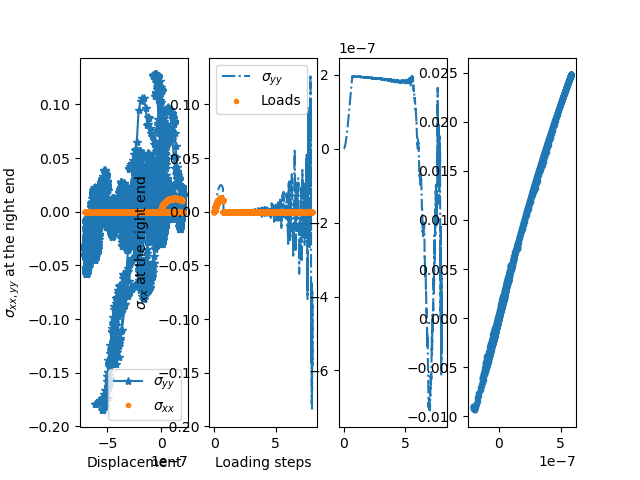

In [36]:
import matplotlib.pyplot as plt
plt.subplot(1,4,1)
plt.plot(results[:, 0], results[:, 1], "-*")
plt.plot(results[:, 0], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Displacement")
plt.ylabel("$\sigma_{xx,yy}$ at the right end")
plt.legend(["$\sigma_{yy}$","$\sigma_{xx}$","Loads"])
plt.subplot(1,4,2)
plt.plot(results[:, 2], results[:, 1], "-.")
plt.plot(results[:, 2], results[:, 3]*0.2*q_lim, ".")
plt.xlabel("Loading steps")
plt.ylabel("$\sigma_{xx}$ at the right end")
plt.legend(["$\sigma_{yy}$","Loads"])
plt.subplot(1,4,3)
plt.plot(results[:, 2], results[:, 0], "-.")
plt.subplot(1,4,4)
N_pt = 10000;
plt.plot(results[:N_pt, 4], results[:N_pt, 1], ".-")
plt.show()

<IPython.core.display.Javascript object>


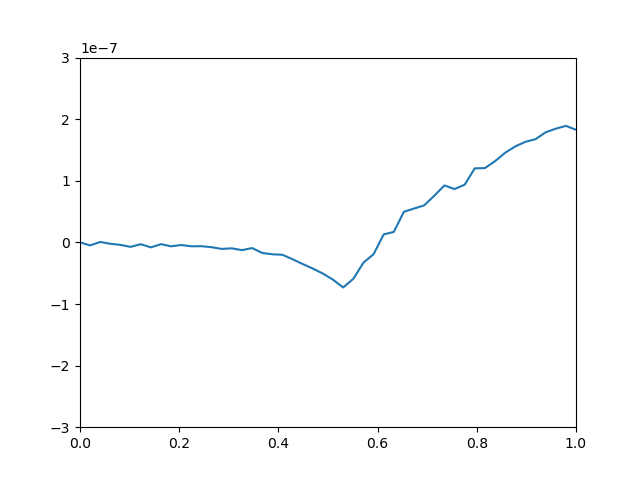

In [37]:
fig, ax = plt.subplots()

line, = ax.plot([])

ax.set_xlim(0,1)
ax.set_ylim(-0.3e-6,0.3e-6)

def animate(frame_num):
    # ax.clear()
    line.set_data((np.linspace(0,1,50), results_1d[frame_num, :]))
    return line

ani = FuncAnimation(fig, animate, frames=Nincr, interval=1)


plt.show()